In [1]:
import pandas as pd
from scipy import stats
import glob
import os
import numpy as np

### Import CSV 

In [2]:
def load_csv_data_from_directory(directory_path):
    # Use glob to match all csv files in the directory
    csv_files = glob.glob(os.path.join(directory_path, '*.csv'))
    print(f'Found {len(csv_files)} CSV files.')  # Debug print statement
    
    # Create an empty list to hold DataFrames
    dataframes_list = []
    
    # Loop through the list of csv files
    for csv_file in csv_files:
        print(f'Reading {csv_file}...')  # Debug print statement
        df = pd.read_csv(csv_file)
        dataframes_list.append(df)
    
    # Concatenate all the DataFrames in the list
    if dataframes_list:
        combined_dataframe = pd.concat(dataframes_list, ignore_index=True)
        return combined_dataframe
    else:
        print("No CSV files found in the directory.")
        return pd.DataFrame()  # Return an empty DataFrame if no csv files were found

In [3]:
# Define a function that loads all the csv files in a path, each in a separate DataFrame
def load_csv_files(path):
    files = os.listdir(path)
    dataframes = {}
    for file in files:
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(path, file))
            key = os.path.splitext(file)[0]
            dataframes[key] = df
    return dataframes

In [4]:
path = "ParticipantData"
csv_dataframes = load_csv_files(path)

C:\Users\Mobile Workstation 3\AppData\Local\Temp\ipykernel_27060\1482839295.py:2: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  csv_dataframes = load_csv_files(path)


### Nback Task Working Memory

In [5]:
nback_dfs = {}
# Fetch the dataframes that start with a nback
nback_dataframekeys = [key for key in csv_dataframes.keys() if key.startswith('nback')]
nback_dataframekeys.sort()
psychopydf = csv_dataframes[nback_dataframekeys[0]]

nback_dfs = {}
# Fetch the dataframes that start with a digit
for key in csv_dataframes.keys():
    if key.startswith('nback'):
        nback_dfs[key] = csv_dataframes[key]

In [6]:
# Dictionary to hold the scores of all participants
nback_participants_data = {}

participants_indexes = []
# Fetch the digits from the dataframe keys, those are the first digits after the word 'nback' and before the first underscore
for key in nback_dfs.keys():
    participants_indexes.append(int(key[5:].split('_')[0]))
participants_indexes.sort()

for idx in participants_indexes:
    # Fetch the dataframe for the participant
    key = [key for key in nback_dfs.keys() if key.startswith(f'nback{idx}_')][0]
    psychopydf = nback_dfs[key]
    
    # Check if 'response_0.rt' column exists, if not add it as an empty column
    if 'response_0.rt' not in psychopydf.columns:
        psychopydf['response_0.rt'] = np.nan

    # Select the columns from any of the dataframes
    psychopydf_selectedcols = psychopydf[['response_0.keys', 'response_0.corr', 'response_1.keys', 'response_1.corr', 'response_2.keys', 'response_2.corr',
                                          'response_0.rt', 'response_1.rt', 'response_2.rt', 'corrAns', 'trials_0.thisN', 'trials_1.thisN', 'trials_2.thisN']]

    # Initialize the participant data
    participant_data = {
        'hits': [],
        'hit_rate': [],
        'correct_rejections': [],
        'rt_target': [],
        'rt_non_target': [],
        'composite_score': [],
    }

    for i in range(3):  # for nback0, nback1, nback2
        trials_col = f'trials_{i}.thisN'
        response_col = f'response_{i}.'
        
        # Calculate Hits and Hit Rate
        total_targets = len(psychopydf_selectedcols[(psychopydf_selectedcols[trials_col].notna()) & (psychopydf_selectedcols['corrAns'] != 'None')])
        hits = len(psychopydf_selectedcols[(psychopydf_selectedcols[trials_col].notna()) & (psychopydf_selectedcols['corrAns'] != 'None') & (psychopydf_selectedcols[f'{response_col}corr'] == 1)])
        hit_rate = (hits / total_targets * 100) if total_targets > 0 else 0

        # Calculate Correct Rejections
        total_non_targets = len(psychopydf_selectedcols[(psychopydf_selectedcols[trials_col].notna()) & (psychopydf_selectedcols['corrAns'] == 'None')])
        correct_rejections = len(psychopydf_selectedcols[(psychopydf_selectedcols[trials_col].notna()) & (psychopydf_selectedcols['corrAns'] == 'None') & (psychopydf_selectedcols[f'{response_col}corr'] == 1)])
        correct_rejections_percentage = (correct_rejections / total_non_targets) * 100 if total_non_targets > 0 else 0

        # Calculate RT Target
        rt_target = psychopydf_selectedcols[(psychopydf_selectedcols[trials_col].notna()) & (psychopydf_selectedcols['corrAns'] != 'None') & (psychopydf_selectedcols[f'{response_col}corr'] == 1)][f'{response_col}rt'].mean() * 1000

        # Calculate RT Non-Target
        rt_non_target = psychopydf_selectedcols[(psychopydf_selectedcols[trials_col].notna()) & (psychopydf_selectedcols['corrAns'] == 'None') & (psychopydf_selectedcols[f'{response_col}corr'] == 0)][f'{response_col}rt'].mean() * 1000

        # Calculate Composite Score
        composite_score = ((hit_rate / 100) / rt_target) * 100 if rt_target > 0 else 0

        # Add the scores to the participant data
        participant_data['hits'].append(hits)
        participant_data['hit_rate'].append(hit_rate)
        participant_data['correct_rejections'].append(correct_rejections_percentage)
        participant_data['rt_target'].append(rt_target)
        participant_data['rt_non_target'].append(rt_non_target)
        participant_data['composite_score'].append(composite_score)
        
    # Add the participant data to the main dictionary
    nback_participants_data[idx] = participant_data
    
print(nback_participants_data)

{2: {'hits': [8, 9, 7], 'hit_rate': [100.0, 90.0, 87.5], 'correct_rejections': [100.0, 100.0, 93.75], 'rt_target': [429.662737500621, 468.9398778007469, 395.24815713853707], 'rt_non_target': [nan, nan, 1204.8808499821462], 'composite_score': [0.23274068536105127, 0.191922257544156, 0.2213799063187806]}, 3: {'hits': [8, 10, 8], 'hit_rate': [100.0, 100.0, 100.0], 'correct_rejections': [100.0, 100.0, 96.875], 'rt_target': [432.0889249938773, 444.56208002520725, 543.1930249906145], 'rt_non_target': [nan, nan, 2013.5157000040635], 'composite_score': [0.2314338420069827, 0.2249404627455627, 0.18409662016872885]}, 4: {'hits': [8, 4, 8], 'hit_rate': [100.0, 40.0, 100.0], 'correct_rejections': [100.0, 100.0, 96.875], 'rt_target': [404.70643748994917, 649.7102749708574, 789.0615499636624], 'rt_non_target': [nan, nan, 1578.8971000583842], 'composite_score': [0.2470926843175888, 0.06156590335868429, 0.12673282585446619]}, 10: {'hits': [8, 10, 8], 'hit_rate': [100.0, 100.0, 100.0], 'correct_rejecti

In [7]:
#TODO: Uncomment out if needed for calibrating the time (FNIRS)
"""
# Calculate the average time for each n-back for each participant
#participants_avg_nback_start_time = {}
#participants_avg_nback0_time = {}
#participants_avg_nback1_time = {}
#participants_avg_nback2_time = {}
#participants_avg_nback_end_time = {}

for idx in participants_indexes:
    # Fetch the dataframe for the participant
    key = [key for key in nback_dfs.keys() if key.startswith(f'nback{idx}_')][0]
    psychopydf = nback_dfs[key]
    
    # Select the columns from any of the dataframes
    psychopydf_selectedcols = psychopydf[['instructions.started', 'Instructions.stopped', 'instructions_1.started','response_0.corr', 'Instructions_1.stopped', 'instructions_2.started', 
                                          'response_1.corr', 'Instructions_2.stopped', 'thank_you.started', 'response_2.corr', 'End.stopped', 'response_0.rt', 'response_1.rt', 'response_2.rt']]
    
    
    # Calculate the average time for each n-back
    #avg_nback_start_time = psychopydf_selectedcols['Instructions.stopped'].mean() - psychopydf_selectedcols['instructions.started'].mean()
    #avg_nback0_time = psychopydf_selectedcols['instructions_1.started'].mean() - psychopydf_selectedcols['Instructions.stopped'].mean()
    #avg_nback1_time = psychopydf_selectedcols['instructions_2.started'].mean() - psychopydf_selectedcols['Instructions_1.stopped'].mean()
    #avg_nback2_time = psychopydf_selectedcols['thank_you.started'].mean() - psychopydf_selectedcols['Instructions_2.stopped'].mean()
    #avg_nback_end_time = psychopydf_selectedcols['End.stopped'].mean() - psychopydf_selectedcols['thank_you.started'].mean()
    
    # Add the scores to the dictionaries
    #participants_avg_nback_start_time[idx] = avg_nback_start_time
    #participants_avg_nback0_time[idx] = avg_nback0_time
    #participants_avg_nback1_time[idx] = avg_nback1_time
    #participants_avg_nback2_time[idx] = avg_nback2_time
    #participants_avg_nback_end_time[idx] = avg_nback_end_time
"""

"\n# Calculate the average time for each n-back for each participant\n#participants_avg_nback_start_time = {}\n#participants_avg_nback0_time = {}\n#participants_avg_nback1_time = {}\n#participants_avg_nback2_time = {}\n#participants_avg_nback_end_time = {}\n\nfor idx in participants_indexes:\n    # Fetch the dataframe for the participant\n    key = [key for key in nback_dfs.keys() if key.startswith(f'nback{idx}_')][0]\n    psychopydf = nback_dfs[key]\n    \n    # Select the columns from any of the dataframes\n    psychopydf_selectedcols = psychopydf[['instructions.started', 'Instructions.stopped', 'instructions_1.started','response_0.corr', 'Instructions_1.stopped', 'instructions_2.started', \n                                          'response_1.corr', 'Instructions_2.stopped', 'thank_you.started', 'response_2.corr', 'End.stopped', 'response_0.rt', 'response_1.rt', 'response_2.rt']]\n    \n    \n    # Calculate the average time for each n-back\n    #avg_nback_start_time = psychopydf_s

In [8]:
participants_nback_data_per_trial = {}

for idx in participants_indexes:
    # Fetch the dataframe for the participant
    key = [key for key in nback_dfs.keys() if key.startswith(f'nback{idx}_')][0]
    psychopydf = nback_dfs[key]
    
    # Initialize the participant data
    participant_data = {
        '0_correct': [],
        '1_correct': [],
        '2_correct': [],
        '0_key': [],
        '1_key': [],
        '2_key': [],
        '0_rt': [],
        '1_rt': [],
        '2_rt': []
    }

    for i in range(3):  # for nback0, nback1, nback2
        # Select the rows for the current nback
        if i == 0:
            psychopydf_selectedcols = psychopydf.iloc[1:41]
        elif i == 1:
            psychopydf_selectedcols = psychopydf.iloc[42:82]
        else:  # i == 2
            psychopydf_selectedcols = psychopydf.iloc[83:123]

        correct = psychopydf_selectedcols[f'response_{i}.corr']
        key = psychopydf_selectedcols[f'response_{i}.keys']
        rt = psychopydf_selectedcols[f'response_{i}.rt']
        
        # Add the scores to the participant data
        participant_data[f'{i}_correct'] = correct.tolist()
        participant_data[f'{i}_key'] = key.tolist()
        participant_data[f'{i}_rt'] = rt.tolist()
        

    # Add the participant data to the main dictionary
    participants_nback_data_per_trial[idx] = participant_data

### MRT Spatial Ability

In [9]:
import pandas as pd

# Fetch the MRT_spatial_ability.csv file in the ParticipantData directory
mrt_df = pd.read_csv('ParticipantData/MRT_spatial_ability.csv')

# Calculate the median of the 'MRTScore' column
mrt_median = mrt_df['MRTScore'].median()

# Initially assign all participants to the 'Low' group
mrt_df['MRTGroup'] = 'Low'

# Get the indices of the participants at the median
indices_at_median = mrt_df[mrt_df['MRTScore'] == mrt_median].index

# Calculate the index that splits the participants at the median in half
split_index = len(indices_at_median) // 2

# Assign 'High' to the top 50% of participants
mrt_df.loc[mrt_df['MRTScore'].sort_values(ascending=False).index[:len(mrt_df)//2], 'MRTGroup'] = 'High'

# Create a dictionary to hold the MRTScore, MRT Acc, and MRTGroup of each participant
mrt_participants_data = {}

for idx in participants_indexes:
    # Fetch the data for the participant and reset the index
    mrt_participant_data = mrt_df[mrt_df['ParticipantID'] == idx].reset_index(drop=True)
    
    # Check if the participant exists in the DataFrame
    if not mrt_participant_data.empty:
        # Add the data to the dictionary
        mrt_participants_data[idx] = {
            'MRTScore': mrt_participant_data['MRTScore'][0],
            'MRTAcc': mrt_participant_data['MRTAcc'][0],
            'MRTGroup': mrt_participant_data['MRTGroup'][0]
        }
    else:
        print(f"No data found for participant {idx}")
        
# Count the number of 'Low' and 'High' values in the 'MRTGroup' column
mrt_group_counts = mrt_df['MRTGroup'].value_counts()

# Print the counts
print(mrt_group_counts)

Low     30
High    30
Name: MRTGroup, dtype: int64


### ActiveTime

In [10]:
# Get the ActiveTime dataframes from csv files that start with activeTime_participant followed by the idx of the participant
activeTime_dataframes = {}
for idx in participants_indexes:
    key = [key for key in csv_dataframes.keys() if key.startswith(f'activeTime_participant{idx}_')][0]
    activeTime_dataframes[key] = csv_dataframes[key]
activetime_keys = list(activeTime_dataframes.keys())
#activeTime_dataframes[activetime_keys[0]]

In [11]:
#print columns of dataframe
for i in activeTime_dataframes[activetime_keys[0]].columns:
    print(i)

Timestamp
 ActivePhase
 EndActivePhase
 CurrentTrial
 StimulusQuestion


In [12]:
# Initialize a dictionary to store the results
activeTime_data = {}

# Loop over the keys in activetime_keys
for key in activetime_keys:
    # Fetch the DataFrame for the current key
    participant_df = activeTime_dataframes[key] #TODO

    # Perform the same calculations as before, but on the fetched DataFrame
    phases = ['Start', 'Calibration', 'Tutorial', 'Rest']
    end_phases = ['EndofStart', 'EndofCalibration', 'EndofTutorial', 'EndofRest']
    durations = {}

    for phase, end_phase in zip(phases, end_phases):
        phase_df = participant_df[participant_df[' ActivePhase'] == phase]
        end_phase_df = participant_df[participant_df[' EndActivePhase'] == end_phase]

        # Calculate the duration of each phase
        duration = end_phase_df['Timestamp'].values - phase_df['Timestamp'].values #TODO

        # Store the results in the dictionary
        durations[phase] = duration

    # Extract the participant number from the key
    participant_number = int(key.split('participant')[1].split('_')[0]) #TODO

    # Store the participant's data in the main dictionary using the participant number as the key
    activeTime_data[participant_number] = durations

# Print the dictionary
print(activeTime_data)

{2: {'Start': array([689.8644]), 'Calibration': array([21.4461]), 'Tutorial': array([427.7345]), 'Rest': array([300.006])}, 3: {'Start': array([355.7957]), 'Calibration': array([6.8837]), 'Tutorial': array([402.9241]), 'Rest': array([300.0095])}, 4: {'Start': array([119.495]), 'Calibration': array([6.7635]), 'Tutorial': array([448.2359]), 'Rest': array([300.0153])}, 10: {'Start': array([256.7826]), 'Calibration': array([5.823]), 'Tutorial': array([590.3329]), 'Rest': array([300.0045])}, 15: {'Start': array([127.475]), 'Calibration': array([8.6062]), 'Tutorial': array([717.8423]), 'Rest': array([300.0025])}, 16: {'Start': array([681.0095]), 'Calibration': array([5.9546]), 'Tutorial': array([389.0769]), 'Rest': array([300.006])}, 20: {'Start': array([443.1895]), 'Calibration': array([36.074]), 'Tutorial': array([519.9725]), 'Rest': array([300.007])}, 21: {'Start': array([738.7303]), 'Calibration': array([5.5453]), 'Tutorial': array([439.4244]), 'Rest': array([300.003])}, 22: {'Start': ar

In [13]:
# Initialize a dictionary to store the times
experiment_set_times_dict = {}

# Loop over the keys in activetime_keys
for key in activetime_keys:
    # Fetch the DataFrame for the current key
    participant_df = activeTime_dataframes[key] #TODO

    # Initialize variables
    experiment_times = []
    start_time = None
    count = 0

    # Loop over the rows in the DataFrame
    for index, row in participant_df.iterrows():
        if row[' ActivePhase'] == 'Experimental':
            # If this is the first 'Experimental' entry, store the timestamp
            if count == 0:
                start_time = row['Timestamp']
            count += 1
        elif row[' ActivePhase'] == 'Feedback' and count == 5:
            # Calculate the time difference and store it in the list
            end_time = row['Timestamp']
            experiment_times.append(end_time - start_time)

            # Reset the count and start_time
            count = 0
            start_time = None

    # Extract the participant number from the key
    participant_number = int(key.split('participant')[1].split('_')[0]) #TODO

    # Store the result in the dictionary using the participant number as the key
    experiment_set_times_dict[participant_number] = experiment_times

# Print the dictionary
print(experiment_set_times_dict)

{2: [121.68100000000004, 109.62699999999995, 140.31499999999983, 89.45800000000008, 144.34500000000003, 126.91899999999987, 122.38200000000006, 126.63200000000006], 3: [92.54500000000007, 55.68599999999992, 95.07400000000007, 93.19999999999982, 78.32200000000012, 93.39200000000005, 69.53499999999985, 82.37299999999982], 4: [128.1916, 80.10100000000011, 132.47000000000003, 135.61299999999983, 99.10299999999984, 100.94200000000001, 98.49499999999989, 113.47700000000009], 10: [169.0250000000001, 92.92099999999982, 184.56799999999998, 122.03199999999993, 157.93900000000008, 116.29199999999992, 104.90600000000018, 138.31500000000005], 15: [174.07399999999984, 105.14300000000003, 167.7829999999999, 127.3599999999999, 151.72399999999993, 121.98799999999983, 129.42499999999973, 126.25599999999986], 16: [132.40499999999997, 54.61400000000003, 72.32999999999993, 77.66500000000019, 81.91300000000001, 60.605999999999995, 59.15099999999984, 61.825000000000045], 20: [184.24399999999991, 124.048, 122

In [14]:
# Initialize a dictionary to store the results
experiment_phase_trials_dict = {}

# Loop over the keys in activetime_keys
for key in activetime_keys:
    # Fetch the DataFrame for the current key
    activeTimedf = activeTime_dataframes[key]

    # Filter the DataFrame to find rows where ActivePhase is 'Experimental'and CurrentTrial is between 0 and 31
    experiment_phase_trials = activeTimedf[
        (activeTimedf[' ActivePhase'].str.strip() == 'Experimental') &
        (activeTimedf[' CurrentTrial'].between(0, 31))
    ]

    # Extract Timestamp values for these specific trials
    timestamps = experiment_phase_trials['Timestamp'] #TODO
    experiment_phase_trials = experiment_phase_trials.sort_values(' CurrentTrial')

    # Calculate the time duration for each trial by subtracting the timestamp of the current trial from the next trial
    experiment_phase_trials['TrialDuration'] = experiment_phase_trials['Timestamp'].shift(-1) - experiment_phase_trials['Timestamp']

    # Find the last 'Experimental' entry and its timestamp
    last_experimental_timestamp = activeTimedf[
        (activeTimedf[' ActivePhase'] == 'Experimental') & 
        (activeTimedf[' CurrentTrial'].astype(int) == 31)
    ]['Timestamp'].values[0]

    # Find the timestamp of the last 'Feedback' entry after the last 'Experimental' entry
    last_feedback_timestamp = activeTimedf[
        (activeTimedf[' ActivePhase'] == 'Feedback') & 
        (activeTimedf['Timestamp'] > last_experimental_timestamp)
    ]['Timestamp'].values[0]

    # Calculate the duration of the last trial
    last_trial_duration = last_feedback_timestamp - last_experimental_timestamp

    # Drop the NaN value from the last trial duration calculated by the shift if it's not already dropped
    experiment_phase_trials = experiment_phase_trials[:-1]

    # Append the last trial duration
    last_trial_row = pd.DataFrame({
        ' CurrentTrial': [31],
        'Timestamp': [last_experimental_timestamp],
        'TrialDuration': [last_trial_duration]
    })

    # Append the last trial row to the experiment_phase_trials DataFrame
    experiment_phase_trials = experiment_phase_trials.append(last_trial_row, ignore_index=True)
    experiment_phase_trials = experiment_phase_trials.sort_values(' CurrentTrial')

    # Extract the participant number from the key
    participant_number = int(key.split('participant')[1].split('_')[0]) #TODO

    # Store the result in the dictionary using the participant number as the key
    experiment_phase_trials_dict[participant_number] = experiment_phase_trials[[' CurrentTrial', 'Timestamp', 'TrialDuration']]

# Print the dictionary
#for key, value in experiment_phase_trials_dict.items():
#    print(f"Participant {key}:")
#    print(value)
experiment_phase_trials_dict


{2:      CurrentTrial  Timestamp  TrialDuration
 0               0   1452.293         45.052
 1               1   1497.345         11.150
 2               2   1508.495         33.854
 3               3   1542.349         28.178
 4               4   1570.527         42.835
 5               5   1613.362         31.193
 6               6   1644.555         12.033
 7               7   1656.588         25.688
 8               8   1682.276         39.247
 9               9   1721.523         31.576
 10             10   1753.099         40.256
 11             11   1793.355         31.655
 12             12   1825.010         15.026
 13             13   1840.036         22.374
 14             14   1862.410         23.823
 15             15   1886.233         30.130
 16             16   1916.363         28.632
 17             17   1944.995         35.161
 18             18   1980.156         42.170
 19             19   2022.326         40.552
 20             20   2062.878         25.312
 21    

### Feedback

In [15]:
# Define the directory where the files are located
directory = 'ParticipantData'

# Get a list of all feedback files
feedback_files = [f for f in os.listdir(directory) if 'feedback' in f]

# Initialize dictionaries to store the keys and dataframes
feedback_keys = []
feedback_dataframes = {}

# Loop over the feedback files
for file in feedback_files:
    # Read the file into a dataframe
    df = pd.read_csv(os.path.join(directory, file)) #TODO

    # Generate a key for the dataframe
    key = file #TODO

    # Store the key and dataframe in the dictionaries
    feedback_keys.append(key)
    feedback_dataframes[key] = df
print(feedback_keys)

['feedback_participant10__2023_12_7_19_13_57.csv', 'feedback_participant15__2023_12_11_14_2_52.csv', 'feedback_participant16__2023_12_11_16_15_30.csv', 'feedback_participant20__2023_12_11_18_20_19.csv', 'feedback_participant21__2023_12_12_11_20_59.csv', 'feedback_participant22__2023_12_12_15_10_1.csv', 'feedback_participant23__2023_12_12_18_1_13.csv', 'feedback_participant24__2023_12_13_13_35_48.csv', 'feedback_participant25__2023_12_13_18_34_56.csv', 'feedback_participant26__2023_12_14_14_28_0.csv', 'feedback_participant27__2023_12_14_16_12_49.csv', 'feedback_participant28__2023_12_14_17_58_57.csv', 'feedback_participant29__2023_12_15_10_17_24.csv', 'feedback_participant2__2023_12_7_12_29_23.csv', 'feedback_participant30__2023_12_15_13_32_17.csv', 'feedback_participant31__2023_12_15_16_5_36.csv', 'feedback_participant32__2023_12_18_10_21_54.csv', 'feedback_participant33__2023_12_18_12_14_51.csv', 'feedback_participant34__2023_12_18_14_9_13.csv', 'feedback_participant35__2023_12_18_16_

In [16]:
# Initialize a dictionary to store the results
feedback = {}

# Loop over the keys in feedback_keys
for key in feedback_keys:
    # Fetch the DataFrame for the current key
    feedbackdf = feedback_dataframes[key]

    # Get Tutorial rows in ActivePhase column
    tutorial_feedback = feedbackdf[feedbackdf[' ActivePhase'] == 'Tutorial']
    tutorial_feedback_score = tutorial_feedback[' FeedbackScore']

    # Get Rest row in ActivePhase column
    rest_feedback = feedbackdf[feedbackdf[' ActivePhase'] == 'Rest']
    rest_feedback_score = rest_feedback[' FeedbackScore']

    # If there are multiple 'Rest' entries, discard the first one
    if len(rest_feedback) > 1:
        rest_feedback = rest_feedback.iloc[1:]

    # Get FeedbackScore column for every instance of "Experimental" in ActivePhase column
    experimental_feedback = feedbackdf[feedbackdf[' ActivePhase'] == 'Experimental']
    experimental_feedback['Number'] = (experimental_feedback[' ActivePhase'] == 'Experimental').cumsum()
    experimental_feedback_score = experimental_feedback[' FeedbackScore']

    # Concatenate all phases together and reset the index
    all_phases = pd.concat([tutorial_feedback, rest_feedback, experimental_feedback]) #TODO
    all_phases = all_phases.reset_index(drop=True)

    # Extract the participant number from the key
    participant_number = int(key.split('participant')[1].split('_')[0]) #TODO

    # Store the result in the dictionary using the participant number as the key
    feedback[participant_number] = {
        'tutorial': all_phases[all_phases[' ActivePhase'] == 'Tutorial'][[' ActivePhase', ' StimulusQuestion', ' FeedbackScore', ' TimeDifference']],
        'rest': all_phases[all_phases[' ActivePhase'] == 'Rest'][[' ActivePhase', ' FeedbackScore', ' TimeDifference']],
        'experimental': all_phases[all_phases[' ActivePhase'] == 'Experimental'][[' ActivePhase', 'Number', ' FeedbackScore', ' TimeDifference']]
    }

print(feedback[30]['rest'])

   ActivePhase   FeedbackScore   TimeDifference
3         Rest               1          9.02478


C:\Users\Mobile Workstation 3\AppData\Local\Temp\ipykernel_27060\21888083.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experimental_feedback['Number'] = (experimental_feedback[' ActivePhase'] == 'Experimental').cumsum()


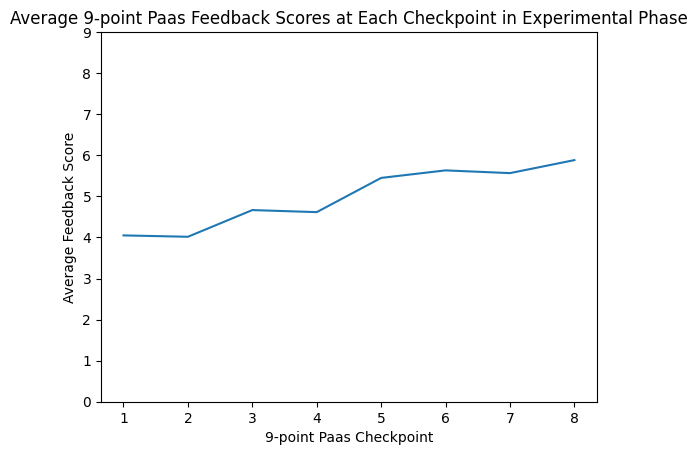

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize an empty DataFrame to store all feedback scores
all_feedback = pd.DataFrame()

# Loop over the feedback dictionary
for participant_number, participant_data in feedback.items():
    # Append the 'experimental' DataFrame to all_feedback
    all_feedback = all_feedback.append(participant_data['experimental'])

# Group by 'Number' and calculate the mean ' FeedbackScore'
average_feedback = all_feedback.groupby('Number')[' FeedbackScore'].mean()

# Plot the average feedback scores
plt.plot(average_feedback.index, average_feedback.values)
plt.xlabel('9-point Paas Checkpoint')
plt.ylabel('Average Feedback Score')
plt.title('Average 9-point Paas Feedback Scores at Each Checkpoint in Experimental Phase')
plt.ylim(0, 9)
plt.show()

#TODO: put all participants scores in graph 

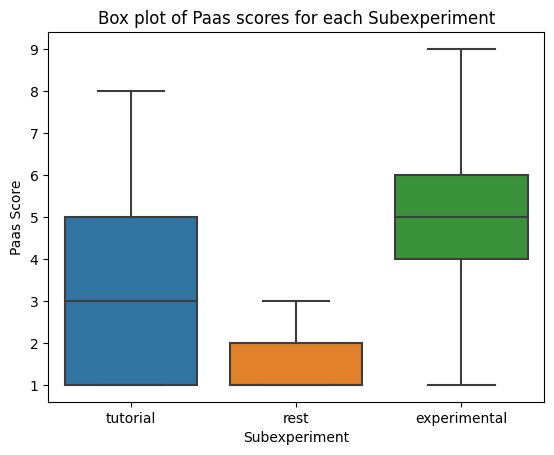

In [18]:
# Create an empty DataFrame to store the reshaped data
reshaped_data = pd.DataFrame(columns=['Subexperiment', 'Participant', 'Paas Score']) #TODO

# Loop over the feedback dictionary
for participant_number, participant_data in feedback.items():
    # Loop over each phase
    for phase in ['tutorial', 'rest', 'experimental']:
        # Create a DataFrame for the current phase
        phase_data = pd.DataFrame({
            'Subexperiment': phase,
            'Participant': participant_number,
            'Paas Score': participant_data[phase][' FeedbackScore']
        })
        # Append the phase data to the reshaped data
        reshaped_data = reshaped_data.append(phase_data, ignore_index=True)
        
import seaborn as sns

# Create a box plot
sns.boxplot(x='Subexperiment', y='Paas Score', data=reshaped_data, showfliers=False)

plt.title('Box plot of Paas scores for each Subexperiment')
plt.show()

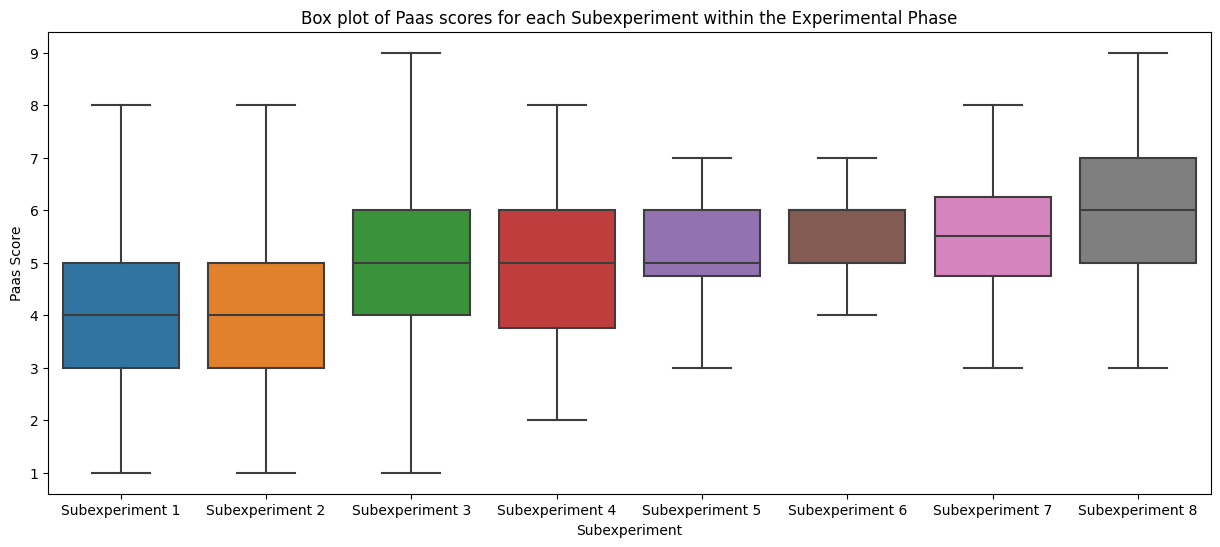

In [19]:

# Create an empty DataFrame to store the reshaped data
reshaped_data = pd.DataFrame(columns=['Subexperiment', 'Participant', 'Paas Score']) #TODO

# Loop over the feedback dictionary
for participant_number, participant_data in feedback.items():
    # Loop over each subexperiment within the experimental phase
    for subexperiment_number in range(1, 9):  # Assuming there are 8 subexperiments
        # Create a DataFrame for the current subexperiment
        subexperiment_data = pd.DataFrame({
            'Subexperiment': 'Subexperiment ' + str(subexperiment_number),
            'Participant': participant_number,
            'Paas Score': participant_data['experimental'][participant_data['experimental']['Number'] == subexperiment_number][' FeedbackScore']
        })
        # Append the subexperiment data to the reshaped data
        reshaped_data = reshaped_data.append(subexperiment_data, ignore_index=True) #TODO
        
import seaborn as sns
plt.figure(figsize=(15, 6))
# Create a box plot
sns.boxplot(x='Subexperiment', y='Paas Score', data=reshaped_data, showfliers=False)

plt.title('Box plot of Paas scores for each Subexperiment within the Experimental Phase')
plt.show()


## Answers

In [20]:
# Define the directory where the files are located
directory = 'ParticipantData' 

# Get a list of all feedback files
answers_files = [f for f in os.listdir(directory) if 'answers' in f]

# Initialize dictionaries to store the keys and dataframes
answers_keys = []
answers_dataframes = {}

# Loop over the feedback files
for file in answers_files:
    # Read the file into a dataframe
    df = pd.read_csv(os.path.join(directory, file)) 

    # Extract the participant number from the filename
    participant_number = int(file.split('participant')[1].split('_')[0])

    # Use the participant number as the key
    key = participant_number 

    # Store the key and dataframe in the dictionaries
    answers_keys.append(key)
    answers_dataframes[key] = df
print(answers_keys)

[10, 15, 16, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 2, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 3, 40, 41, 44, 45, 46, 47, 48, 49, 4, 50, 51, 52, 53, 54, 56, 57, 59, 60, 61, 62, 65, 66, 67, 68, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]


In [21]:
# Initialize a dictionary to store the results
answers_data = {}

# Loop over the keys in answers_keys
for key in answers_keys:
    # Fetch the DataFrame for the current key
    answersdf = answers_dataframes[key]

    # Assuming 'IsCorrect' column is a boolean where True is a correct answer and False is incorrect
    # Convert 'IsCorrect' to integers
    answersdf[' IsCorrect'] = answersdf[' IsCorrect'].astype(int)

    # Now, we calculate the sum of correct and incorrect trials
    correct_sum = answersdf[' IsCorrect'].sum()
    incorrect_sum = len(answersdf) - correct_sum

    # Calculate the overall accuracy
    overall_accuracy = (correct_sum / 32) * 100

    # Create a new DataFrame for the sums
    sum_df = pd.DataFrame({
        'Score': ['Correct', 'Incorrect'],
        'Total Trials': [correct_sum, incorrect_sum]
    })

    # Store the result in the dictionary using the key
    answers_data[key] = {'Total': sum_df, 'Accuracy': overall_accuracy}

    # Create a new column 'SubExperiment' that assigns a unique sub-experiment number to each set of 4 rows
    answersdf['SubExperiment'] = answersdf.index // 4

    # Group by 'SubExperiment' and calculate the sum of correct and incorrect answers for each group
    subexp_data = answersdf.groupby('SubExperiment')[' IsCorrect'].agg(['sum', 'count'])
    subexp_data['Incorrect'] = subexp_data['count'] - subexp_data['sum']

    # Calculate the accuracy for each sub-experiment
    subexp_data['Accuracy'] = (subexp_data['sum'] / 32) * 100

    # Store the result in the dictionary using the key
    answers_data[key]['SubExperiments'] = subexp_data

    # Create a new column 'Trial' that assigns a unique trial number to each row
    answersdf['Trial'] = answersdf.index + 1

    # Group by 'Trial' and calculate the sum of correct and incorrect answers for each trial
    trial_data = answersdf.groupby(['SubExperiment', 'Trial'])[' IsCorrect'].agg(['sum', 'count'])
    trial_data['Incorrect'] = trial_data['count'] - trial_data['sum']

    # Store the result in the dictionary using the key
    answers_data[key]['Trials'] = trial_data

print(answers_data[2]['Accuracy'])

answers_data

#print Trials data for participant 2
answers_data[2]

46.875


{'Total':        Score  Total Trials
 0    Correct            15
 1  Incorrect            17,
 'Accuracy': 46.875,
 'SubExperiments':                sum  count  Incorrect  Accuracy
 SubExperiment                                 
 0                2      4          2     6.250
 1                3      4          1     9.375
 2                1      4          3     3.125
 3                1      4          3     3.125
 4                1      4          3     3.125
 5                3      4          1     9.375
 6                3      4          1     9.375
 7                1      4          3     3.125,
 'Trials':                      sum  count  Incorrect
 SubExperiment Trial                       
 0             1        1      1          0
               2        0      1          1
               3        1      1          0
               4        0      1          1
 1             5        1      1          0
               6        1      1          0
               7        

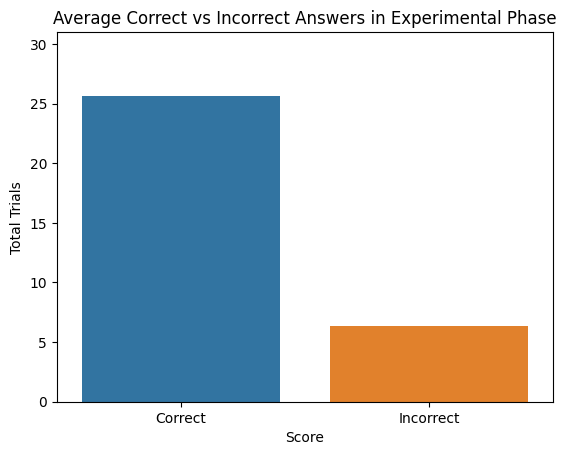

In [22]:
# Initialize a DataFrame to store the combined data
combined_df = pd.DataFrame({ #TODO
    'Score': ['Correct', 'Incorrect'],
    'Total Trials': [0, 0]
})

# Loop over the keys in answers_data
for key in answers_data:
    # Add the data for the current participant to the combined data
    combined_df['Total Trials'] += answers_data[key]['Total']['Total Trials']

# Calculate the average
combined_df['Total Trials'] /= len(answers_data)

# Plot the average data
sns.barplot(x='Score', y='Total Trials', data=combined_df)
plt.title('Average Correct vs Incorrect Answers in Experimental Phase')
plt.ylim(0, 31)  # Set the y-axis limits
plt.show()

In [23]:
combined_df.columns

Index(['Score', 'Total Trials'], dtype='object')

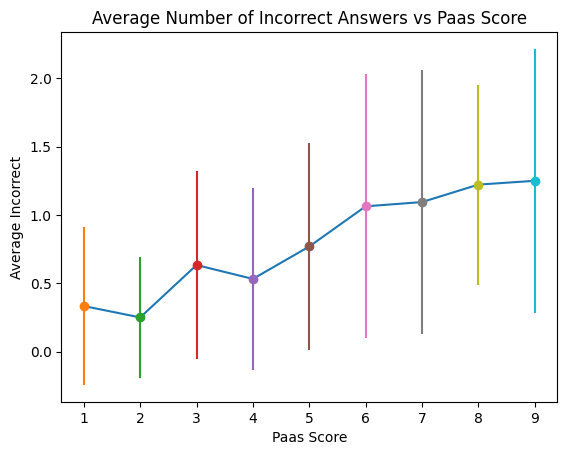

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize lists to store the Paas scores and incorrect answers
paas_scores = []
incorrect_answers = []

# Loop over the feedback dictionary
for participant_number, participant_data in feedback.items():
    # Extract the Paas scores
    paas_scores.extend(participant_data['experimental'][' FeedbackScore'])
    # Extract the incorrect answers
    incorrect_answers.extend(answers_data[participant_number]['SubExperiments']['Incorrect'])

# Create a DataFrame from the Paas scores and incorrect answers
data = pd.DataFrame({ #TODO
    'Paas Score': paas_scores,
    'Incorrect': incorrect_answers
})

# Group the DataFrame by the Paas score and calculate the average number of incorrect answers
average_incorrect = data.groupby('Paas Score')['Incorrect'].mean()

# Calculate the standard deviation of the number of incorrect answers for each Paas score
std_deviation = data.groupby('Paas Score')['Incorrect'].std() #TODO

# Reset the index of the DataFrame
average_incorrect = average_incorrect.reset_index()
std_deviation = std_deviation.reset_index()

# Merge the average and standard deviation data
plot_data = pd.merge(average_incorrect, std_deviation, on='Paas Score') #TODO
plot_data.columns = ['Paas Score', 'Average Incorrect', 'Std Deviation']

# Plot the average number of incorrect answers against the Paas score with error bars
sns.lineplot(x='Paas Score', y='Average Incorrect', data=plot_data)
for _, row in plot_data.iterrows():
    plt.errorbar(x=row['Paas Score'], y=row['Average Incorrect'], yerr=row['Std Deviation'], fmt='o')
plt.title('Average Number of Incorrect Answers vs Paas Score')
plt.show()

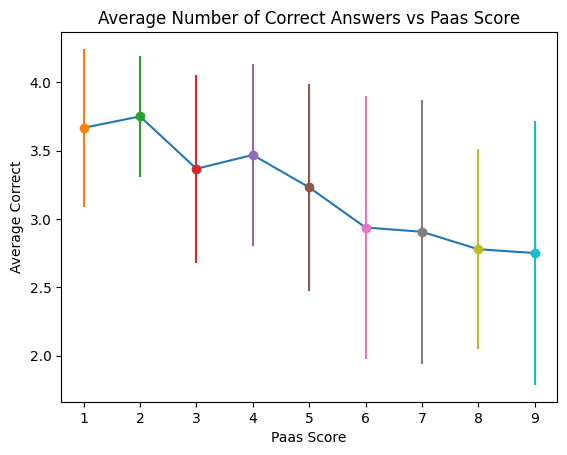

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#TODO: Same code as above but for correct answers not incorrect answers

# Initialize lists to store the Paas scores and correct answers
paas_scores = []
correct_answers = []

# Loop over the feedback dictionary
for participant_number, participant_data in feedback.items():
    # Extract the Paas scores
    paas_scores.extend(participant_data['experimental'][' FeedbackScore'])
    # Extract the correct answers
    correct_answers.extend(answers_data[participant_number]['SubExperiments']['sum'])

# Create a DataFrame from the Paas scores and correct answers
data = pd.DataFrame({ #TODO
    'Paas Score': paas_scores,
    'Correct': correct_answers
})

# Group the DataFrame by the Paas score and calculate the average number of correct answers
average_correct = data.groupby('Paas Score')['Correct'].mean()

# Calculate the standard deviation of the number of correct answers for each Paas score
std_deviation = data.groupby('Paas Score')['Correct'].std() #TODO

# Reset the index of the DataFrame
average_correct = average_correct.reset_index()
std_deviation = std_deviation.reset_index()

# Merge the average and standard deviation data
plot_data = pd.merge(average_correct, std_deviation, on='Paas Score')
plot_data.columns = ['Paas Score', 'Average Correct', 'Std Deviation']

# Plot the average number of correct answers against the Paas score with error bars
sns.lineplot(x='Paas Score', y='Average Correct', data=plot_data)
for _, row in plot_data.iterrows():
    plt.errorbar(x=row['Paas Score'], y=row['Average Correct'], yerr=row['Std Deviation'], fmt='o')
plt.title('Average Number of Correct Answers vs Paas Score')
plt.show()

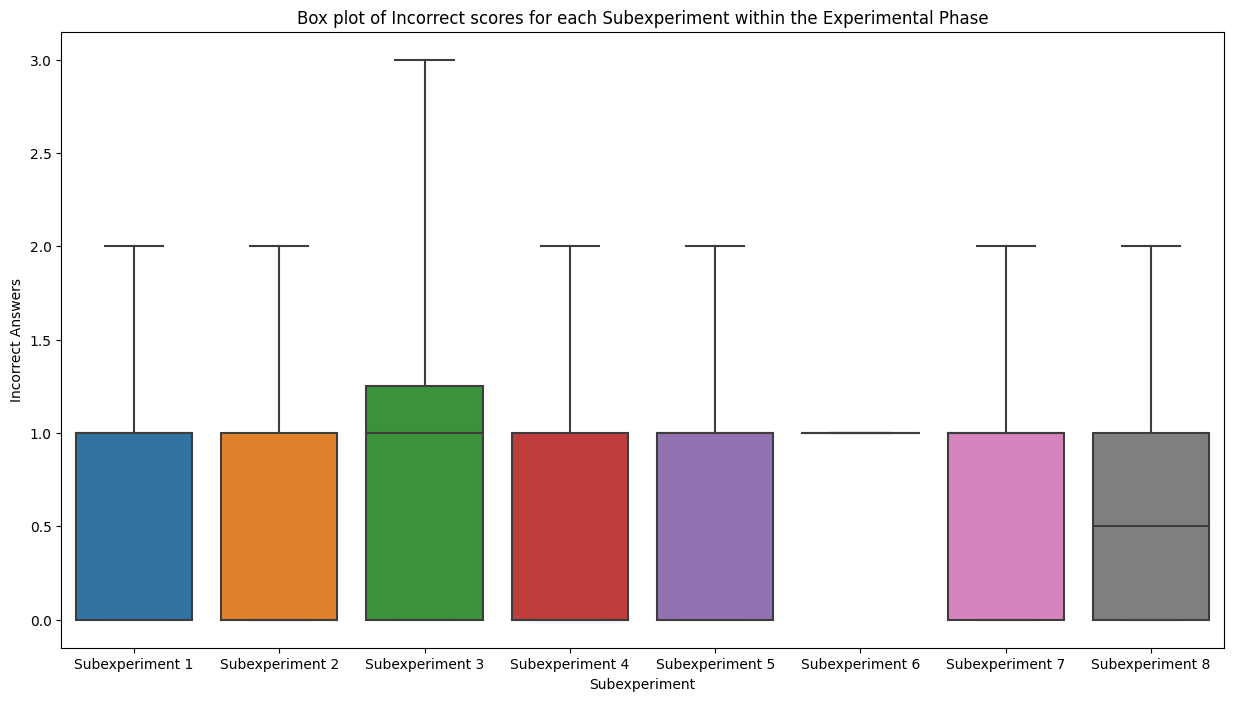

In [26]:
import matplotlib.pyplot as plt

# Create an empty DataFrame to store the reshaped data
reshaped_data = pd.DataFrame(columns=['Subexperiment', 'Participant', 'Incorrect Answers']) #TODO

# Loop over the feedback dictionary
for participant_number, participant_data in feedback.items():
    # Loop over each subexperiment within the experimental phase
    for subexperiment_number in range(1, 9):  # Assuming there are 8 subexperiments
        # Get the incorrect answers for the current participant and subexperiment
        incorrect_answers = answers_data[participant_number]['SubExperiments']['Incorrect'][subexperiment_number - 1]
        # Create a DataFrame for the current subexperiment
        subexperiment_data = pd.DataFrame({
            'Subexperiment': ['Subexperiment ' + str(subexperiment_number)],
            'Participant': [participant_number],
            'Incorrect Answers': [incorrect_answers]
        })
        # Append the subexperiment data to the reshaped data
        reshaped_data = reshaped_data.append(subexperiment_data, ignore_index=True)

# Set the figure size
plt.figure(figsize=(15, 8))

# Create a box plot
sns.boxplot(x='Subexperiment', y='Incorrect Answers', data=reshaped_data, showfliers=False)

plt.title('Box plot of Incorrect scores for each Subexperiment within the Experimental Phase')
plt.show()

#### Eye Tracking

In [27]:
# Define the directory where the files are located
directory = 'ParticipantData'

# Get a list of all feedback files
eye_tracking_files = [f for f in os.listdir(directory) if 'EyeTrackingData' in f]

# Initialize dictionaries to store the keys and dataframes
eye_tracking_keys = []
et_dfs = {}

# Loop over the feedback files
for file in eye_tracking_files:
    # Read the file into a dataframe
    df = pd.read_csv(os.path.join(directory, file))

    # Extract the participant number from the filename
    participant_number = int(file.split('Participant')[1].split('_')[0])

    # Use the participant number as the key
    key = participant_number

    # Store the key and dataframe in the dictionaries
    eye_tracking_keys.append(key)
    et_dfs[key] = df
print(et_dfs.keys())

C:\Users\Mobile Workstation 3\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3508: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


dict_keys([10, 15, 16, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 2, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 3, 40, 41, 44, 45, 46, 47, 48, 49, 4, 50, 51, 52, 53, 54, 56, 57, 59, 60, 61, 62, 65, 66, 67, 68, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81])


In [28]:
# Initialize a dictionary to store the data for each participant
eye_tracking_data = {}

for idx in participants_indexes:
    # Fetch the dataframe for the participant
    etdf = et_dfs[idx]
    
    # Select the columns from the dataframe
    etdf_selectedcols = etdf[[' FixationPointX', ' FixationPointY', ' FixationPointZ', 'LeftGazeX', ' LeftGazeY', ' LeftGazeZ', ' RightGazeX', ' RightGazeY', 
                              ' RightGazeZ', 'LeftPupilDiameter', ' RightPupilDiameter', ' LeftEyeOpenness', ' RightEyeOpenness', ' GazedObjectName', 'Timestamp']]
    
    # Convert 'Timestamp' to datetime format
    etdf_selectedcols['Timestamp'] = pd.to_datetime(etdf_selectedcols['Timestamp'], infer_datetime_format=True, errors='coerce')
    # Sort the dataframe by 'Timestamp'
    etdf_selectedcols = etdf_selectedcols.sort_values('Timestamp')
    
    # Calculate the gaze duration
    etdf_selectedcols['GazeDuration'] = etdf_selectedcols['Timestamp'].diff().dt.total_seconds()
    
    # Calculate the average time for each column and store it in a dictionary
    participant_data = {
        'avg_fixation_PointX': etdf_selectedcols[' FixationPointX'].mean(),
        'avg_fixation_PointY': etdf_selectedcols[' FixationPointY'].mean(),
        'avg_fixation_PointZ': etdf_selectedcols[' FixationPointZ'].mean(),
        'avg_LeftGazeX': etdf_selectedcols['LeftGazeX'].mean(),
        'avg_LeftGazeY': etdf_selectedcols[' LeftGazeY'].mean(),
        'avg_LeftGazeZ': etdf_selectedcols[' LeftGazeZ'].mean(),
        'avg_RightGazeX': etdf_selectedcols[' RightGazeX'].mean(),
        'avg_RightGazeY': etdf_selectedcols[' RightGazeY'].mean(),
        'avg_RightGazeZ': etdf_selectedcols[' RightGazeZ'].mean(),
        'avg_LeftPupilDiameter': etdf_selectedcols['LeftPupilDiameter'].mean(),
        'avg_RightPupilDiameter': etdf_selectedcols[' RightPupilDiameter'].mean(),
        'avg_RightEyeOpenness': etdf_selectedcols[' RightEyeOpenness'].mean(),
        'avg_LeftEyeOpenness': etdf_selectedcols[' LeftEyeOpenness'].mean(),
        'max_LeftPupilDiameter': etdf_selectedcols['LeftPupilDiameter'].max(),
        'max_RightPupilDiameter': etdf_selectedcols[' RightPupilDiameter'].max()
    }

      # Calculate the total gaze duration for each object
    gaze_durations = etdf_selectedcols.groupby(' GazedObjectName')['GazeDuration'].sum()
    
    total_gaze_duration = gaze_durations.sum()
    participant_data['total_gaze_duration'] = total_gaze_duration

    for object_name, duration in gaze_durations.items():
        if object_name.strip() == '_Left':
            participant_data['total_gaze_duration_Left'] = duration
            participant_data['percentage_gaze_Left'] = duration / total_gaze_duration
        elif object_name.strip() == '_Right':
            participant_data['total_gaze_duration_Right'] = duration
            participant_data['percentage_gaze_Right'] = duration / total_gaze_duration

    # Normalize the gaze percentages to be between 0 and 1
    total_percentage = participant_data.get('percentage_gaze_Left', 0) + participant_data.get('percentage_gaze_Right', 0) #TODO
    if 'percentage_gaze_Left' in participant_data:
        participant_data['percentage_gaze_Left'] /= total_percentage
    if 'percentage_gaze_Right' in participant_data:
        participant_data['percentage_gaze_Right'] /= total_percentage

    # Add the participant's data to the main dictionary
    eye_tracking_data[idx] = participant_data

# Print the dictionary
eye_tracking_data[40]

C:\Users\Mobile Workstation 3\AppData\Local\Temp\ipykernel_27060\3863846026.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  etdf_selectedcols['Timestamp'] = pd.to_datetime(etdf_selectedcols['Timestamp'], infer_datetime_format=True, errors='coerce')


{'avg_fixation_PointX': 0.0487756019018196,
 'avg_fixation_PointY': -0.10829067330593968,
 'avg_fixation_PointZ': 0.6760240568154943,
 'avg_LeftGazeX': 0.021708976166316736,
 'avg_LeftGazeY': -0.0837945968196673,
 'avg_LeftGazeZ': 0.7573124517384543,
 'avg_RightGazeX': 0.0324763542723376,
 'avg_RightGazeY': -0.07471179099584269,
 'avg_RightGazeZ': 0.7585214278391567,
 'avg_LeftPupilDiameter': 3.510195434849781,
 'avg_RightPupilDiameter': 3.496007272429483,
 'avg_RightEyeOpenness': 0.9239552552778535,
 'avg_LeftEyeOpenness': 0.92127261950115,
 'max_LeftPupilDiameter': 6.207077,
 'max_RightPupilDiameter': 6.480545,
 'total_gaze_duration': 2192.251,
 'total_gaze_duration_Left': 174.107,
 'percentage_gaze_Left': 0.3211233886838528,
 'total_gaze_duration_Right': 368.074,
 'percentage_gaze_Right': 0.6788766113161472}

In [29]:
# TODO: Inlcude new variables per subexperiment
# Initialize a dictionary to store the data for each participant
eye_tracking_data_per_subexperiment = {}

for idx in participants_indexes:
    # Fetch the dataframe for the participant
    etdf = et_dfs[idx]
    
    # Initialize a dictionary to store the data for each subexperiment
    participant_data = {} #TODO

    etdf[' CurrentTrial'] = pd.to_numeric(etdf[' CurrentTrial'], errors='coerce')

    # Calculate the average time for each subexperiment
    for subexperiment in [' Tutorial', ' Rest'] + [f'SubExperiment{i}' for i in range(1, 9)]:
        if subexperiment in [' Tutorial', ' Rest']:
            # Group the rows that have Tutorial or Rest in their ActivePhase column
            etdf_subexperiment = etdf[etdf['ActivePhase'] == subexperiment]
        else:
            # Group the rows that have Experimental in their ActivePhase column and the correct CurrentTrial numbers
            subexperiment_number = int(subexperiment[-1])  #TODO
            etdf_subexperiment = etdf[(etdf['ActivePhase'] == ' Experimental') & (etdf[' CurrentTrial'].between((subexperiment_number - 1) * 4, subexperiment_number * 4 - 1))]

        # Select the columns from the dataframe
        etdf_selectedcols = etdf_subexperiment[[' FixationPointX', ' FixationPointY', ' FixationPointZ', 'LeftGazeX', ' LeftGazeY', ' LeftGazeZ', ' RightGazeX', ' RightGazeY', 
                                                ' RightGazeZ', 'LeftPupilDiameter', ' RightPupilDiameter', ' LeftEyeOpenness', ' RightEyeOpenness']]
        # Calculate the average time for each column and store it in a dictionary
        subexperiment_data = { #TODO
            'avg_fixation_PointX': etdf_selectedcols[' FixationPointX'].mean(),
            'avg_fixation_PointY': etdf_selectedcols[' FixationPointY'].mean(),
            'avg_fixation_PointZ': etdf_selectedcols[' FixationPointZ'].mean(),
            'avg_LeftGazeX': etdf_selectedcols['LeftGazeX'].mean(),
            'avg_LeftGazeY': etdf_selectedcols[' LeftGazeY'].mean(),
            'avg_LeftGazeZ': etdf_selectedcols[' LeftGazeZ'].mean(),
            'avg_RightGazeX': etdf_selectedcols[' RightGazeX'].mean(),
            'avg_RightGazeY': etdf_selectedcols[' RightGazeY'].mean(),
            'avg_RightGazeZ': etdf_selectedcols[' RightGazeZ'].mean(),
            'avg_LeftPupilDiameter': etdf_selectedcols['LeftPupilDiameter'].mean(),
            'avg_RightPupilDiameter': etdf_selectedcols[' RightPupilDiameter'].mean(),
            'avg_RightEyeOpenness': etdf_selectedcols[' RightEyeOpenness'].mean(),
            'avg_LeftEyeOpenness': etdf_selectedcols[' LeftEyeOpenness'].mean(),
            'max_LeftPupilDiameter': etdf_selectedcols['LeftPupilDiameter'].max(),
            'max_RightPupilDiameter': etdf_selectedcols[' RightPupilDiameter'].max()
        }

        # Add the subexperiment's data to the participant's data
        participant_data[subexperiment] = subexperiment_data #TODO

    # Add the participant's data to the main dictionary
    eye_tracking_data_per_subexperiment[idx] = participant_data

#eye_tracking_data_per_subexperiment[49][' Rest']

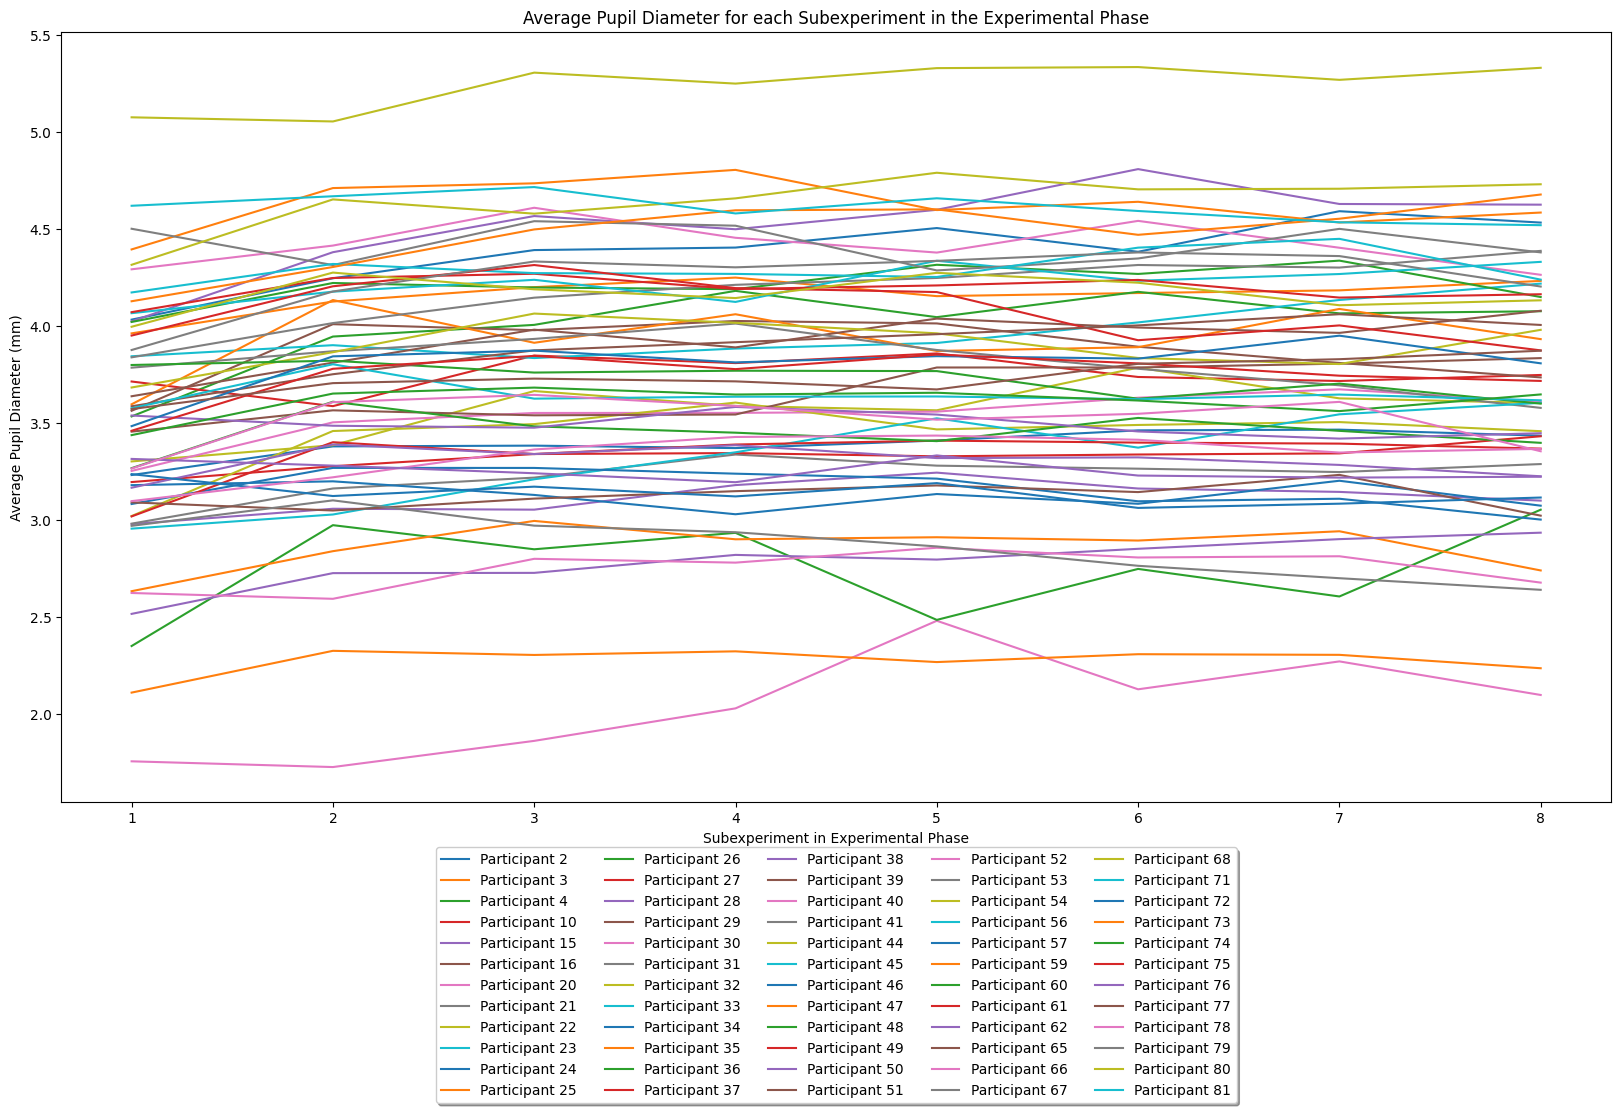

In [30]:
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(20, 10))

# Sort the participants in chronological order
sorted_participants = sorted(eye_tracking_data_per_subexperiment.items(), key=lambda x: x[0]) #TODO

# Loop over each participant
for participant_number, participant_data in sorted_participants:
    # Extract the average left and right pupil diameters for each subexperiment
    avg_LeftPupilDiameter = [participant_data[f'SubExperiment{i}']['avg_LeftPupilDiameter'] for i in range(1, 9)]
    avg_RightPupilDiameter = [participant_data[f'SubExperiment{i}']['avg_RightPupilDiameter'] for i in range(1, 9)]
    
    # Calculate the average pupil diameter for both eyes
    avg_PupilDiameter = [(left + right) / 2 for left, right in zip(avg_LeftPupilDiameter, avg_RightPupilDiameter)]
    
    # Plot the data
    plt.plot(range(1, 9), avg_PupilDiameter, label=f'Participant {participant_number}')

# Add labels and title
plt.xlabel('Subexperiment in Experimental Phase')
plt.ylabel('Average Pupil Diameter (mm)')
plt.title('Average Pupil Diameter for each Subexperiment in the Experimental Phase')

# Place the legend below the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)

# Show the plot
plt.show()

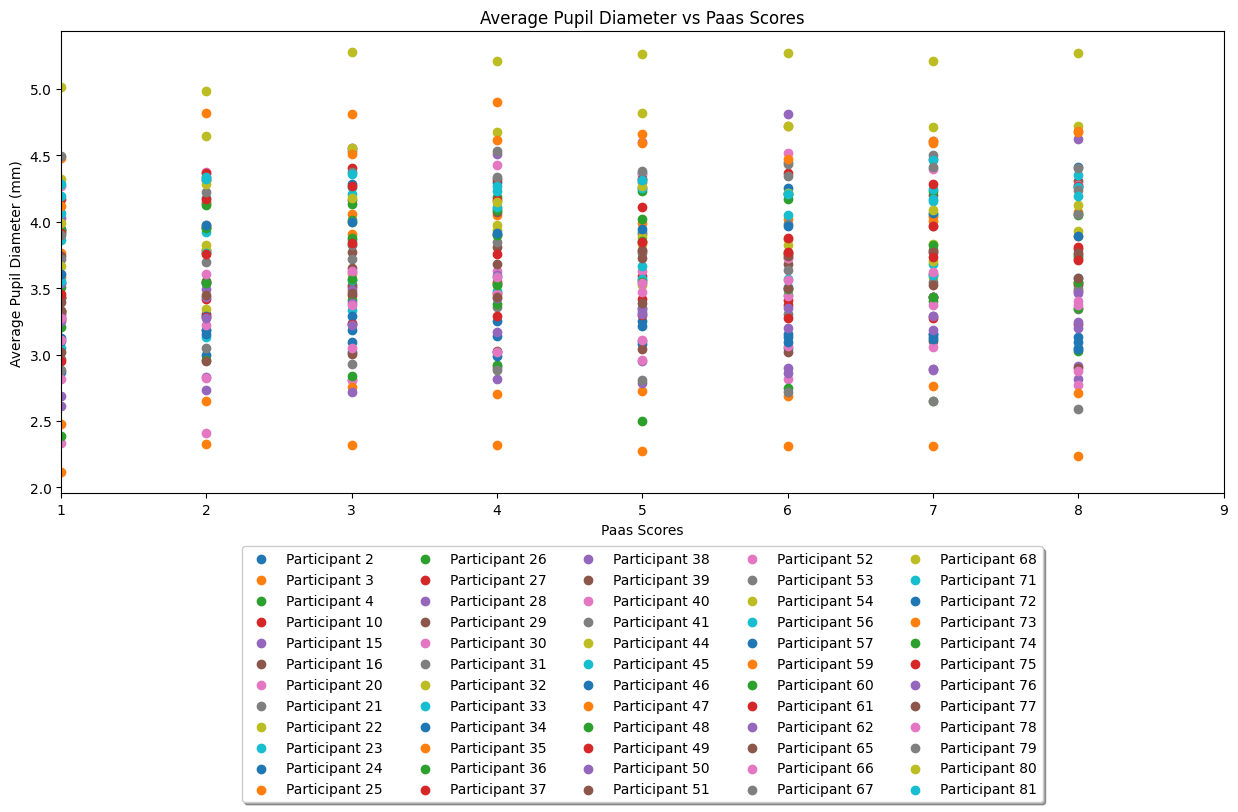

In [31]:
# Set the size of the plot
plt.figure(figsize=(15, 6))

# Loop over each participant
for participant_number, participant_data in sorted_participants:
    # Extract the average pupil diameter for each subexperiment
    avg_PupilDiameter = [participant_data[f'SubExperiment{i}']['avg_LeftPupilDiameter'] for i in range(1, 9)]
    
    # Plot the data
    plt.scatter(range(1, 9), avg_PupilDiameter, label=f'Participant {participant_number}')

# Add labels and title
plt.xlabel('Paas Scores')
plt.ylabel('Average Pupil Diameter (mm)')
plt.title('Average Pupil Diameter vs Paas Scores')

# Set the x-axis limits
plt.xlim(1, 9)

# Place the legend at the bottom
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)

# Show the plot
plt.show()


### Plotting Eye Gaze

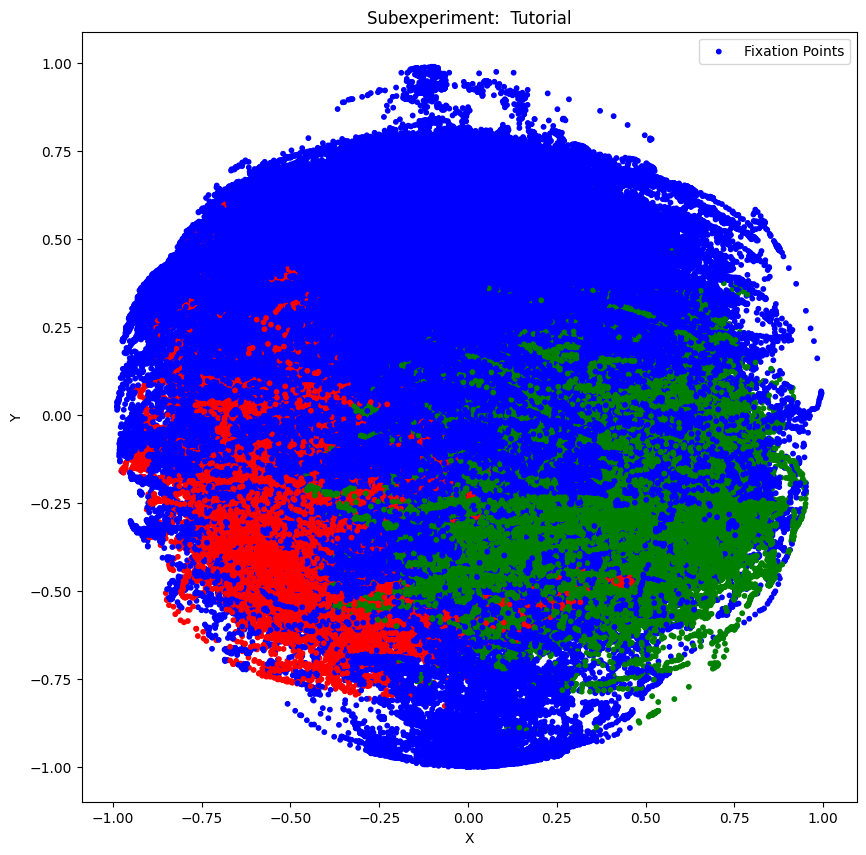

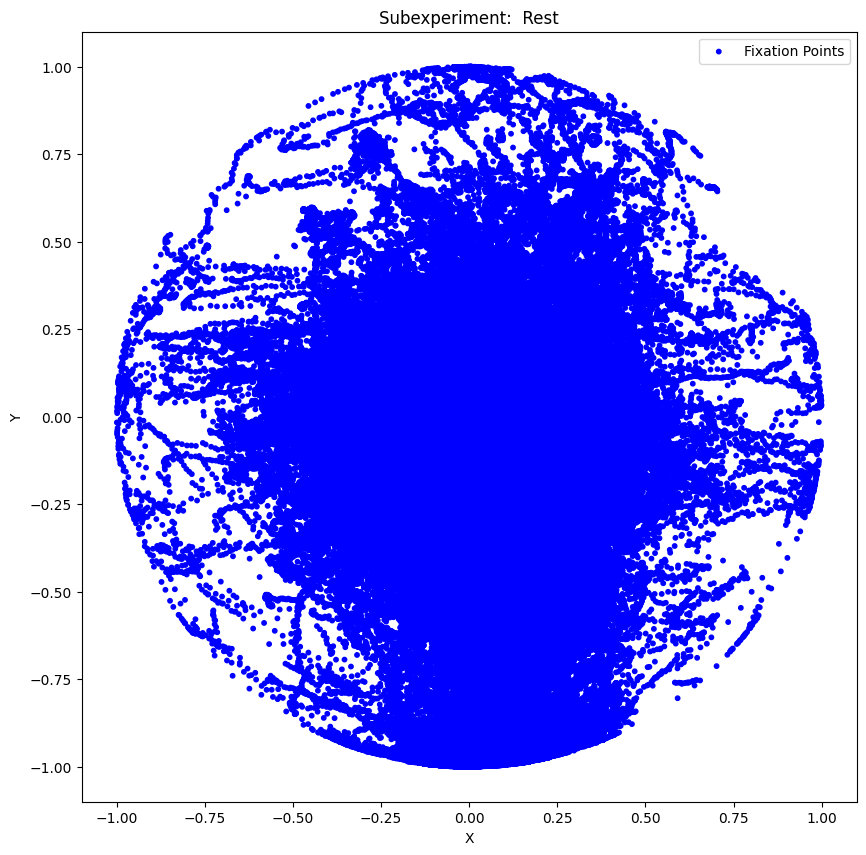

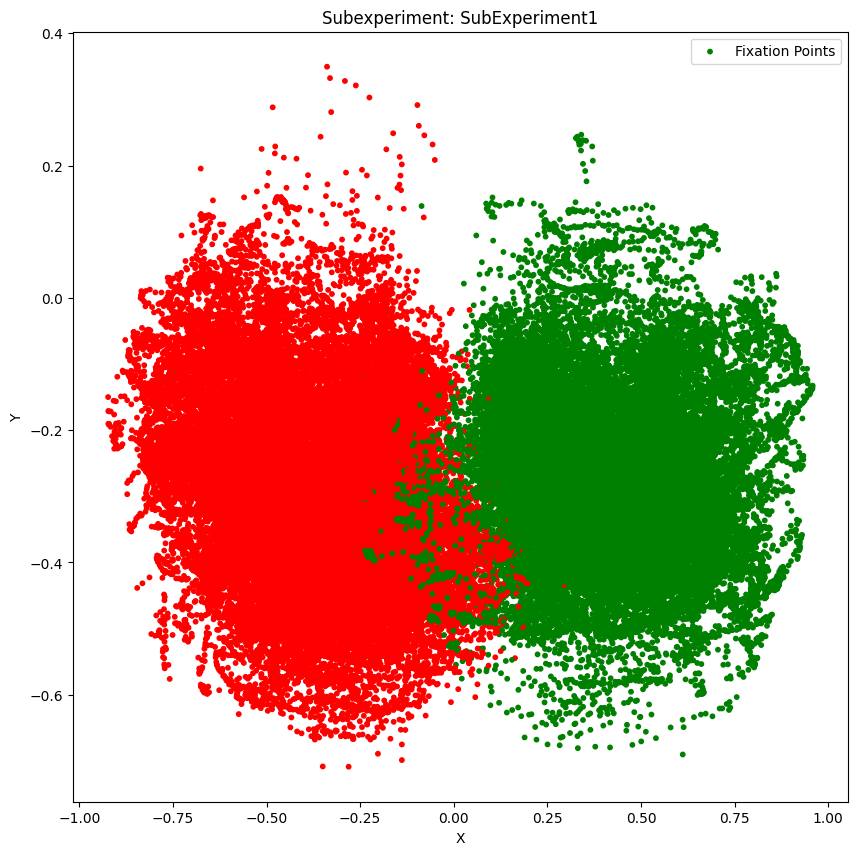

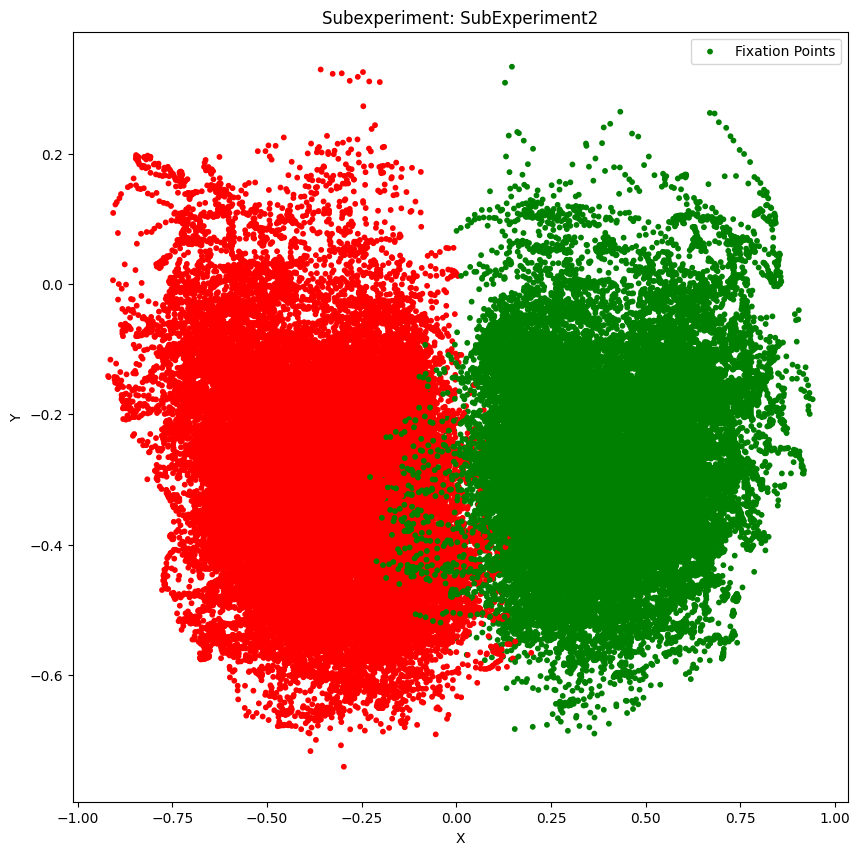

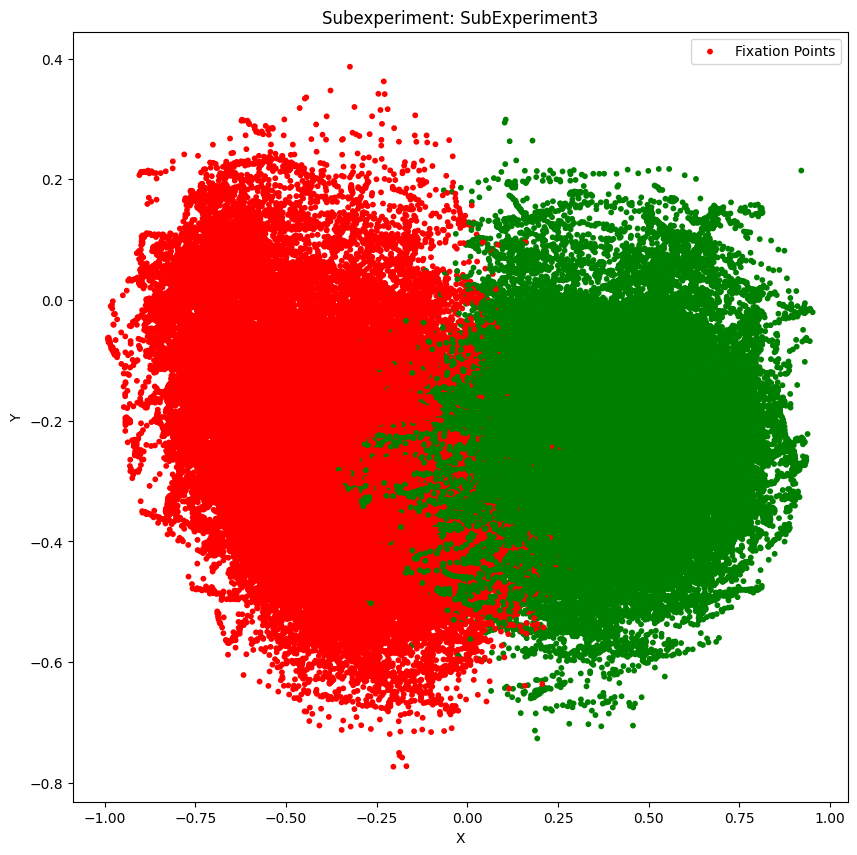

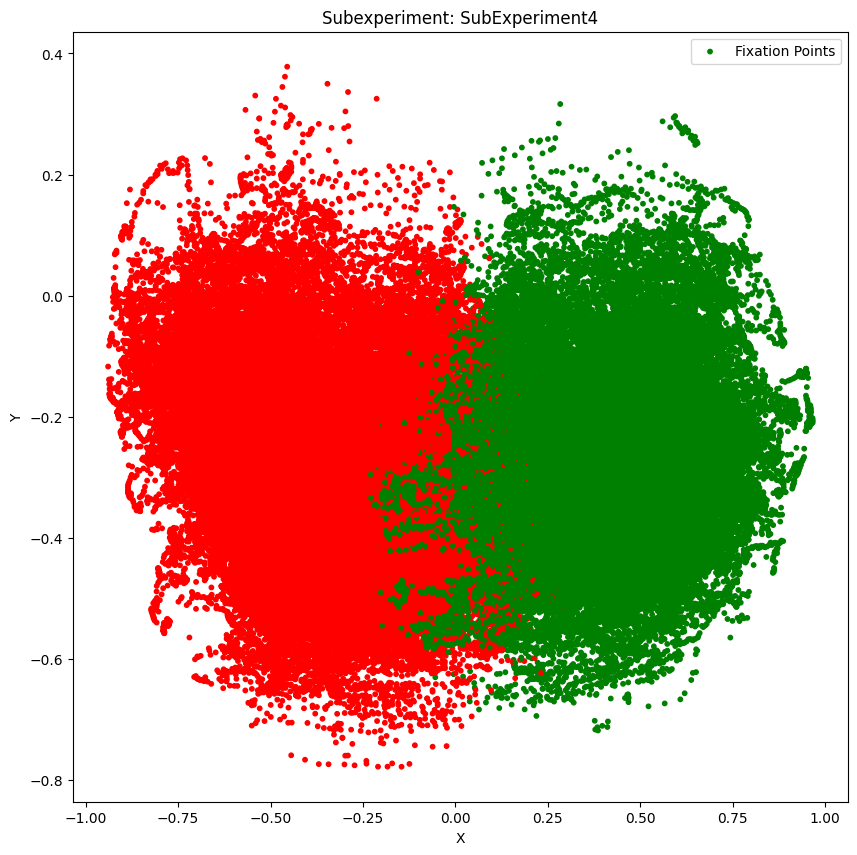

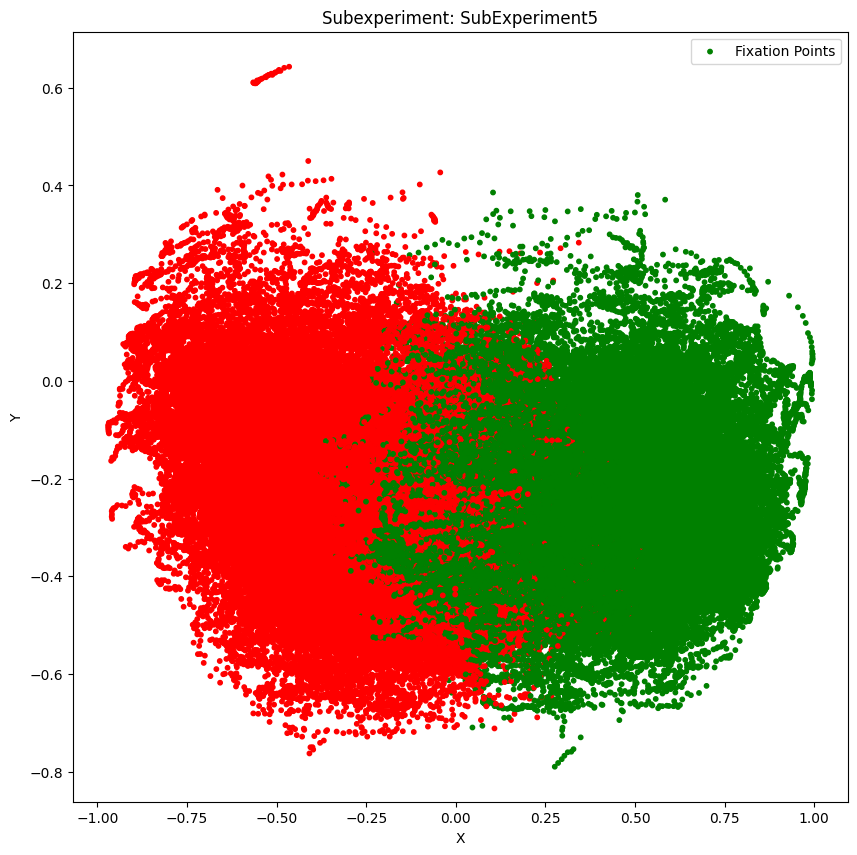

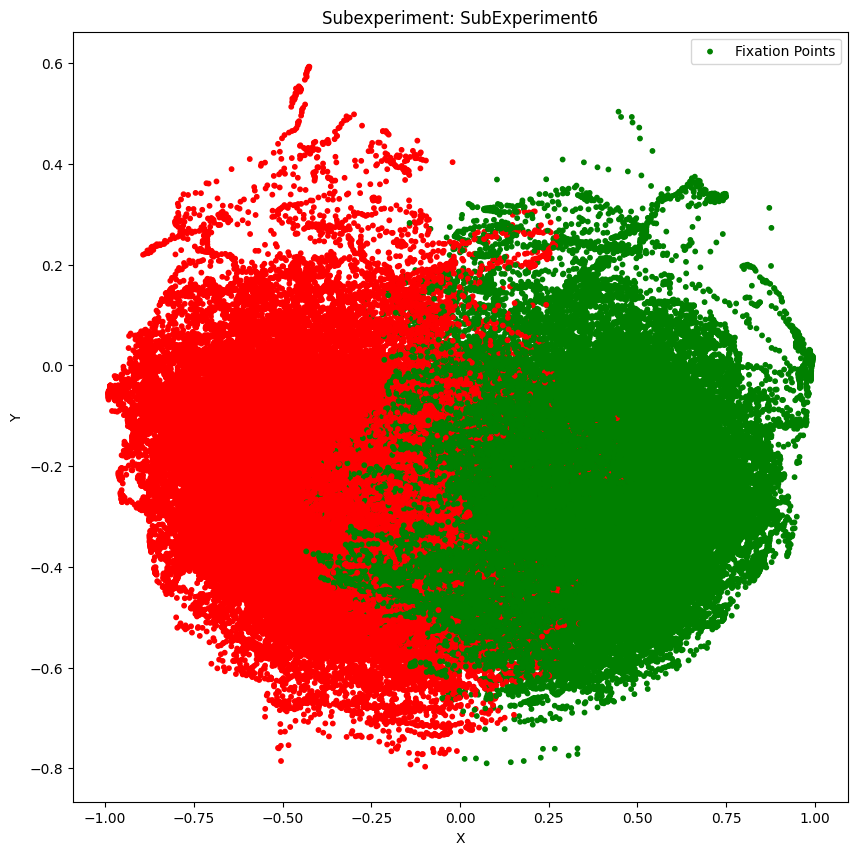

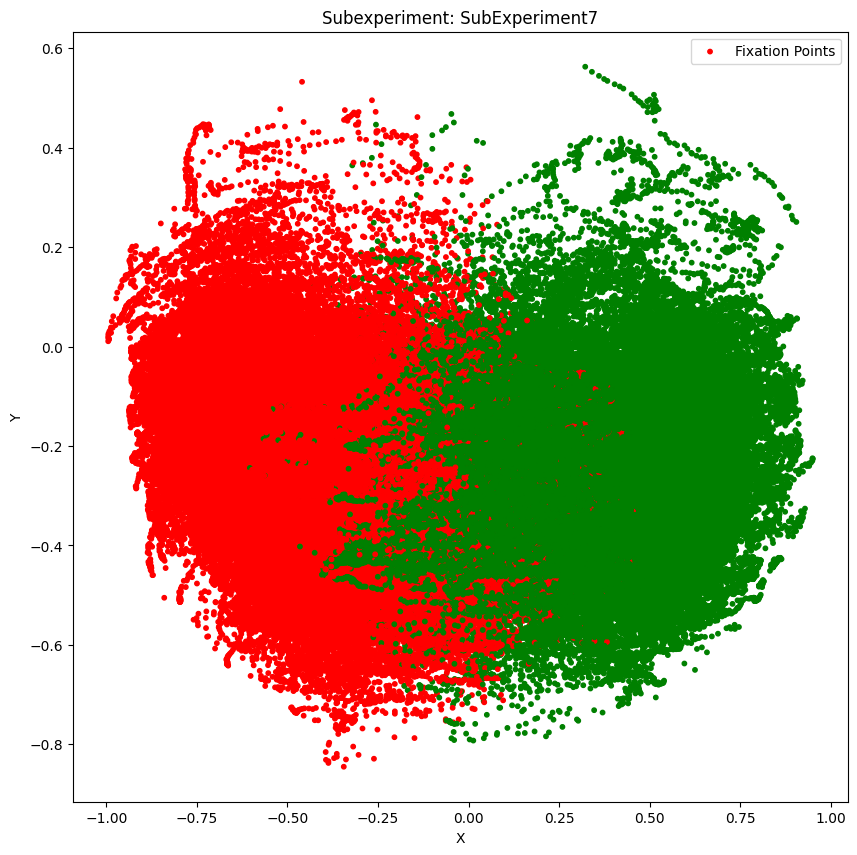

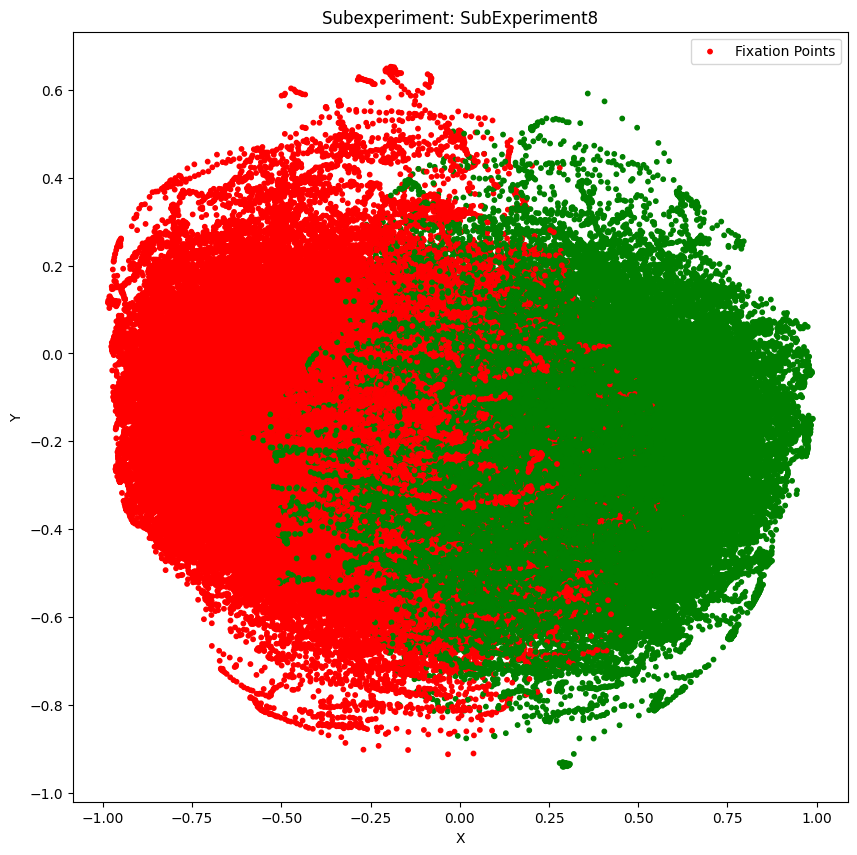

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Concatenate all the dataframes in et_dfs
etdf = pd.concat(et_dfs)

# Create a color column
conditions = [
    (etdf[' GazedObjectName'].str.strip() == '_Left'),
    (etdf[' GazedObjectName'].str.strip() == '_Right')]
choices = ['red', 'green']
etdf['color'] = np.select(conditions, choices, default='blue')

# List of subexperiments
subexperiments = [' Tutorial', ' Rest'] + [f'SubExperiment{i}' for i in range(1, 9)] #TODO

etdf[' CurrentTrial'] = pd.to_numeric(etdf[' CurrentTrial'], errors='coerce')

# Create a plot for each subexperiment
for subexperiment in subexperiments:
    if subexperiment in [' Tutorial', ' Rest']:
        # Group the rows that have Tutorial or Rest in their ActivePhase column
        sub_etdf = etdf[etdf['ActivePhase'] == subexperiment]
    else:
        # Group the rows that have Experimental in their ActivePhase column and the correct CurrentTrial numbers
        subexperiment_number = int(subexperiment[-1])  # Extract the number from the subexperiment name
        sub_etdf = etdf[(etdf['ActivePhase'] == ' Experimental') & (etdf[' CurrentTrial'].between((subexperiment_number - 1) * 4, subexperiment_number * 4 - 1))]
        
        # Filter the DataFrame to only include rows where color is 'red' or 'green'
        sub_etdf = sub_etdf[sub_etdf['color'].isin(['red', 'green'])]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    # Plot Fixation Points
    ax.scatter(sub_etdf[' FixationPointX'], sub_etdf[' FixationPointY'], color=sub_etdf['color'], label='Fixation Points', s=10)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Subexperiment: {subexperiment}')
    ax.legend()

    plt.show()

### Blink Analysis

In [33]:
"""#OLD CODE GOOD

# Initialize a dictionary to store the blink timestamps and duration for each participant
blink_info_per_subexperiment = {}

for idx in participants_indexes:
    # Fetch the dataframe for the participant
    etdf = et_dfs[idx]
    
    # Initialize a dictionary to store the blink timestamps and duration for each subexperiment
    participant_blink_info = {}

    # Calculate the blink timestamps and duration for the 'Rest' phase first
    subexperiment = ' Rest'
    sub_etdf = etdf[etdf['ActivePhase'] == subexperiment]

    # Limit the analysis to the first 30 seconds (assuming the data is sampled at 90Hz)
    sub_etdf = sub_etdf.iloc[450:3150]

    # Initialize a counter, two flags, and two timestamps
    blink_count = 0
    previous_row_was_zero = False
    two_previous_rows_were_zero = False
    three_previous_rows_were_zero = False
    blink_start_time = None
    blink_end_time = None

    # Initialize a dictionary to store the blink timestamps and duration
    blink_info = {}

    # Iterate over the DataFrame rows
    for _, row in sub_etdf.iterrows():
        # Check if the current row has 0 for LeftGazeX, LeftGazeY, LeftGazeZ
        current_row_is_zero = (row['LeftGazeX'] == 0) and (row[' LeftGazeY'] == 0) and (row[' LeftGazeZ'] == 0)

        # If the last three rows were zero and the current row is not zero, increment the counter and calculate the blink duration
        if three_previous_rows_were_zero and not current_row_is_zero:
            blink_end_time = pd.to_datetime(row['Timestamp'], infer_datetime_format=True, errors='coerce')  # Convert the timestamp string to a datetime object
            blink_duration = (blink_end_time - blink_start_time).total_seconds()
            blink_info[f'blink_{blink_count}'] = {'start_time': blink_start_time, 'end_time': blink_end_time, 'duration': blink_duration}
            blink_count += 1

        # If the current row is zero and the last three rows were not zero, record the start time of the blink
        elif current_row_is_zero and not previous_row_was_zero:
            blink_start_time = pd.to_datetime(row['Timestamp'], infer_datetime_format=True, errors='coerce')  # Convert the timestamp string to a datetime object

        # Update the flags
        three_previous_rows_were_zero = two_previous_rows_were_zero and previous_row_was_zero and current_row_is_zero
        two_previous_rows_were_zero = previous_row_was_zero and current_row_is_zero
        previous_row_was_zero = current_row_is_zero

    # Calculate the blink rate
    blink_rate = blink_count *2  # Total blinks / 30 seconds

    # Add the blink info, blink count, and blink rate to the participant's data
    participant_blink_info[subexperiment] = {'blink_info': blink_info, 'blink_count': blink_count, 'blink_rate': blink_rate}

    # Add the participant's data to the main dictionary
    blink_info_per_subexperiment[idx] = participant_blink_info
    
blink_info_per_subexperiment[2]"""""

"#OLD CODE GOOD\n\n# Initialize a dictionary to store the blink timestamps and duration for each participant\nblink_info_per_subexperiment = {}\n\nfor idx in participants_indexes:\n    # Fetch the dataframe for the participant\n    etdf = et_dfs[idx]\n    \n    # Initialize a dictionary to store the blink timestamps and duration for each subexperiment\n    participant_blink_info = {}\n\n    # Calculate the blink timestamps and duration for the 'Rest' phase first\n    subexperiment = ' Rest'\n    sub_etdf = etdf[etdf['ActivePhase'] == subexperiment]\n\n    # Limit the analysis to the first 30 seconds (assuming the data is sampled at 90Hz)\n    sub_etdf = sub_etdf.iloc[450:3150]\n\n    # Initialize a counter, two flags, and two timestamps\n    blink_count = 0\n    previous_row_was_zero = False\n    two_previous_rows_were_zero = False\n    three_previous_rows_were_zero = False\n    blink_start_time = None\n    blink_end_time = None\n\n    # Initialize a dictionary to store the blink times

In [34]:
"""# OLD CODE GOOD

# Initialize a dictionary to store the blink timestamps and duration for each participant
blink_info_per_subexperiment = {}

for idx in participants_indexes:
    # Fetch the dataframe for the participant
    etdf = et_dfs[idx]
    
    # Initialize a dictionary to store the blink timestamps and duration for each subexperiment
    participant_blink_info = {}

    # Calculate the blink timestamps and duration for each subexperiment
    for subexperiment in [' Rest', ' Tutorial'] + [f'SubExperiment{i}' for i in range(1, 9)]:
        if subexperiment in [' Rest', ' Tutorial']:
            # Group the rows that have Tutorial or Rest in their ActivePhase column
            sub_etdf = etdf[etdf['ActivePhase'] == subexperiment]
        else:
            # Group the rows that have Experimental in their ActivePhase column and the correct CurrentTrial numbers
            subexperiment_number = int(subexperiment[-1]) 
            sub_etdf = etdf[(etdf['ActivePhase'] == ' Experimental') & (etdf[' CurrentTrial'].between((subexperiment_number - 1) * 4, subexperiment_number * 4 - 1))]

        # Initialize a counter, two flags, and two timestamps
        blink_count = 0
        previous_row_was_zero = False
        two_previous_rows_were_zero = False
        three_previous_rows_were_zero = False
        blink_start_time = None
        blink_end_time = None

        # Initialize a dictionary to store the blink timestamps and duration
        blink_info = {}

        # Iterate over the DataFrame rows
        for _, row in sub_etdf.iterrows():
            # Check if the current row has 0 for LeftGazeX, LeftGazeY, LeftGazeZ
            current_row_is_zero = (row['LeftGazeX'] == 0) and (row[' LeftGazeY'] == 0) and (row[' LeftGazeZ'] == 0)

            # If the last three rows were zero and the current row is not zero, increment the counter and calculate the blink duration
            if three_previous_rows_were_zero and not current_row_is_zero:
                blink_end_time = pd.to_datetime(row['Timestamp'], infer_datetime_format=True, errors='coerce')  # Convert the timestamp string to a datetime object
                blink_duration = (blink_end_time - blink_start_time).total_seconds()
                blink_info[f'blink_{blink_count}'] = {'start_time': blink_start_time, 'end_time': blink_end_time, 'duration': blink_duration}
                blink_count += 1

            # If the current row is zero and the last three rows were not zero, record the start time of the blink
            elif current_row_is_zero and not previous_row_was_zero:
                blink_start_time = pd.to_datetime(row['Timestamp'], infer_datetime_format=True, errors='coerce')  # Convert the timestamp string to a datetime object

            # Update the flags
            three_previous_rows_were_zero = two_previous_rows_were_zero and previous_row_was_zero and current_row_is_zero
            two_previous_rows_were_zero = previous_row_was_zero and current_row_is_zero
            previous_row_was_zero = current_row_is_zero

        # Calculate the blink rate
        if subexperiment == ' Tutorial':
            blink_rate = blink_count / activeTime_data[idx]['Tutorial'][0]
        elif subexperiment == ' Rest':
            blink_rate = blink_count / activeTime_data[idx]['Rest'][0]
        else:
            blink_rate = blink_count / experiment_set_times_dict[idx][subexperiment_number - 1] if subexperiment_number > 0 else 0

        # Add the blink info, blink count, and blink rate to the participant's data
        participant_blink_info[subexperiment] = {'blink_info': blink_info, 'blink_count': blink_count, 'blink_rate': blink_rate}

    # Normalize the blink rate for each subexperiment with the blink rate from the rest phase
    rest_blink_rate = participant_blink_info[' Rest']['blink_rate']
    for subexperiment in participant_blink_info:
        if subexperiment != ' Rest':
            participant_blink_info[subexperiment]['normalized_blink_rate'] = ((participant_blink_info[subexperiment]['blink_rate'] - rest_blink_rate) / rest_blink_rate) * 100

    # Normalize the blink rate for each subexperiment with the blink rate from the first subexperiment
    #first_subexperiment_blink_rate = participant_blink_info['SubExperiment1']['blink_rate']
    #for subexperiment in participant_blink_info:
        #if subexperiment == 'SubExperiment1':
            #participant_blink_info[subexperiment]['normalized_blink_rate'] = 0
        #else:
            #participant_blink_info[subexperiment]['normalized_blink_rate'] = ((participant_blink_info[subexperiment]['blink_rate'] - first_subexperiment_blink_rate) / first_subexperiment_blink_rate) * 100

    # Add the participant's data to the main dictionary
    if idx in blink_info_per_subexperiment:
        blink_info_per_subexperiment[idx].update(participant_blink_info)
    else:
        blink_info_per_subexperiment[idx] = participant_blink_info"""

"# OLD CODE GOOD\n\n# Initialize a dictionary to store the blink timestamps and duration for each participant\nblink_info_per_subexperiment = {}\n\nfor idx in participants_indexes:\n    # Fetch the dataframe for the participant\n    etdf = et_dfs[idx]\n    \n    # Initialize a dictionary to store the blink timestamps and duration for each subexperiment\n    participant_blink_info = {}\n\n    # Calculate the blink timestamps and duration for each subexperiment\n    for subexperiment in [' Rest', ' Tutorial'] + [f'SubExperiment{i}' for i in range(1, 9)]:\n        if subexperiment in [' Rest', ' Tutorial']:\n            # Group the rows that have Tutorial or Rest in their ActivePhase column\n            sub_etdf = etdf[etdf['ActivePhase'] == subexperiment]\n        else:\n            # Group the rows that have Experimental in their ActivePhase column and the correct CurrentTrial numbers\n            subexperiment_number = int(subexperiment[-1]) \n            sub_etdf = etdf[(etdf['ActiveP

In [35]:
#NEW CODE FULL

import numpy as np
import pandas as pd

# Initialize a dictionary to store the blink timestamps and duration for each participant
blink_info_per_subexperiment = {}

for idx in participants_indexes:
    # Fetch the dataframe for the participant
    etdf = et_dfs[idx]
    
    # Initialize a dictionary to store the blink timestamps and duration for each subexperiment
    participant_blink_info = {}

    # Calculate the blink timestamps and duration for each subexperiment
    for subexperiment in [' Rest', ' Tutorial'] + [f'SubExperiment{i}' for i in range(1, 9)]:
        if subexperiment == ' Rest':
            # Group the rows that have Rest in their ActivePhase column
            sub_etdf = etdf[etdf['ActivePhase'] == subexperiment]

            # Limit the analysis to the first 30 seconds (assuming the data is sampled at 90Hz)
            sub_etdf = sub_etdf.iloc[450:3150]

            # Initialize a counter, two flags, and two timestamps
            blink_count = 0
            previous_row_was_zero = False
            two_previous_rows_were_zero = False
            three_previous_rows_were_zero = False
            blink_start_time = None
            blink_end_time = None

            # Initialize a dictionary to store the blink timestamps and duration
            blink_info = {}

            # Iterate over the DataFrame rows
            for _, row in sub_etdf.iterrows():
                # Check if the current row has 0 for LeftGazeX, LeftGazeY, LeftGazeZ
                current_row_is_zero = (row['LeftGazeX'] == 0) and (row[' LeftGazeY'] == 0) and (row[' LeftGazeZ'] == 0)

                # If the last three rows were zero and the current row is not zero, increment the counter and calculate the blink duration
                if three_previous_rows_were_zero and not current_row_is_zero:
                    blink_end_time = pd.to_datetime(row['Timestamp'], infer_datetime_format=True, errors='coerce')  # Convert the timestamp string to a datetime object
                    blink_duration = (blink_end_time - blink_start_time).total_seconds()
                    blink_info[f'blink_{blink_count}'] = {'start_time': blink_start_time, 'end_time': blink_end_time, 'duration': blink_duration}
                    blink_count += 1

                # If the current row is zero and the last three rows were not zero, record the start time of the blink
                elif current_row_is_zero and not previous_row_was_zero:
                    blink_start_time = pd.to_datetime(row['Timestamp'], infer_datetime_format=True, errors='coerce')  # Convert the timestamp string to a datetime object

                # Update the flags
                three_previous_rows_were_zero = two_previous_rows_were_zero and previous_row_was_zero and current_row_is_zero
                two_previous_rows_were_zero = previous_row_was_zero and current_row_is_zero
                previous_row_was_zero = current_row_is_zero

            # Calculate the blink rate for the current window
            rest_blink_rate = (blink_count / 30) * 60

            # Add the blink info, blink count, and median blink rate to the participant's data
            participant_blink_info[subexperiment] = {'blink_info': blink_info, 'blink_count': blink_count, 'rest_blink_rate': rest_blink_rate}

        else:
            # Group the rows that have Tutorial or Experimental in their ActivePhase column
            if subexperiment == ' Tutorial':
                sub_etdf = etdf[etdf['ActivePhase'] == subexperiment]
            else:
                # Group the rows that have Experimental in their ActivePhase column and the correct CurrentTrial numbers
                subexperiment_number = int(subexperiment[-1]) 
                sub_etdf = etdf[(etdf['ActivePhase'] == ' Experimental') & (etdf[' CurrentTrial'].between((subexperiment_number - 1) * 4, subexperiment_number * 4 - 1))]

            # Initialize a counter, two flags, and two timestamps
            blink_count = 0
            previous_row_was_zero = False
            two_previous_rows_were_zero = False
            three_previous_rows_were_zero = False
            blink_start_time = None
            blink_end_time = None

            # Initialize a dictionary to store the blink timestamps and duration
            blink_info = {}

            # Iterate over the DataFrame rows
            for _, row in sub_etdf.iterrows():
                # Check if the current row has 0 for LeftGazeX, LeftGazeY, LeftGazeZ
                current_row_is_zero = (row['LeftGazeX'] == 0) and (row[' LeftGazeY'] == 0) and (row[' LeftGazeZ'] == 0)

                # If the last three rows were zero and the current row is not zero, increment the counter and calculate the blink duration
                if three_previous_rows_were_zero and not current_row_is_zero:
                    blink_end_time = pd.to_datetime(row['Timestamp'], infer_datetime_format=True, errors='coerce')  # Convert the timestamp string to a datetime object
                    blink_duration = (blink_end_time - blink_start_time).total_seconds()
                    blink_info[f'blink_{blink_count}'] = {'start_time': blink_start_time, 'end_time': blink_end_time, 'duration': blink_duration}
                    blink_count += 1

                # If the current row is zero and the last three rows were not zero, record the start time of the blink
                elif current_row_is_zero and not previous_row_was_zero:
                    blink_start_time = pd.to_datetime(row['Timestamp'], infer_datetime_format=True, errors='coerce')  # Convert the timestamp string to a datetime object

                # Update the flags
                three_previous_rows_were_zero = two_previous_rows_were_zero and previous_row_was_zero and current_row_is_zero
                two_previous_rows_were_zero = previous_row_was_zero and current_row_is_zero
                previous_row_was_zero = current_row_is_zero

            # Calculate the blink rate
            if subexperiment == ' Tutorial':
                blink_rate = (blink_count / activeTime_data[idx]['Tutorial'][0]) * 60
            #elif subexperiment == ' Rest':
                #blink_rate = blink_count / (activeTime_data[idx][' Rest'][0] * 60)
            else:
                blink_rate = (blink_count / experiment_set_times_dict[idx][subexperiment_number - 1] if subexperiment_number > 0 else 0) * 60

            # Add the blink info, blink count, and blink rate to the participant's data
            participant_blink_info[subexperiment] = {'blink_info': blink_info, 'blink_count': blink_count, 'blink_rate': blink_rate}

        # Normalize the blink rate for each subexperiment with the blink rate from the rest phase
        rest_blink_rate = participant_blink_info[' Rest']['rest_blink_rate']
        for subexperiment in participant_blink_info:
            if subexperiment != ' Rest':
                participant_blink_info[subexperiment]['normalized_blink_rate'] = ((participant_blink_info[subexperiment]['blink_rate'] - rest_blink_rate) / rest_blink_rate) * 100

        # Normalize the blink rate for each subexperiment with the blink rate from the first subexperiment
        #first_subexperiment_blink_rate = participant_blink_info['SubExperiment1']['blink_rate']
        #for subexperiment in participant_blink_info:
            #if subexperiment == 'SubExperiment1':
                #participant_blink_info[subexperiment]['normalized_blink_rate'] = 0
            #else:
                #participant_blink_info[subexperiment]['normalized_blink_rate'] = ((participant_blink_info[subexperiment]['blink_rate'] - first_subexperiment_blink_rate) / first_subexperiment_blink_rate) * 100

        # Add the participant's data to the main dictionary
        if idx in blink_info_per_subexperiment:
            blink_info_per_subexperiment[idx].update(participant_blink_info)
        else:
            blink_info_per_subexperiment[idx] = participant_blink_info

In [36]:
"""blink_info_per_subexperiment[10][' Rest']"""

"blink_info_per_subexperiment[10][' Rest']"

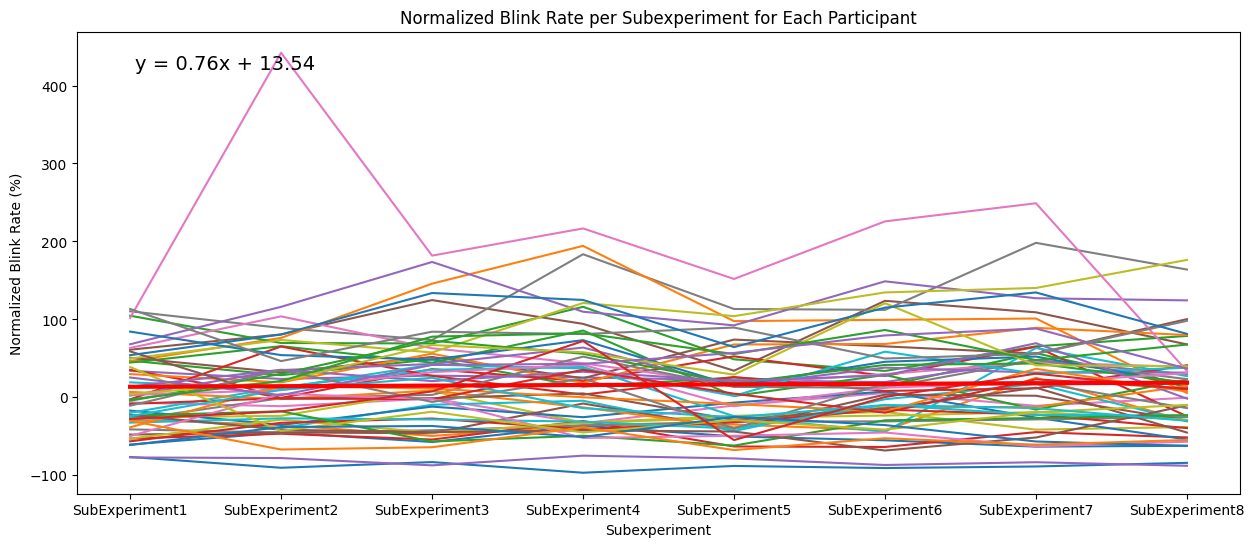

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Create a list of subexperiments
subexperiments = [f'SubExperiment{i}' for i in range(1, 9)]

# Create a new figure
plt.figure(figsize=(15, 6))

# Calculate the normalized blink rates for all participants
all_normalized_blink_rates = [blink_info_per_subexperiment[idx][subexperiment]['normalized_blink_rate'] for idx in blink_info_per_subexperiment for subexperiment in subexperiments]

# Calculate the IQR of the normalized blink rates
Q1 = np.percentile(all_normalized_blink_rates, 25)
Q3 = np.percentile(all_normalized_blink_rates, 75)
IQR = Q3 - Q1

# Define the upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Prepare lists for the line of best fit
x_values = []
y_values = []

# Plot the normalized blink rate for each participant
for idx in blink_info_per_subexperiment:
    participant_blink_info = blink_info_per_subexperiment[idx]
    normalized_blink_rates = [participant_blink_info[subexperiment]['normalized_blink_rate'] for subexperiment in subexperiments]

    # Calculate the participant's average normalized blink rate
    avg_normalized_blink_rate = np.mean(normalized_blink_rates)

    # Only plot the participant's data if they are not an outlier
    if avg_normalized_blink_rate >= lower_bound and avg_normalized_blink_rate <= upper_bound:
        plt.plot(subexperiments, normalized_blink_rates, label=f'Participant {idx}')
        x_values.extend(range(len(subexperiments)))
        y_values.extend(normalized_blink_rates)

# Calculate the coefficients of the line of best fit
coefficients = np.polyfit(x_values, y_values, 1)  # Fit a line to the data
polynomial = np.poly1d(coefficients)  # Create a polynomial object
x_fit = np.linspace(0, len(subexperiments) - 1, 100)  # x-coordinates for the line of best fit
y_fit = polynomial(x_fit)  # y-coordinates for the line of best fit

# Plot the line of best fit
plt.plot(x_fit, y_fit, 'r-', linewidth=3, label='Best fit')  # Plot the line of best fit in red and with a thickness of 3

# Display the equation of the line of best fit
plt.text(0.05, 0.95, f'y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')

# Add labels and a title
plt.xlabel('Subexperiment')
plt.ylabel('Normalized Blink Rate (%)')
plt.title('Normalized Blink Rate per Subexperiment for Each Participant')

# Show the plot
plt.show()

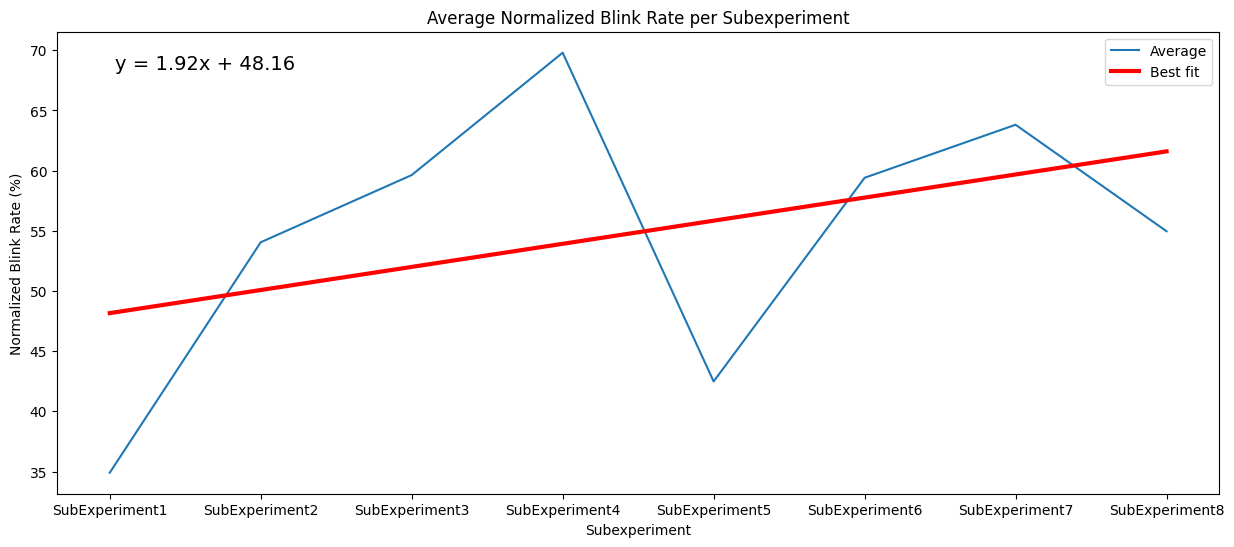

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Create a list of subexperiments
subexperiments = [f'SubExperiment{i}' for i in range(1, 9)]

# Create a new figure
plt.figure(figsize=(15, 6))

# Calculate the normalized blink rates for all participants in each subexperiment
all_normalized_blink_rates = [[blink_info_per_subexperiment[idx][subexperiment]['normalized_blink_rate'] for idx in blink_info_per_subexperiment] for subexperiment in subexperiments]

# Calculate the average normalized blink rate for each subexperiment
avg_normalized_blink_rates = [np.mean(normalized_blink_rates) for normalized_blink_rates in all_normalized_blink_rates]

# Plot the average normalized blink rate for each subexperiment
plt.plot(subexperiments, avg_normalized_blink_rates, label='Average')

# Calculate the coefficients of the line of best fit
x = np.arange(len(subexperiments))  # x-coordinates of the subexperiments
y = avg_normalized_blink_rates  # y-coordinates of the average normalized blink rates
coefficients = np.polyfit(x, y, 1)  # Fit a line to the data
polynomial = np.poly1d(coefficients)  # Create a polynomial object
x_fit = np.linspace(x[0], x[-1], 100)  # x-coordinates for the line of best fit
y_fit = polynomial(x_fit)  # y-coordinates for the line of best fit

# Plot the line of best fit
plt.plot(x_fit, y_fit, 'r-', linewidth=3, label='Best fit')  # Plot the line of best fit in red and with a thickness of 3

# Display the equation of the line of best fit
plt.text(0.05, 0.95, f'y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')

# Add labels and a title
plt.xlabel('Subexperiment')
plt.ylabel('Normalized Blink Rate (%)')
plt.title('Average Normalized Blink Rate per Subexperiment')

# Show the legend
plt.legend()

# Show the plot
plt.show()

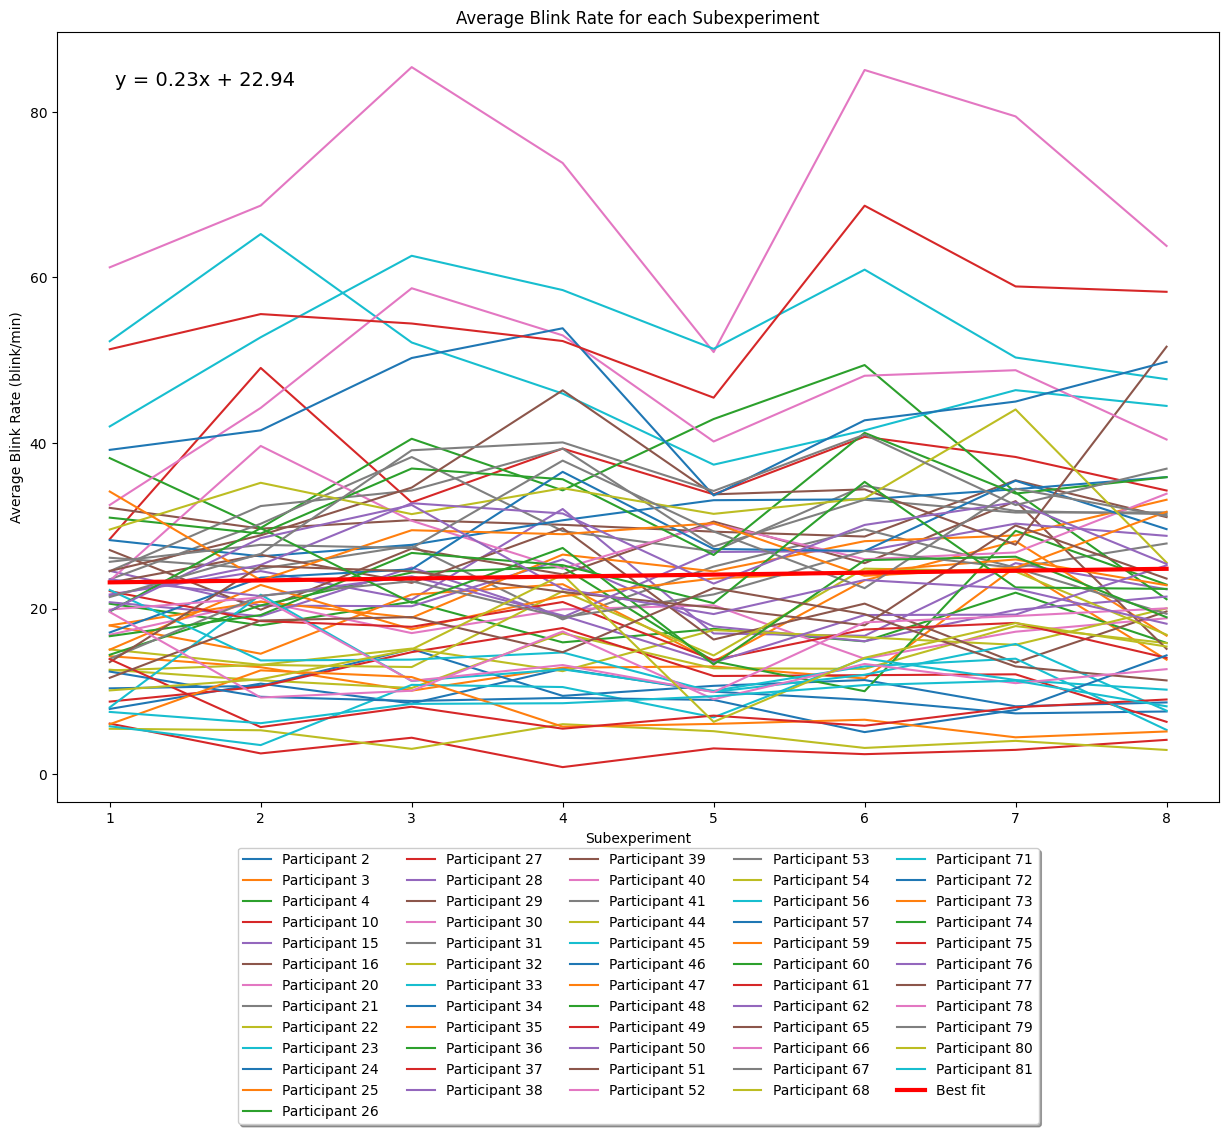

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Set the size of the plot
plt.figure(figsize=(15, 10))

# Prepare lists for the line of best fit
x_values = []
y_values = []

# Loop over each participant
for participant_number, participant_data in blink_info_per_subexperiment.items():
    # Extract the blink rate for each subexperiment
    blink_rate = [participant_data[f'SubExperiment{i}']['blink_rate'] for i in range(1, 9)]
    
    # Plot the data
    plt.plot(range(1, 9), blink_rate, label=f'Participant {participant_number}')
    
    # Add the data to the lists for the line of best fit
    x_values.extend(range(1, 9))
    y_values.extend(blink_rate)

# Calculate the coefficients of the line of best fit
coefficients = np.polyfit(x_values, y_values, 1)  # Fit a line to the data
polynomial = np.poly1d(coefficients)  # Create a polynomial object
x_fit = np.linspace(1, 8, 100)  # x-coordinates for the line of best fit
y_fit = polynomial(x_fit)  # y-coordinates for the line of best fit

# Plot the line of best fit
plt.plot(x_fit, y_fit, 'r-', linewidth=3, label='Best fit')  # Plot the line of best fit in red and with a thickness of 3

# Display the equation of the line of best fit
plt.text(0.05, 0.95, f'y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')

# Add labels and title
plt.xlabel('Subexperiment')
plt.ylabel('Average Blink Rate (blink/min)')
plt.title('Average Blink Rate for each Subexperiment')

# Place the legend below the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)

# Show the plot
plt.show()

In [40]:
# Initialize a dictionary to store the gaze velocity for each participant
gaze_velocity_per_subexperiment = {}

for idx in participants_indexes:
    # Fetch the dataframe for the participant
    etdf = et_dfs[idx]
    
    # Initialize a dictionary to store the gaze velocity for each subexperiment
    participant_gaze_velocity = {}

    # Calculate the gaze velocity for each subexperiment
    for subexperiment in [' Tutorial', ' Rest'] + [f'SubExperiment{i}' for i in range(1, 9)]:
        if subexperiment in [' Tutorial', ' Rest']:
            # Group the rows that have Tutorial or Rest in their ActivePhase column
            etdf_subexperiment = etdf[etdf['ActivePhase'] == subexperiment]
        else:
            # Group the rows that have Experimental in their ActivePhase column and the correct CurrentTrial numbers
            subexperiment_number = int(subexperiment[-1])  # Extract the number from the subexperiment name
            etdf_subexperiment = etdf[(etdf['ActivePhase'] == ' Experimental') & (etdf[' CurrentTrial'].between((subexperiment_number - 1) * 4, subexperiment_number * 4 - 1))]

        # Convert 'Timestamp' to datetime format and sort the dataframe by 'Timestamp'
        etdf_subexperiment = etdf_subexperiment.copy()
        etdf_subexperiment['Timestamp'] = pd.to_datetime(etdf_subexperiment['Timestamp'], infer_datetime_format=True, errors='coerce')
        sub_etdf_selectedcols = etdf_subexperiment[[' FixationPointX', ' FixationPointY', ' FixationPointZ', 'Timestamp']].sort_values('Timestamp')

        # Calculate the differences between consecutive points
        differences = sub_etdf_selectedcols.diff()
        sub_etdf_selectedcols['dx'] = differences[' FixationPointX']
        sub_etdf_selectedcols['dy'] = differences[' FixationPointY']
        sub_etdf_selectedcols['dz'] = differences[' FixationPointZ']
        sub_etdf_selectedcols['dt'] = differences['Timestamp'].dt.total_seconds()
        
        # Calculate the distance in 3D space
        sub_etdf_selectedcols['distance'] = np.sqrt(sub_etdf_selectedcols['dx']**2 + sub_etdf_selectedcols['dy']**2 + sub_etdf_selectedcols['dz']**2)

        # Calculate the gaze velocity for each column and store it in a dictionary
        subexperiment_gaze_velocity = {
            'gaze_velocity_X': sub_etdf_selectedcols['dx'] / sub_etdf_selectedcols['dt'],
            'gaze_velocity_Y': sub_etdf_selectedcols['dy'] / sub_etdf_selectedcols['dt'],
            'gaze_velocity_Z': sub_etdf_selectedcols['dz'] / sub_etdf_selectedcols['dt'],
            'gaze_velocity_total': sub_etdf_selectedcols['distance'] / sub_etdf_selectedcols['dt'],
            ' Timestamp': sub_etdf_selectedcols['Timestamp'],
            ' FixationPointX': sub_etdf_selectedcols[' FixationPointX'],
            ' FixationPointY': sub_etdf_selectedcols[' FixationPointY'],
            ' FixationPointZ': sub_etdf_selectedcols[' FixationPointZ'],
            ' dt': sub_etdf_selectedcols['dt']
        }

        # Add the gaze velocity data for the current subexperiment to the participant's dictionary
        participant_gaze_velocity[subexperiment] = subexperiment_gaze_velocity

    # Add the participant's gaze velocity data to the main dictionary
    gaze_velocity_per_subexperiment[idx] = participant_gaze_velocity

In [41]:
def process_sub_fixation(sub_fixation):
    false_count = 0
    for i in range(len(sub_fixation)):
        if not sub_fixation[i]:
            false_count += 1
        else:
            if false_count <= 2:
                for j in range(i - false_count, i):
                    sub_fixation[j] = True
            false_count = 0
    return sub_fixation

# Initialize a dictionary to store the fixations for each participant
fixations_per_subexperiment = {}

# Set the velocity threshold (in degrees per second)
velocity_threshold = 30

# Iterate over the gaze_velocity_per_subexperiment dictionary
for idx in participants_indexes:
    participant = gaze_velocity_per_subexperiment[idx]
    subexperiments = participant.items()
    # Initialize a dictionary to store the fixations for each subexperiment
    participant_fixations = {}

    # Calculate the fixations for each subexperiment
    for subexperiment, gaze_velocity in subexperiments:
        # Convert the gaze_velocity dictionary to a DataFrame
        gaze_data = pd.DataFrame(gaze_velocity)

        # Classify the data points as sub_fixations based on the velocity threshold and ensure that the gaze_velocity_total is not 0
        gaze_data['Sub_Fixation'] = (gaze_data['gaze_velocity_total'] < velocity_threshold) & (gaze_data['gaze_velocity_total'] != 0)
        gaze_data['Sub_Fixation'] = process_sub_fixation(gaze_data['Sub_Fixation'].tolist())
        gaze_data['dt'] = sub_etdf_selectedcols['dt']

        # Create a new column 'FixationGroup' that groups consecutive fixations together only when 'Sub_Fixation' is True
        gaze_data['FixationGroup'] = (gaze_data['Sub_Fixation'] & ~gaze_data['Sub_Fixation'].shift(1).fillna(False)).cumsum() * gaze_data['Sub_Fixation']

        # Count the number of consecutive True values in 'Sub_Fixation' for each 'FixationGroup'
        gaze_data['FixationCount'] = gaze_data.groupby('FixationGroup')['Sub_Fixation'].transform('sum')

        # Update the 'FixationGroup' column to be NaN where 'FixationCount' is less than 30
        gaze_data.loc[gaze_data['FixationCount'] < 30, 'FixationGroup'] = np.nan

        # Drop the 'FixationCount' column as it is no longer needed
        gaze_data = gaze_data.drop(columns=['FixationCount'])

        # Convert 'Timestamp' to datetime format
        gaze_data[' Timestamp'] = pd.to_datetime(gaze_data[' Timestamp'], infer_datetime_format=True, errors='coerce')

        # Sort the dataframe by 'Timestamp'
        gaze_data = gaze_data.sort_values(' Timestamp')

        # Calculate the time elapsed for each 'FixationGroup'
        gaze_data['TimeElapsed'] = gaze_data.groupby('FixationGroup')[' Timestamp'].transform(lambda x: x.max() - x.min())
        
        # Check if 'TimeElapsed' contains non-NaN values
        if gaze_data['TimeElapsed'].notna().any():
            # Convert 'TimeElapsed' to seconds
            gaze_data['TimeElapsed'] = gaze_data['TimeElapsed'].dt.total_seconds()

        # Calculate the first instance of 'TimeElapsed' for each 'FixationGroup'
        first_instance_time_elapsed = gaze_data.groupby('FixationGroup')['TimeElapsed'].first()

        # Calculate the sum of the first instance of 'TimeElapsed' for each 'FixationGroup'
        total_fixation_duration = first_instance_time_elapsed.sum()

        # Add the total fixation duration to the DataFrame as a new column 'TotalFixationDuration'
        gaze_data['TotalFixationDuration'] = total_fixation_duration

        # Calculate the average position of FixationPointX, FixationPointY, and FixationPointZ for each FixationGroup
        gaze_data['FixationPointX_avg'] = gaze_data.groupby('FixationGroup')[' FixationPointX'].transform('mean')
        gaze_data['FixationPointY_avg'] = gaze_data.groupby('FixationGroup')[' FixationPointY'].transform('mean')
        gaze_data['FixationPointZ_avg'] = gaze_data.groupby('FixationGroup')[' FixationPointZ'].transform('mean')
        
        # Add the FixationGroup data to the participant data
        participant_fixations[subexperiment] = gaze_data

    # Add the participant's data to the main dictionary
    fixations_per_subexperiment[idx] = participant_fixations
    
# Get the data for participant 2 and subexperiment 1
fixations_per_subexperiment[2]['SubExperiment2']

gaze_velocity_X  gaze_velocity_Y  gaze_velocity_Z  \
133820              NaN              NaN              NaN   
133821         0.106344         0.009117         0.009725   
133822         0.029638         0.060520         0.008215   
133823         0.043947         0.095936         0.012280   
133824         0.049151         0.049645         0.008718   
...                 ...              ...              ...   
143547        -0.157773         0.411155         0.020427   
143548        -0.039855         0.068918        -0.000236   
143549         0.245445        -0.893555        -0.075382   
143550        -0.134600         0.746717         0.081633   
143551         0.052630        -0.139040        -0.009460   

        gaze_velocity_total               Timestamp   FixationPointX  \
133820                  NaN 2023-12-07 12:55:41.026        -0.083891   
133821             0.107176 2023-12-07 12:55:41.038        -0.082615   
133822             0.067886 2023-12-07 12:55:41.051        -0.082230   
133823             0.106235 2023-12-07 12:55:41.061        -0.081791   
133824             0.070402 2023-12-07 12:55:41.072        -0.081250   
...                     ...                     ...              ...   
143547             0.440860 2023-12-07 12:57:35.157        -0.260856   
143548             0.079613 2023-12-07 12:57:35.168        -0.261294   
143549             0.929713 2023-12-07 12:57:35.179        -0.258594   
143550             0.763130 2023-12-07 12:57:35.191        -0.260209   
143551             0.148968 2023-12-07 12:57:35.201        -0.259683   

         FixationPointY   FixationPointZ     dt  Sub_Fixation  dt  \
133820        -0.094327         0.991989    NaN          True NaN   
133821        -0.094217         0.992106  0.012          True NaN   
133822        -0.093431         0.992213  0.013          True NaN   
133823        -0.092471         0.992336  0.010          True NaN   
133824        -0.091925         0.992432  0.011          True NaN   
...                 ...              ...    ...           ...  ..   
143547        -0.145849         0.954223  0.011          True NaN   
143548        -0.145091         0.954220  0.011          True NaN   
143549        -0.154920         0.953391  0.011          True NaN   
143550        -0.145959         0.954371  0.012          True NaN   
143551        -0.147350         0.954276  0.010          True NaN   

        FixationGroup  TimeElapsed  TotalFixationDuration  FixationPointX_avg  \
133820            1.0       14.500                111.202           -0.155147   
133821            1.0       14.500                111.202           -0.155147   
133822            1.0       14.500                111.202           -0.155147   
133823            1.0       14.500                111.202           -0.155147   
133824            1.0       14.500                111.202           -0.155147   
...               ...          ...                    ...                 ...   
143547           21.0        0.325                111.202           -0.277297   
143548           21.0        0.325                111.202           -0.277297   
143549           21.0        0.325                111.202           -0.277297   
143550           21.0        0.325                111.202           -0.277297   
143551           21.0        0.325                111.202           -0.277297   

        FixationPointY_avg  FixationPointZ_avg  
133820           -0.285539            0.887925  
133821           -0.285539            0.887925  
133822           -0.285539            0.887925  
133823           -0.285539            0.887925  
133824           -0.285539            0.887925  
...                    ...                 ...  
143547           -0.155752            0.947432  
143548           -0.155752            0.947432  
143549           -0.155752            0.947432  
143550           -0.155752            0.947432  
143551           -0.155752            0.947432  

[9340 rows x 17 col

In [42]:
# output the data to a csv file
fixations_per_subexperiment[2]['SubExperiment2'].to_csv('fixations.csv')

### fNIRS

In [43]:
import h5py
import pandas as pd
import os

# Directory where the .mat and .csv files are located
directory = "C:\\Users\\Mobile Workstation 3\\OneDrive - Queen's University\\Coding Scripts\\DryRunData\\june_preprocessed_files"

# Initialize an empty dictionary to store the data for each participant
fnirs_dictionary = {}

for participant_index in participants_indexes:
    # Construct the file paths for the .mat file and the .csv files
    mat_file_path = os.path.join(directory, f"fnirs{participant_index}_preprocessed.mat")
    data_csv_path = os.path.join(directory, f"fnirs{participant_index}_data_table.csv")
    events_csv_path = os.path.join(directory, f"fnirs{participant_index}_events_table.csv")
    
    # Check if the files exist before attempting to load them
    if not os.path.exists(mat_file_path) or not os.path.exists(data_csv_path) or not os.path.exists(events_csv_path):
        print(f"Files for participant {participant_index} are missing. Skipping...")
        continue
    
    # Load the .mat file using h5py
    with h5py.File(mat_file_path, 'r') as f:
        # Access the fnirs_mat struct first
        fnirs_mat = f['fnirs_mat']
        
        # Extract variables from the fnirs_mat struct
        sampling_rate = fnirs_mat['sampling_rate'][()][0][0]
        channel_positions_raw = fnirs_mat['channel_positions'][()]
        wavelengths = fnirs_mat['wavelengths'][()].flatten().tolist()
        dpf_value = fnirs_mat['dpf_val'][()][0][0]
    
    # Convert channel_positions to a list of (x, y, z) tuples
    channel_positions = [list(channel_positions_raw[:,i]) for i in range(channel_positions_raw.shape[1])]
    
    # Load the .csv files into pandas DataFrames
    data_table = pd.read_csv(data_csv_path)
    events_table = pd.read_csv(events_csv_path)
    
    # Storing the extracted data in the dictionary
    fnirs_dictionary[participant_index] = {
        'data_table': data_table,
        'sampling_rate': sampling_rate,
        'channel_positions': channel_positions,  # Updated to store as lists of 3
        'wavelengths': wavelengths,
        'dpf_value': dpf_value,
        'events_table': events_table
    }

Files for participant 40 are missing. Skipping...


In [79]:
fnirs_dictionary[2]['events_table']

time_secs                             stimulus
0        12.00          LSL ActivePhase Calibration
1        12.00                       LSL EndofStart
2        67.00                 LSL EndofCalibration
3        67.04             LSL ActivePhase Tutorial
4        70.92                  LSL TutorialSlide 0
..         ...                                  ...
240    2287.84  LSL N-back 2 trials Correct Non-res
241    2290.84  LSL N-back 2 trials Correct Non-res
242    2293.84           LSL Ending N-back 2 trials
243    2293.84  LSL N-back 2 trials Correct Non-res
244    2296.84              LSL Quitting experiment

[245 rows x 2 columns]

In [88]:
import pandas as pd

for participant_index in participants_indexes:
    if participant_index in fnirs_dictionary:
        fnirs_data_events_dataframe = fnirs_dictionary[participant_index]['data_table'].copy()
        fnirs_data_events_dataframe['stimulus1'] = None
        events_table = fnirs_dictionary[participant_index]['events_table']
        
        # Iterate over each row in events_table to find matching time_secs in fnirs_data_events_dataframe
        for _, event_row in events_table.iterrows():
            matching_rows = fnirs_data_events_dataframe['times_secs'] == event_row['time_secs']
            if matching_rows.any():
                if fnirs_data_events_dataframe.loc[matching_rows, 'stimulus1'].notnull().any():
                    new_row = fnirs_data_events_dataframe[matching_rows].iloc[0].copy()
                    new_row['stimulus1'] = event_row['stimulus']
                    fnirs_data_events_dataframe = fnirs_data_events_dataframe.append(new_row, ignore_index=True)
                else:
                    fnirs_data_events_dataframe.loc[matching_rows, 'stimulus1'] = event_row['stimulus']
            else:
                pass
        
        # Sort the DataFrame by 'times_secs' to maintain chronological order after appending
        fnirs_data_events_dataframe.sort_values(by='times_secs', inplace=True)
        
        # Populate all rows with repeats of the data entry in 'stimulus1' until the entry name changes
        last_valid_stimulus1 = None
        for index, row in fnirs_data_events_dataframe.iterrows():
            if pd.notnull(row['stimulus1']):
                last_valid_stimulus1 = row['stimulus1']
            elif last_valid_stimulus1 is not None:
                fnirs_data_events_dataframe.at[index, 'stimulus1'] = last_valid_stimulus1
        
        # Update the fnirs_dictionary with the modified DataFrame
        fnirs_dictionary[participant_index]['fnirs_data_events_dataframe'] = fnirs_data_events_dataframe
    else:
        print(f"No data found for participant {participant_index}. Skipping...")

print(fnirs_dictionary[2]['fnirs_data_events_dataframe'])

No data found for participant 40. Skipping...
       times_secs  S1-D1 [O2Hb]  S1-D1 [HHb]  S2-D1 [O2Hb]  S2-D1 [HHb]  \
0            0.00      0.000711    -0.000860      0.010396    -0.005200   
1            0.04      0.024931    -0.003083      0.169299     0.020832   
2            0.08      0.048787    -0.005273      0.325850     0.046468   
3            0.12      0.071911    -0.007394      0.477620     0.071312   
4            0.16      0.093955    -0.009416      0.622321     0.094995   
...           ...           ...          ...           ...          ...   
57856     2314.24      0.002738    -0.000493      0.003554     0.000674   
57857     2314.28      0.002682    -0.000479      0.003453     0.000655   
57858     2314.32      0.002629    -0.000465      0.003361     0.000636   
57859     2314.36      0.002581    -0.000453      0.003280     0.000618   
57860     2314.40      0.002537    -0.000443      0.003210     0.000603   

       S3-D1 [O2Hb]  S3-D1 [HHb]  S4-D1 [O2Hb]  S4-D1

In [111]:
for participant_index in participants_indexes:
    if participant_index in fnirs_dictionary:
        events_df = fnirs_dictionary[participant_index]['fnirs_data_events_dataframe']
        
        # Initialize variables
        stimulus_events = []
        previous_stimulus = None
        start_time_secs = None
        
        for index, row in events_df.iterrows():
            current_stimulus = row['stimulus1']
            current_time_secs = row['times_secs']
            
            # Check if the stimulus has changed
            if current_stimulus != previous_stimulus:
                # If this is not the first stimulus, save the previous stimulus event
                if previous_stimulus is not None:
                    end_time_secs = previous_time_secs
                    stimulus_events.append({
                        'stimulus': previous_stimulus,
                        'start_time': start_time_secs,
                        'end_time': end_time_secs,
                        'duration': end_time_secs - start_time_secs
                    })
                
                # Reset start time for the new stimulus
                start_time_secs = current_time_secs
            
            # Update previous stimulus and time for the next iteration
            previous_stimulus = current_stimulus
            previous_time_secs = current_time_secs
        
        # Add the last stimulus event
        if previous_stimulus is not None:
            stimulus_events.append({
                'stimulus': previous_stimulus,
                'start_time': start_time_secs,
                'end_time': previous_time_secs,
                'duration': previous_time_secs - start_time_secs
            })
        
        # Group durations by stimulus
        grouped_durations = {}
        for event in stimulus_events:
            stimulus_name = event['stimulus']
            duration = event['duration']
            if stimulus_name not in grouped_durations:
                grouped_durations[stimulus_name] = [duration]
            else:
                grouped_durations[stimulus_name].append(duration)
        
        # Store the grouped durations inside the participant's entry in fnirs_dictionary
        fnirs_dictionary[participant_index]['stimulus_duration'] = grouped_durations

In [184]:
print(fnirs_dictionary[2]['stimulus_duration']['LSL ActivePhase Experimental Feedba'])

[0.0, 0.03999999999996362, 0.0, 0.0, 0.0, 0.0, 0.03999999999996362, 0.03999999999996362]


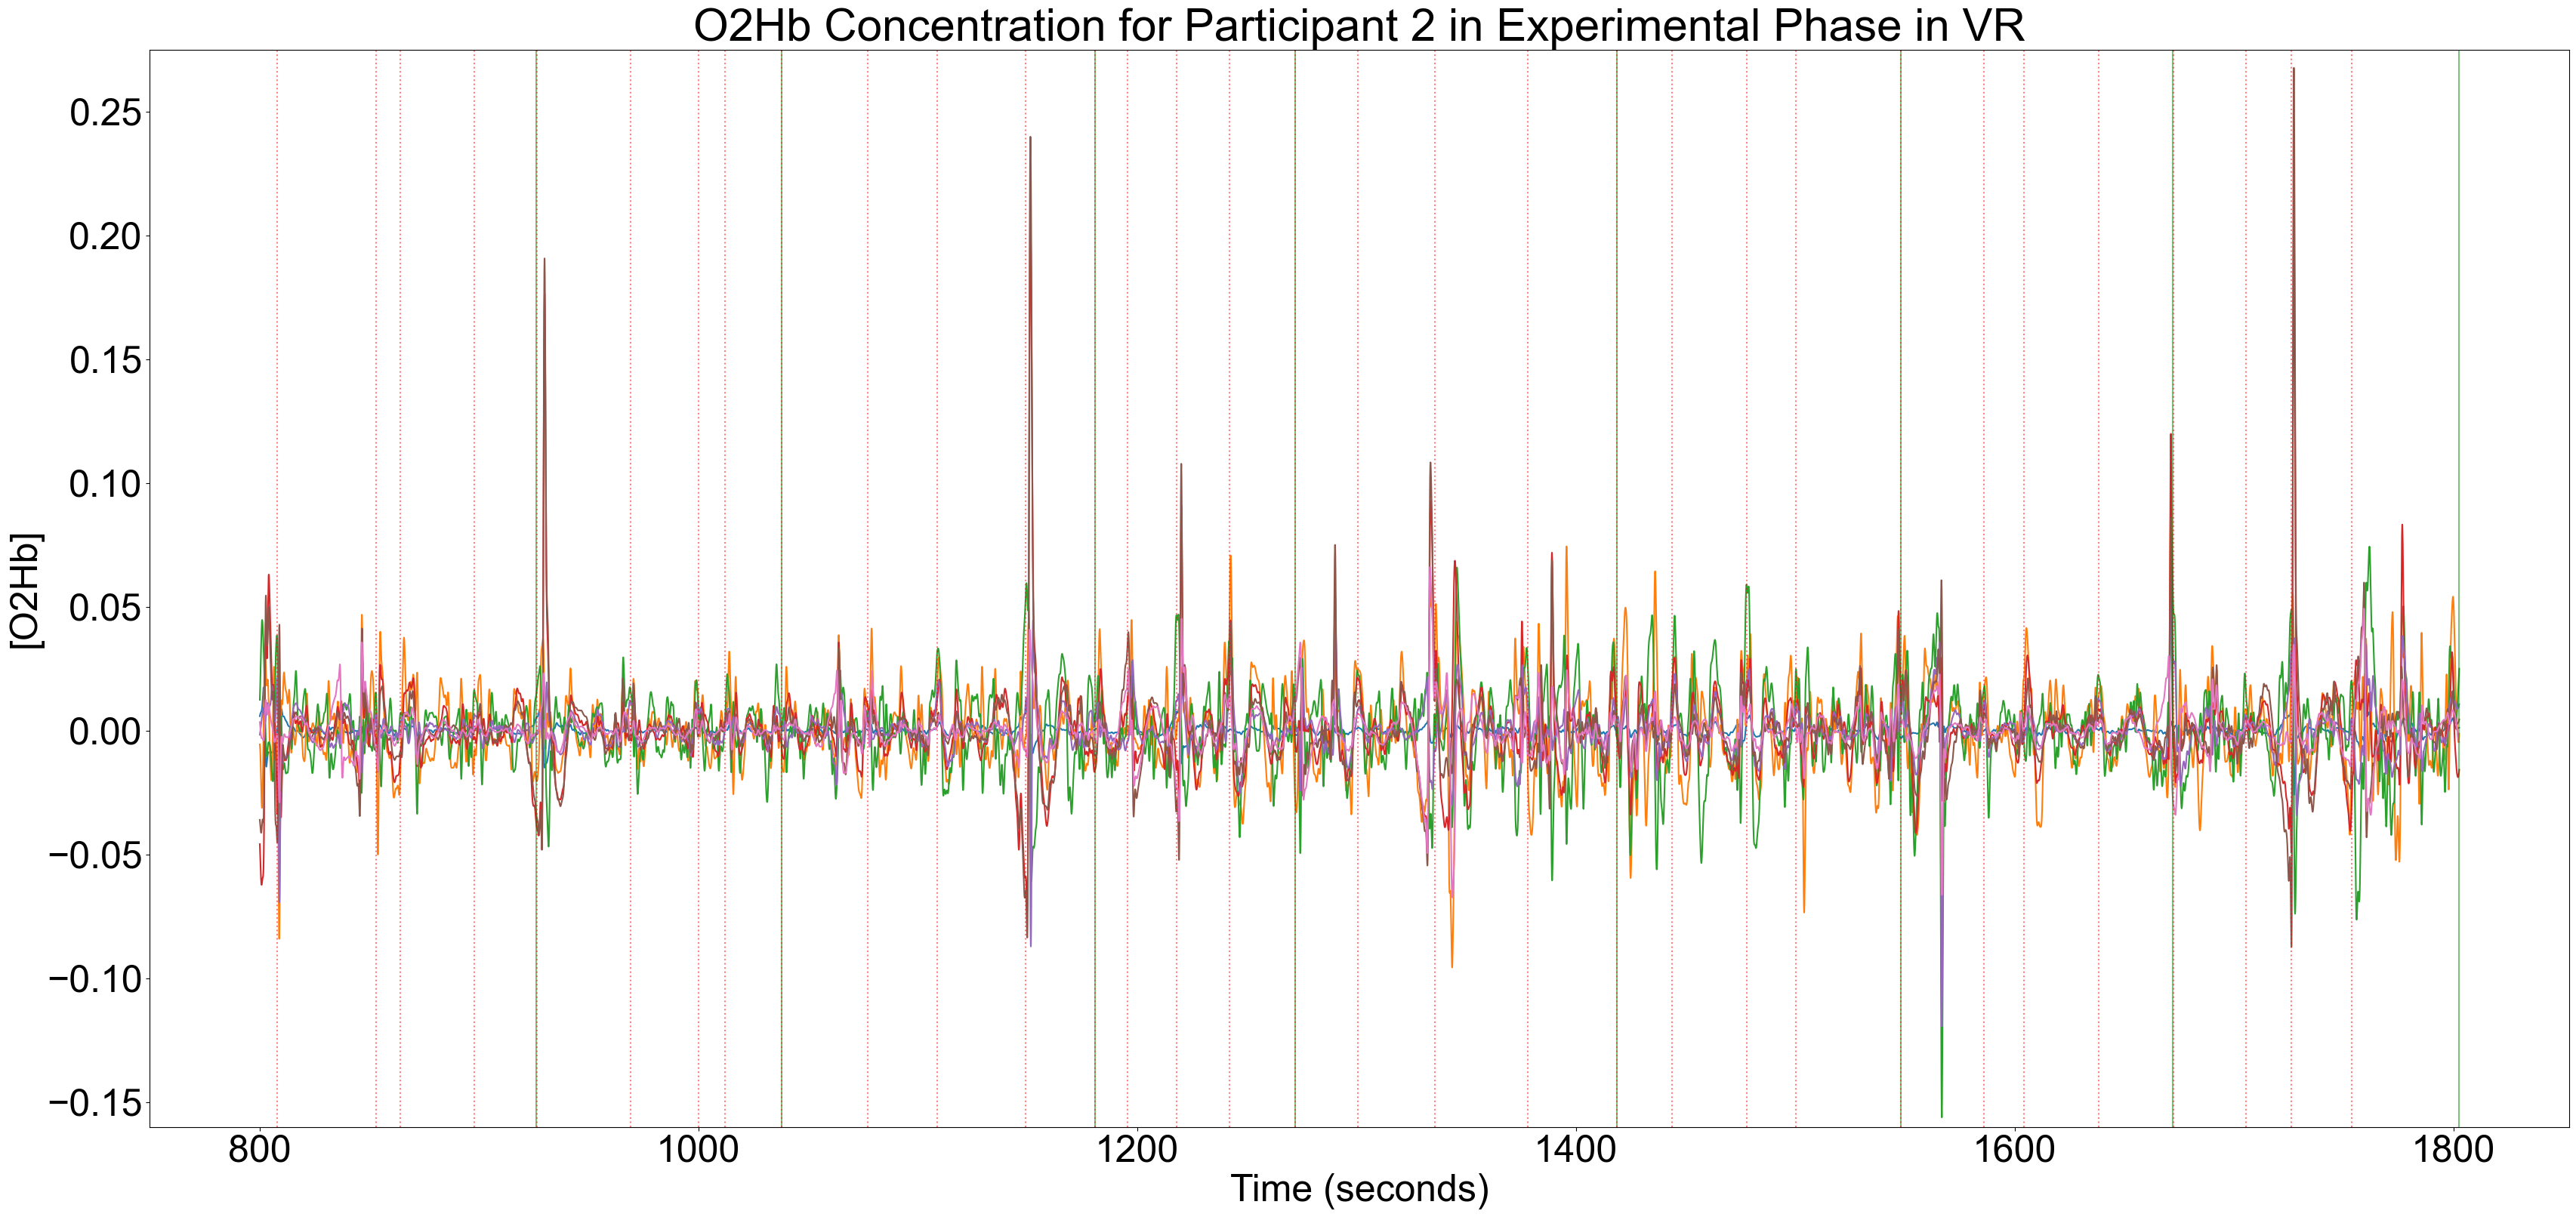

In [217]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd

events_df = fnirs_dictionary[2]['fnirs_data_events_dataframe']
start_index = events_df[events_df['stimulus1'] == 'LSL ActivePhase Experimental'].index[0]
end_index = events_df[events_df['stimulus1'] == 'LSL ActivePhase PostExperiment'].index[0]
filtered_df = events_df.loc[start_index:end_index]
o2hb_columns = [col for col in filtered_df.columns if '[O2Hb]' in col]
plotting_df = filtered_df[o2hb_columns]

# Plotting
plt.figure(figsize=(35, 17))
for col in o2hb_columns:
    plt.plot(filtered_df['times_secs'], plotting_df[col], label=col)

# Initialize an empty list for custom legend handles
legend_handles = []
legend_added_stimuli = set()
last_stimulus = None

# Iterate through the DataFrame to find all occurrences of stimulus changes
for i, row in filtered_df.iterrows():
    stimulus = row['stimulus1']
    time_sec = row['times_secs']
    if stimulus in ['LSL ActivePhase Experimental Feedba']:
        if stimulus != last_stimulus:
            color = 'green'
            plt.axvline(x=time_sec, color=color, linestyle='-', alpha=0.5) 
            if stimulus not in legend_added_stimuli:
                legend_handle = mlines.Line2D([], [], color=color, linestyle=':', label=stimulus)  
                legend_handles.append(legend_handle)
                legend_added_stimuli.add(stimulus)
    elif stimulus and stimulus not in ['LSL ActivePhase Feedback', 'LSL ActivePhase Experimental','LSL ActivePhase PostExperiment', 'LSL EndofExperiment', 'LSL Starting N-back experiment'] and 'isCorrect?' not in stimulus:
        color = 'red'
        if stimulus != last_stimulus and stimulus not in legend_added_stimuli:
            plt.axvline(x=time_sec, color=color, linestyle=':', alpha=0.5) 
            legend_handle = mlines.Line2D([], [], color=color, linestyle=':', label=stimulus)  
            legend_handles.append(legend_handle)
            legend_added_stimuli.add(stimulus)

    # Update the last seen stimulus
    last_stimulus = stimulus

#plt.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(-0.16, 0.275)
plt.xlabel('Time (seconds)')
plt.ylabel('[O2Hb]')
plt.title('O2Hb Concentration for Participant 2 in Experimental Phase in VR')
plt.tight_layout()
plt.show()

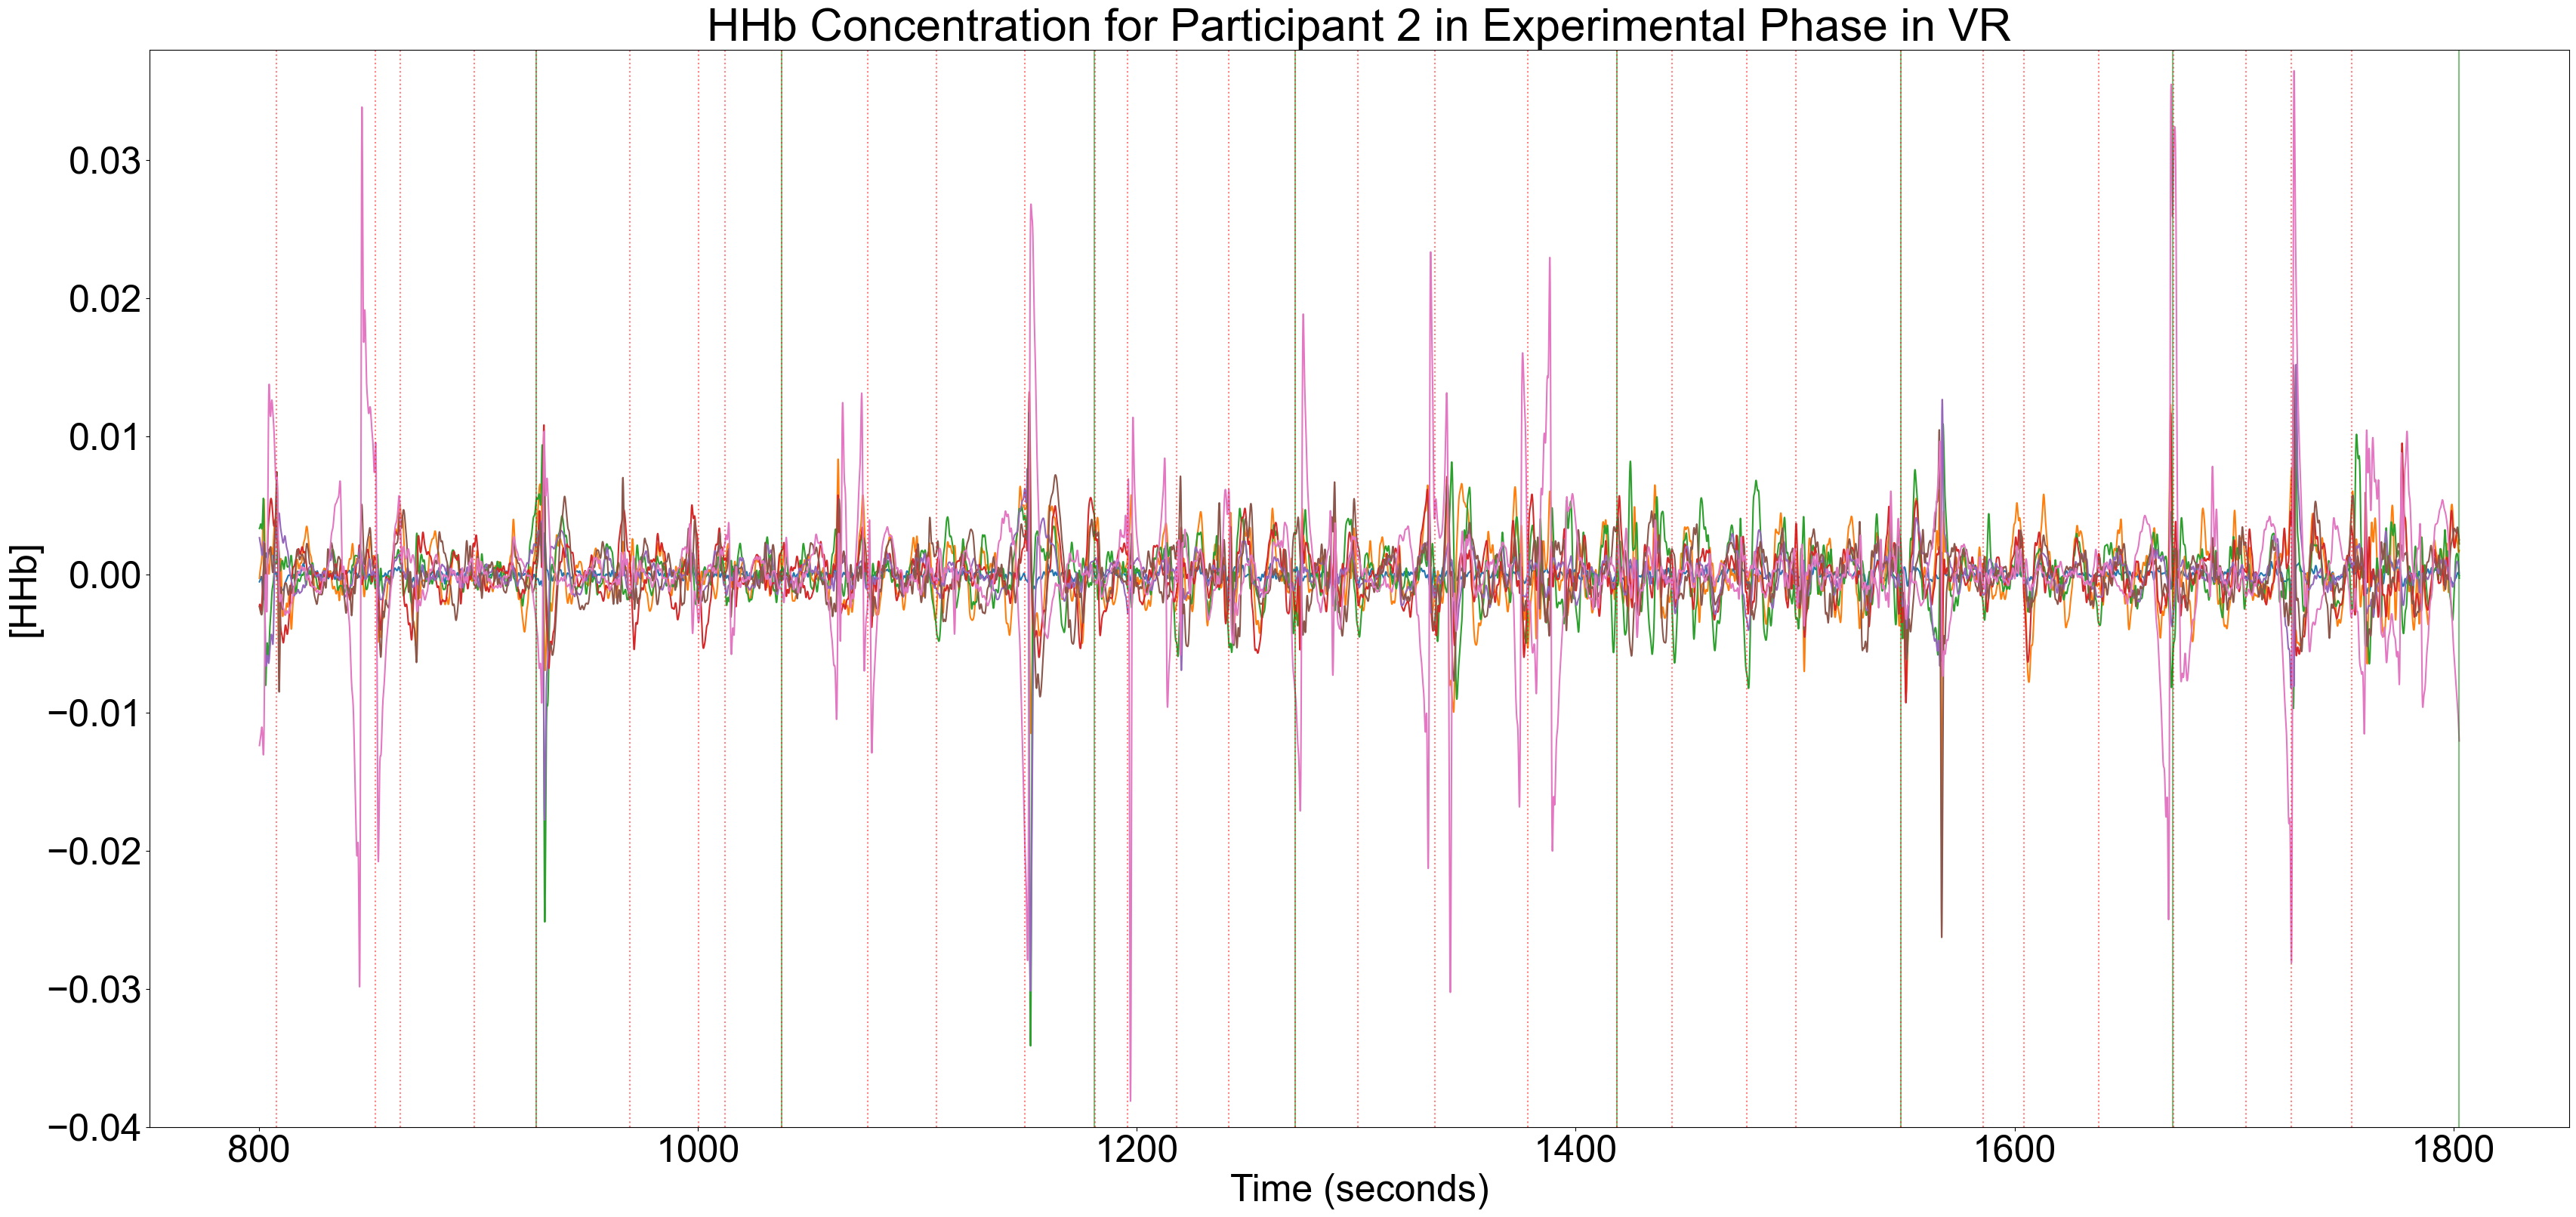

In [229]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd

events_df = fnirs_dictionary[2]['fnirs_data_events_dataframe']
start_index = events_df[events_df['stimulus1'] == 'LSL ActivePhase Experimental'].index[0]
end_index = events_df[events_df['stimulus1'] == 'LSL ActivePhase PostExperiment'].index[0]
filtered_df = events_df.loc[start_index:end_index]
hhb_columns = [col for col in filtered_df.columns if '[HHb]' in col]
plotting_df = filtered_df[hhb_columns]

# Plotting
plt.figure(figsize=(35, 17))
for col in hhb_columns:
    plt.plot(filtered_df['times_secs'], plotting_df[col], label=col)

# Initialize an empty list for custom legend handles
legend_handles = []
legend_added_stimuli = set()
last_stimulus = None

# Iterate through the DataFrame to find all occurrences of stimulus changes
for i, row in filtered_df.iterrows():
    stimulus = row['stimulus1']
    time_sec = row['times_secs']
    if stimulus in ['LSL ActivePhase Experimental Feedba']:
        if stimulus != last_stimulus:
            color = 'green'
            plt.axvline(x=time_sec, color=color, linestyle='-', alpha=0.5) 
            if stimulus not in legend_added_stimuli:
                legend_handle = mlines.Line2D([], [], color=color, linestyle=':', label=stimulus)  
                legend_handles.append(legend_handle)
                legend_added_stimuli.add(stimulus)
    elif stimulus and stimulus not in ['LSL ActivePhase Feedback', 'LSL ActivePhase Experimental','LSL ActivePhase PostExperiment', 'LSL EndofExperiment', 'LSL Starting N-back experiment'] and 'isCorrect?' not in stimulus:
        color = 'red'
        if stimulus != last_stimulus and stimulus not in legend_added_stimuli:
            plt.axvline(x=time_sec, color=color, linestyle=':', alpha=0.5) 
            legend_handle = mlines.Line2D([], [], color=color, linestyle=':', label=stimulus)  
            legend_handles.append(legend_handle)
            legend_added_stimuli.add(stimulus)

    # Update the last seen stimulus
    last_stimulus = stimulus

#plt.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(-0.04, 0.038)
plt.xlabel('Time (seconds)')
plt.ylabel('[HHb]')
plt.title('HHb Concentration for Participant 2 in Experimental Phase in VR')
plt.tight_layout()
plt.show()

TODO (Focus on Experimental Phase)


- Append deltaHB to fnirs_data_events_dataframe for each channel (Tues)
- Duplicate fnirs_data_events_dataframe into a new fnirs dataframe with baseline correction from Rest state (Tues)
- Change fnirs dataframe for graph from new fnirs dataframe (Tues)
- Make similar graph with deltaHb (Tues)
- Clump in the events and datapoints into subexperiments
- Find the peaks of the [ ] for each trial, and for each subexperiment, which one had the highest peak? 
- How many seconds after starting the trial or subexperiment did it take to reach highest peak? 
- See if there is a linear upward trend in [ ] for each trial and for each subexperiment, which one had the highest trend?

In [45]:
"""fnirs_duration_of_events = {}

for participant_id, df in fnirs_dataframes.items():
    # Find the rows in which a '1' appears in the 's'
    indices = np.where(df['s'] == 1)
    # Multiply the values in the first array by 0.04 and subtract 0.04
    new_indices = ((indices[0] * 0.04) - 0.04, indices[1])

    # Create a dictionary where the keys are the column indices and the values are the times of each event
    times_of_events = {column: new_indices[0][np.where(new_indices[1] == column)] for column in np.unique(new_indices[1])}

    # Create time_of_events_with_names
    if type(df['cond_names']) == np.ndarray:
        time_of_events_with_names = {df['cond_names'][0][column][0] if df['cond_names'][0][column] else '': times_of_events[column] for column in times_of_events}
    else:
        time_of_events_with_names = {df['cond_names'][column]: times_of_events[column] for column in times_of_events}
    
    # Create a list of all events with their times
    all_events = [(time, event_name) for event_name, times in time_of_events_with_names.items() for time in times]

    # Sort this list by time
    all_events.sort()

    # Initialize an empty dictionary for the durations
    duration_of_events = {}
    
    # Iterate over the sorted list
    for j in range(len(all_events) - 1):
        # Calculate the duration between each event and the start of the next one
        duration = all_events[j+1][0] - all_events[j][0]

        # Get the event name
        event_name = all_events[j][1]

        # If the event name is not in the dictionary, add it with the duration
        if event_name not in duration_of_events:
            duration_of_events[event_name] = duration
        else:
            # If the event name is already in the dictionary, update the duration only if the new duration is larger
            duration_of_events[event_name] = max(duration_of_events[event_name], duration)

    # Store the durations in the main dictionary with the participant number as the key
    fnirs_duration_of_events[participant_id] = duration_of_events"""

"fnirs_duration_of_events = {}\n\nfor participant_id, df in fnirs_dataframes.items():\n    # Find the rows in which a '1' appears in the 's'\n    indices = np.where(df['s'] == 1)\n    # Multiply the values in the first array by 0.04 and subtract 0.04\n    new_indices = ((indices[0] * 0.04) - 0.04, indices[1])\n\n    # Create a dictionary where the keys are the column indices and the values are the times of each event\n    times_of_events = {column: new_indices[0][np.where(new_indices[1] == column)] for column in np.unique(new_indices[1])}\n\n    # Create time_of_events_with_names\n    if type(df['cond_names']) == np.ndarray:\n        time_of_events_with_names = {df['cond_names'][0][column][0] if df['cond_names'][0][column] else '': times_of_events[column] for column in times_of_events}\n    else:\n        time_of_events_with_names = {df['cond_names'][column]: times_of_events[column] for column in times_of_events}\n    \n    # Create a list of all events with their times\n    all_events

In [46]:
"""fnirs_duration_of_events_columns = {}

for participant_id, df in fnirs_dataframes.items():
    # Find the rows in which a '1' appears in the 's'
    indices = np.where(df['s'] == 1)

    # Create a dictionary where the keys are the column indices and the values are the indices of each event
    indices_of_events = {column: indices[0][np.where(indices[1] == column)] for column in np.unique(indices[1])}

    # Create indices_of_events_with_names
    if type(df['cond_names']) == np.ndarray:
        indices_of_events_with_names = {df['cond_names'][0][column][0] if df['cond_names'][0][column] else '': indices_of_events[column] for column in indices_of_events}
    else:
        indices_of_events_with_names = {df['cond_names'][column]: indices_of_events[column] for column in indices_of_events}

    # Create a list of all events with their indices
    all_events = [(index, event_name) for event_name, indices in indices_of_events_with_names.items() for index in indices]

    # Sort this list by index
    all_events.sort()

    # Initialize an empty dictionary for the column ranges
    column_ranges_of_events = {}

    # Iterate over the sorted list
    for j in range(len(all_events) - 1):
        # Get the event name
        event_name = all_events[j][1]

        # If the event name is not in the dictionary, add it with the current and next index
        if event_name not in column_ranges_of_events:
            column_ranges_of_events[event_name] = [all_events[j][0], all_events[j+1][0]]
        else:
            # If the event name is already in the dictionary, update the last index only if the new index is larger
            column_ranges_of_events[event_name][1] = max(column_ranges_of_events[event_name][1], all_events[j+1][0])

    # Store the column ranges in the main dictionary with the participant number as the key
    fnirs_duration_of_events_columns[participant_id] = column_ranges_of_events"""

"fnirs_duration_of_events_columns = {}\n\nfor participant_id, df in fnirs_dataframes.items():\n    # Find the rows in which a '1' appears in the 's'\n    indices = np.where(df['s'] == 1)\n\n    # Create a dictionary where the keys are the column indices and the values are the indices of each event\n    indices_of_events = {column: indices[0][np.where(indices[1] == column)] for column in np.unique(indices[1])}\n\n    # Create indices_of_events_with_names\n    if type(df['cond_names']) == np.ndarray:\n        indices_of_events_with_names = {df['cond_names'][0][column][0] if df['cond_names'][0][column] else '': indices_of_events[column] for column in indices_of_events}\n    else:\n        indices_of_events_with_names = {df['cond_names'][column]: indices_of_events[column] for column in indices_of_events}\n\n    # Create a list of all events with their indices\n    all_events = [(index, event_name) for event_name, indices in indices_of_events_with_names.items() for index in indices]\n\n    

In [47]:
"""fnirs_duration_of_events_columns[2]"""

'fnirs_duration_of_events_columns[2]'

In [48]:
"""fnirs_events_with_oxy = {}

for participant_id, df in fnirs_dataframes.items():
    # Get the column ranges for this participant
    column_ranges = fnirs_duration_of_events_columns[participant_id]

    # Initialize an empty dictionary for this participant
    events_with_oxy = {}

    # Iterate over the column ranges
    for event_name, (start_column, end_column) in column_ranges.items():
        # Get the data associated with this event
        event_data = df['data'][:, start_column:end_column]

        # Store the data in the dictionary
        events_with_oxy[event_name] = event_data

    # Store the dictionary in the main dictionary with the participant number as the key
    fnirs_events_with_oxy[participant_id] = events_with_oxy"""

"fnirs_events_with_oxy = {}\n\nfor participant_id, df in fnirs_dataframes.items():\n    # Get the column ranges for this participant\n    column_ranges = fnirs_duration_of_events_columns[participant_id]\n\n    # Initialize an empty dictionary for this participant\n    events_with_oxy = {}\n\n    # Iterate over the column ranges\n    for event_name, (start_column, end_column) in column_ranges.items():\n        # Get the data associated with this event\n        event_data = df['data'][:, start_column:end_column]\n\n        # Store the data in the dictionary\n        events_with_oxy[event_name] = event_data\n\n    # Store the dictionary in the main dictionary with the participant number as the key\n    fnirs_events_with_oxy[participant_id] = events_with_oxy"

In [49]:
"""import matplotlib.pyplot as plt

# Get the data for participant 2
data = fnirs_dataframes[2]['data']

# Get the events for participant 2
events = fnirs_duration_of_events_columns[2]

# Iterate over the events
for event_name, (start_column, end_column) in events.items():
    # Create a new figure for this event
    plt.figure()

    # Create a time array from start_column to end_column, with steps of 1
    time = np.arange(start_column, end_column)

    # Plot the data for each channel
    for i in range(data.shape[0]):  # data.shape[0] gives the number of channels
        plt.plot(time, data[i, start_column:end_column], label=f'Channel {i+1}')

    plt.xlabel('Time')
    plt.ylabel('Data')
    plt.title(f'Data over time for each channel during {event_name}')
    plt.legend()
    plt.show()"""

"import matplotlib.pyplot as plt\n\n# Get the data for participant 2\ndata = fnirs_dataframes[2]['data']\n\n# Get the events for participant 2\nevents = fnirs_duration_of_events_columns[2]\n\n# Iterate over the events\nfor event_name, (start_column, end_column) in events.items():\n    # Create a new figure for this event\n    plt.figure()\n\n    # Create a time array from start_column to end_column, with steps of 1\n    time = np.arange(start_column, end_column)\n\n    # Plot the data for each channel\n    for i in range(data.shape[0]):  # data.shape[0] gives the number of channels\n        plt.plot(time, data[i, start_column:end_column], label=f'Channel {i+1}')\n\n    plt.xlabel('Time')\n    plt.ylabel('Data')\n    plt.title(f'Data over time for each channel during {event_name}')\n    plt.legend()\n    plt.show()"

### Building Main CSV

In [50]:
#TODO: Change the code to split the data into subexperiments

import pandas as pd

# Initialize an empty list to store the data
data = []

# Iterate over the participant IDs
for participant_id in participants_indexes:
    # Get the participant's data
    participant_nback_data = nback_participants_data[participant_id]
    participant_activeTime_data = activeTime_data[participant_id]
    participant_experiment_set_times = experiment_set_times_dict[participant_id]
    participant_experiment_phase_trials = experiment_phase_trials_dict[participant_id]['TrialDuration']
    participant_feedback = feedback[participant_id]
    participant_answers_data = answers_data[participant_id]
    participant_eye_tracking_data = eye_tracking_data[participant_id]
    participant_blink_info = blink_info_per_subexperiment[participant_id]

    # Create a dictionary for each participant
    participant_data = {
        'start_time': participant_activeTime_data['Start'][0],
        'calibration_time': participant_activeTime_data['Calibration'][0],
        'tutorial_time': participant_activeTime_data['Tutorial'][0],
        'rest_time': participant_activeTime_data['Rest'][0],
        'answer_total_correct': participant_answers_data['Total'].loc[participant_answers_data['Total']['Score'] == 'Correct', 'Total Trials'].values[0],
        'answer_total_incorrect': participant_answers_data['Total'].loc[participant_answers_data['Total']['Score'] == 'Incorrect', 'Total Trials'].values[0],
    }
    
    for i, time in enumerate(participant_experiment_set_times, start=1):
        participant_data[f'time_subexperiment{i}'] = time
    
    # Add the trial durations to the participant data
    for i, duration in enumerate(participant_experiment_phase_trials):
        participant_data[f'trial_duration_{i+1}'] = duration
        
    # Add the feedback scores to the participant data
    for phase in ['tutorial', 'rest', 'experimental']:
        for i, score in enumerate(participant_feedback[phase][' FeedbackScore']):
            participant_data[f'feedback_score_{phase}_{i+1}'] = score

     # Add the answers data to the participant data
    for i, row in participant_answers_data['SubExperiments'].iterrows():
        participant_data[f'answer_correct_subexperiment_{i+1}'] = row['sum']
        participant_data[f'answer_incorrect_subexperiment_{i+1}'] = row['Incorrect']
    
    # Add the eye tracking data to the participant data
    for key, value in participant_eye_tracking_data.items():
        participant_data[f'eye_{key}'] = value
        
    # Calculate the total accuracy per subexperiment
    for i in range(1, 9):
        participant_data[f'accuracy_subexperiment{i}'] = (participant_data[f'answer_correct_subexperiment_{i}'] / 4) * 100

    # Convert the dictionary to a Series and append it to the list
    data.append(pd.Series(participant_data, name=participant_id))

# Concatenate the Series in the list into a DataFrame
df = pd.concat(data, axis=1).T

# Print the new DataFrame
print(df)

    start_time  calibration_time  tutorial_time  rest_time  \
2     689.8644           21.4461       427.7345   300.0060   
3     355.7957            6.8837       402.9241   300.0095   
4     119.4950            6.7635       448.2359   300.0153   
10    256.7826            5.8230       590.3329   300.0045   
15    127.4750            8.6062       717.8423   300.0025   
16    681.0095            5.9546       389.0769   300.0060   
20    443.1895           36.0740       519.9725   300.0070   
21    738.7303            5.5453       439.4244   300.0030   
22    563.3018           30.0822       548.7770   300.0080   
23    459.7932            4.9753       382.1331   300.0034   
24    397.2629           55.9613       331.3882   300.0106   
25    327.8929            4.3278       360.5435   300.0051   
26    251.6684           30.1536       587.6608   300.0052   
27    442.9685            7.3147       357.1639   300.0029   
28    368.2454            6.8680       370.4943   300.0033   
29    31

In [51]:
# Output df to csv
df.to_csv('DryRunData.csv', index=False)

In [52]:
blink_info_per_subexperiment[2]['SubExperiment1']['blink_count']

16

### DryRunData2 (Per Subexperiment)

In [53]:
data = []

# Iterate over the participant IDs
for participant_id in participants_indexes:
    # Get the participant's data
    participant_nback_data = nback_participants_data[participant_id]
    mrt_participant_data = mrt_participants_data[participant_id]
    participant_activeTime_data = activeTime_data[participant_id]
    participant_experiment_set_times = experiment_set_times_dict[participant_id]
    participant_experiment_phase_trials = experiment_phase_trials_dict[participant_id]['TrialDuration']
    participant_feedback = feedback[participant_id]
    participant_answers_data = answers_data[participant_id]
    participant_eye_tracking_data = eye_tracking_data_per_subexperiment[participant_id]
    participant_blink_info = blink_info_per_subexperiment[participant_id]
    participant_gaze_velocity = gaze_velocity_per_subexperiment[participant_id]
    participant_fixations = fixations_per_subexperiment[participant_id]

    # Iterate over the sub-experiments
    for subexperiment in range(1, 9):
        # Create a dictionary for each participant and sub-experiment
        participant_data = {
            'participant_number': participant_id,
            'subexperiment_number': subexperiment,
            'MRTScore': mrt_participant_data['MRTScore'],
            'MRTAcc': mrt_participant_data['MRTAcc'],
            'MRTGroup': mrt_participant_data['MRTGroup'],
            'nback_hits_0' : participant_nback_data['hits'][0],
            'nback_hit_rate_0' : participant_nback_data['hit_rate'][0],
            'nback_correct_rejections_0' : participant_nback_data['correct_rejections'][0],
            'nback_rt_target_0': participant_nback_data['rt_target'][0],
            'nback_rt_nontarget_0': participant_nback_data['rt_non_target'][0],
            'nback_composite_0' : participant_nback_data['composite_score'][0],
            'nback_hits_1' : participant_nback_data['hits'][1],
            'nback_hit_rate_1' : participant_nback_data['hit_rate'][1],
            'nback_correct_rejections_1' : participant_nback_data['correct_rejections'][1],
            'nback_rt_target_1': participant_nback_data['rt_target'][1],
            'nback_rt_nontarget_1': participant_nback_data['rt_non_target'][1],
            'nback_composite_1' : participant_nback_data['composite_score'][1],
            'nback_hits_2' : participant_nback_data['hits'][2],
            'nback_hit_rate_2' : participant_nback_data['hit_rate'][2],
            'nback_correct_rejections_2' : participant_nback_data['correct_rejections'][2],
            'nback_rt_target_2': participant_nback_data['rt_target'][2],
            'nback_rt_nontarget_2': participant_nback_data['rt_non_target'][2],
            'nback_composite_2' : participant_nback_data['composite_score'][2],
            #'start_time': participant_activeTime_data['Start'][0],
            #'calibration_time': participant_activeTime_data['Calibration'][0],
            #'tutorial_time': participant_activeTime_data['Tutorial'][0],
            'rest_time': participant_activeTime_data['Rest'][0],
            'time_subexperiment': participant_experiment_set_times[subexperiment-1],
            'accuracy_subexperiment' : participant_answers_data['SubExperiments'].loc[subexperiment-1, 'sum']/4 * 100,
            'accuracy_total': participant_answers_data['Accuracy'],
            'answer_correct_subexperiment': participant_answers_data['SubExperiments'].loc[subexperiment-1, 'sum'],
            'answer_incorrect_subexperiment': participant_answers_data['SubExperiments'].loc[subexperiment-1, 'Incorrect'],
            'feedback_score_subexperiment': participant_feedback['experimental'][' FeedbackScore'][subexperiment+3],
            #'blink_count': participant_blink_info[f'SubExperiment{subexperiment}']['blink_count'],
            #'rest_blink_rest_count': participant_blink_info[' Rest']['blink_count'],
            #'blink_rate' : participant_blink_info[f'SubExperiment{subexperiment}']['blink_rate'],
            #'rest_blink_rate': participant_blink_info[' Rest']['rest_blink_rate'],
            #'normalized_blink_rate': participant_blink_info[f'SubExperiment{subexperiment}']['normalized_blink_rate'],
            #'num_fixations': participant_fixations[f'SubExperiment{subexperiment}']['FixationGroup'].nunique(),
            #'num_fixations_rest': participant_fixations[' Rest']['FixationGroup'].nunique(),
            #'fixation_durations': participant_fixations[f'SubExperiment{subexperiment}']['TotalFixationDuration'].iloc[1],
            #'fixation_durations_rest': participant_fixations[' Rest']['TotalFixationDuration'].iloc[1],
            #'avg_FixationPointX': participant_fixations[f'SubExperiment{subexperiment}']['FixationPointX_avg'].iloc[1],
            #'avg_FixationPointY': participant_fixations[f'SubExperiment{subexperiment}']['FixationPointY_avg'].iloc[1],
            #'avg_FixationPointZ': participant_fixations[f'SubExperiment{subexperiment}']['FixationPointZ_avg'].iloc[1],
            #'avg_FixationPointX_rest': participant_fixations[' Rest']['FixationPointX_avg'].iloc[1],
            #'avg_FixationPointY_rest': participant_fixations[' Rest']['FixationPointY_avg'].iloc[1],
            #'avg_FixationPointZ_rest': participant_fixations[' Rest']['FixationPointZ_avg'].iloc[1],
        }

        # Inside the loop, after filling the participant_data dictionary
        nback_hits_avg = np.mean([participant_nback_data['hits'][i] for i in range(3)])
        nback_hit_rate_avg = np.mean([participant_nback_data['hit_rate'][i] for i in range(3)])
        nback_rt_target_avg = np.mean([participant_nback_data['rt_target'][i] for i in range(3)])
        nback_rt_non_target_avg = np.mean([participant_nback_data['rt_non_target'][i] for i in range(3)])
        nback_composite_avg = np.mean([participant_nback_data['composite_score'][i] for i in range(3)])

        # Add the averages to the participant_data dictionary
        participant_data['nback_hits_avg'] = nback_hits_avg
        participant_data['nback_hit_rate_avg'] = nback_hit_rate_avg
        participant_data['nback_rt_target_avg'] = nback_rt_target_avg
        participant_data['nback_rt_non_target_avg'] = nback_rt_non_target_avg
        participant_data['nback_composite_avg'] = nback_composite_avg

        # Add each trial duration as a separate column entry
        trial_durations = participant_experiment_phase_trials[(subexperiment-1)*4:subexperiment*4]
        for i, duration in enumerate(trial_durations):
            participant_data[f'trial_duration_{i+1}'] = duration

        # Calculate the mean duration using numpy's mean function and add it as another column
        participant_data['trial_duration_mean'] = np.mean([duration for duration in trial_durations])

        # Calculate performance_subexperiment
        participant_data['performance_subexperiment'] = ((participant_data['accuracy_subexperiment'] / 100) / participant_data['trial_duration_mean']) * 100

        # Add the feedback scores for all tutorial and rest phases
        for i, score in enumerate(participant_feedback['tutorial'][' FeedbackScore']):
            participant_data[f'feedback_score_tutorial_{i+1}'] = score
        for i, score in enumerate(participant_feedback['rest'][' FeedbackScore']):
            participant_data[f'feedback_score_rest_{i+1}'] = score

        # Add the eye tracking data to the participant data
        for key, value in participant_eye_tracking_data[f'SubExperiment{subexperiment}'].items():
            participant_data[f'eye_{key}'] = value

        # Convert the dictionary to a Series and append it to the list
        data.append(pd.Series(participant_data, name=f'{participant_id}_subexperiment{subexperiment}'))
        
# Concatenate the Series in the list into a DataFrame
newdf = pd.concat(data, axis=1).T


### Inflection Point of Cognitive Load

In [54]:
import numpy as np

# Step 1: Create a new DataFrame
df = newdf[['participant_number', 'subexperiment_number', 'feedback_score_subexperiment', 'performance_subexperiment']]

# Step 2: Group by 'participant_number' and 'subexperiment_number' and calculate the mean
df_mean = df.groupby(['participant_number', 'subexperiment_number']).mean()

# Step 3: Calculate the overload metric, its second derivative, and find the inflection point for each participant
for participant in df_mean.index.get_level_values('participant_number').unique():
    df_participant = df_mean.loc[participant]
    df_participant['overload_metric'] = df_participant['feedback_score_subexperiment'] - df_participant['performance_subexperiment']
    df_participant['second_derivative_overload'] = df_participant['overload_metric'].diff().diff()
    overload_point = df_participant['second_derivative_overload'].abs().idxmax()
    print(f'Participant {participant}: Subexperiment of cognitive overload: {overload_point}')

Participant 2: Subexperiment of cognitive overload: 3
Participant 3: Subexperiment of cognitive overload: 3
Participant 4: Subexperiment of cognitive overload: 3
Participant 10: Subexperiment of cognitive overload: 4
Participant 15: Subexperiment of cognitive overload: 5
Participant 16: Subexperiment of cognitive overload: 3
Participant 20: Subexperiment of cognitive overload: 8
Participant 21: Subexperiment of cognitive overload: 6
Participant 22: Subexperiment of cognitive overload: 5
Participant 23: Subexperiment of cognitive overload: 6
Participant 24: Subexperiment of cognitive overload: 3
Participant 25: Subexperiment of cognitive overload: 5
Participant 26: Subexperiment of cognitive overload: 4
Participant 27: Subexperiment of cognitive overload: 4
Participant 28: Subexperiment of cognitive overload: 6
Participant 29: Subexperiment of cognitive overload: 6
Participant 30: Subexperiment of cognitive overload: 8
Participant 31: Subexperiment of cognitive overload: 3
Participant 3

In [55]:
# Initialize a dictionary to store the cognitive overload for each participant
cognitive_overload = {}

# Iterate over the participant numbers
for idx in newdf['participant_number'].unique():
    # Create a new DataFrame for the current participant
    df_participant = newdf[newdf['participant_number'] == idx]

    # Group by 'subexperiment_number' and calculate the mean of the relevant columns
    df_mean = df_participant.groupby('subexperiment_number')[['feedback_score_subexperiment', 'performance_subexperiment']].mean()

    # Calculate the overload metric and its second derivative
    df_mean['overload_metric'] = df_mean['feedback_score_subexperiment'] - df_mean['performance_subexperiment']
    df_mean['second_derivative_overload'] = df_mean['overload_metric'].diff().diff()

    # Find the subexperiment of cognitive overload
    overload_point = df_mean['second_derivative_overload'].abs().idxmax()

    # Select the first row for the current participant
    first_row = df_participant.iloc[0]

    # Calculate the mean of 'feedback_score_rest_1' and 'feedback_score_tutorial_3' for the participant
    cogload_mean = first_row[['feedback_score_tutorial_2', 'feedback_score_tutorial_3']].mean()

    # Initialize a dictionary to store the cognitive overload information for the participant
    cognitive_overload[idx] = {
        'cogload_subexperiment': overload_point,
        'cogload_mean': cogload_mean,
    }

    # Iterate over the subexperiment numbers
    for subexperiment in df_mean.index:
        # Determine the cogload_group based on the comparison between feedback_score_subexperiment and cogload_mean
        cogload_group = 'High' if df_mean.loc[subexperiment, 'feedback_score_subexperiment'] > cogload_mean else 'Low'

        # Store the cogload_group in the cognitive overload information for the participant and the subexperiment
        cognitive_overload[idx][f'cogload_group_subexperiment{subexperiment}'] = cogload_group

print(cognitive_overload)

{2: {'cogload_subexperiment': 3, 'cogload_mean': 5.5, 'cogload_group_subexperiment1': 'Low', 'cogload_group_subexperiment2': 'Low', 'cogload_group_subexperiment3': 'High', 'cogload_group_subexperiment4': 'High', 'cogload_group_subexperiment5': 'High', 'cogload_group_subexperiment6': 'High', 'cogload_group_subexperiment7': 'High', 'cogload_group_subexperiment8': 'High'}, 3: {'cogload_subexperiment': 3, 'cogload_mean': 4.0, 'cogload_group_subexperiment1': 'High', 'cogload_group_subexperiment2': 'Low', 'cogload_group_subexperiment3': 'Low', 'cogload_group_subexperiment4': 'Low', 'cogload_group_subexperiment5': 'Low', 'cogload_group_subexperiment6': 'Low', 'cogload_group_subexperiment7': 'High', 'cogload_group_subexperiment8': 'High'}, 4: {'cogload_subexperiment': 3, 'cogload_mean': 4.0, 'cogload_group_subexperiment1': 'Low', 'cogload_group_subexperiment2': 'Low', 'cogload_group_subexperiment3': 'High', 'cogload_group_subexperiment4': 'High', 'cogload_group_subexperiment5': 'High', 'cogloa

In [56]:
# Initialize a dictionary to store the cognitive overload for each participant
cognitive_overload = {}

# Iterate over the participant numbers
for idx in newdf['participant_number'].unique():
    # Create a new DataFrame for the current participant
    df_participant = newdf[newdf['participant_number'] == idx]

    # Group by 'subexperiment_number' and calculate the mean of the relevant columns
    df_mean = df_participant.groupby('subexperiment_number')[['feedback_score_subexperiment', 'performance_subexperiment']].mean()

    # Calculate the overload metric and its second derivative
    df_mean['overload_metric'] = df_mean['feedback_score_subexperiment'] - df_mean['performance_subexperiment']
    df_mean['second_derivative_overload'] = df_mean['overload_metric'].diff().diff()

    # Find the subexperiment of cognitive overload
    overload_point = df_mean['second_derivative_overload'].abs().idxmax()

    # Select the first row for the current participant
    first_row = df_participant.iloc[0]

    # Calculate the mean of 'feedback_score_tutorial_2' and 'feedback_score_tutorial_3' for the participant
    cogload_mean = first_row[['feedback_score_tutorial_2', 'feedback_score_tutorial_3']].mean()

    # Calculate standard deviation of feedback_score_subexperiment for the participant
    std_dev = df_participant['feedback_score_subexperiment'].std()

    # Initialize a dictionary to store the cognitive overload information for the participant
    cognitive_overload[idx] = {
        'cogload_subexperiment': overload_point,
        'cogload_mean': cogload_mean,
        'std_dev': std_dev,
    }

    # Iterate over the subexperiment numbers
    for subexperiment in df_mean.index:
        # Calculate z-score for feedback_score_subexperiment
        x = df_mean.loc[subexperiment, 'feedback_score_subexperiment']
        z_score = (x - cogload_mean) / std_dev if std_dev > 0 else 0

        # Determine the cogload_group based on the comparison between feedback_score_subexperiment and cogload_mean
        cogload_group = 'High' if df_mean.loc[subexperiment, 'feedback_score_subexperiment'] > cogload_mean else 'Low'

        # Store the cogload_group and z-score in the cognitive overload information for the participant and the subexperiment
        cognitive_overload[idx][f'cogload_group_subexperiment{subexperiment}'] = cogload_group
        cognitive_overload[idx][f'z_score_subexperiment{subexperiment}'] = z_score

print(cognitive_overload)

{2: {'cogload_subexperiment': 3, 'cogload_mean': 5.5, 'std_dev': 1.164964745021435, 'cogload_group_subexperiment1': 'Low', 'z_score_subexperiment1': -0.42919753763947605, 'cogload_group_subexperiment2': 'Low', 'z_score_subexperiment2': -1.287592612918428, 'cogload_group_subexperiment3': 'High', 'z_score_subexperiment3': 1.287592612918428, 'cogload_group_subexperiment4': 'High', 'z_score_subexperiment4': 1.287592612918428, 'cogload_group_subexperiment5': 'High', 'z_score_subexperiment5': 1.287592612918428, 'cogload_group_subexperiment6': 'High', 'z_score_subexperiment6': 1.287592612918428, 'cogload_group_subexperiment7': 'High', 'z_score_subexperiment7': 0.42919753763947605, 'cogload_group_subexperiment8': 'High', 'z_score_subexperiment8': 1.287592612918428}, 3: {'cogload_subexperiment': 3, 'cogload_mean': 4.0, 'std_dev': 1.9594095320493148, 'cogload_group_subexperiment1': 'High', 'z_score_subexperiment1': 1.0207156632070848, 'cogload_group_subexperiment2': 'Low', 'z_score_subexperiment

In [57]:
# Iterate over the participant IDs
for participant_id in participants_indexes:
    # Get the participant's cognitive overload data
    participant_cognitive_overload_data = cognitive_overload[participant_id]

    # Iterate over the sub-experiments
    for subexperiment in range(1, 9):
        # Add the cognitive overload data to the participant's data in the DataFrame
        newdf.loc[f'{participant_id}_subexperiment{subexperiment}', 'cogload_subexperiment'] = participant_cognitive_overload_data['cogload_subexperiment']
        newdf.loc[f'{participant_id}_subexperiment{subexperiment}', 'cogload_mean'] = participant_cognitive_overload_data['cogload_mean']
        newdf.loc[f'{participant_id}_subexperiment{subexperiment}', 'cogload_group'] = participant_cognitive_overload_data[f'cogload_group_subexperiment{subexperiment}']
        newdf.loc[f'{participant_id}_subexperiment{subexperiment}', 'z_score'] = participant_cognitive_overload_data[f'z_score_subexperiment{subexperiment}']
        newdf.loc[f'{participant_id}_subexperiment{subexperiment}', 'std_dev'] = participant_cognitive_overload_data['std_dev']

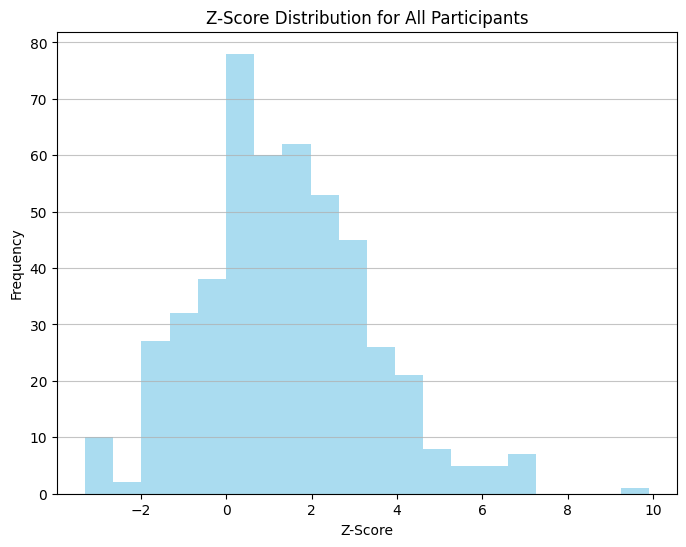

In [58]:
import matplotlib.pyplot as plt

# Collect Z-Scores for All Participants
all_z_scores = []
for participant_id in cognitive_overload.keys():
    for subexperiment in range(1, 9):
        z_score_key = f'z_score_subexperiment{subexperiment}'
        if z_score_key in cognitive_overload[participant_id]:
            all_z_scores.append(cognitive_overload[participant_id][z_score_key])

# Plot the Distribution for All Participants
plt.figure(figsize=(8, 6))
plt.hist(all_z_scores, bins=20, color='skyblue', alpha=0.7)
plt.title('Z-Score Distribution for All Participants')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [59]:
# Group the dataframe by 'participant_number' and 'subexperiment_number' and calculate the mean of 'feedback_score_subexperiment'
grouped_df = newdf.groupby(['participant_number', 'subexperiment_number'])['feedback_score_subexperiment'].mean().reset_index()

# Filter the grouped dataframe for rows where 'subexperiment_number' is 5
grouped_df_5 = grouped_df[grouped_df['subexperiment_number'] == 5]

# Calculate the median of 'feedback_score_subexperiment'
median_feedback_score = grouped_df_5['feedback_score_subexperiment'].median()

print(f"The median feedback score at subexperiment number 5 is: {median_feedback_score}")

The median feedback score at subexperiment number 5 is: 5.0


In [60]:
newdf.to_csv('DryRunData2.csv', index=False)

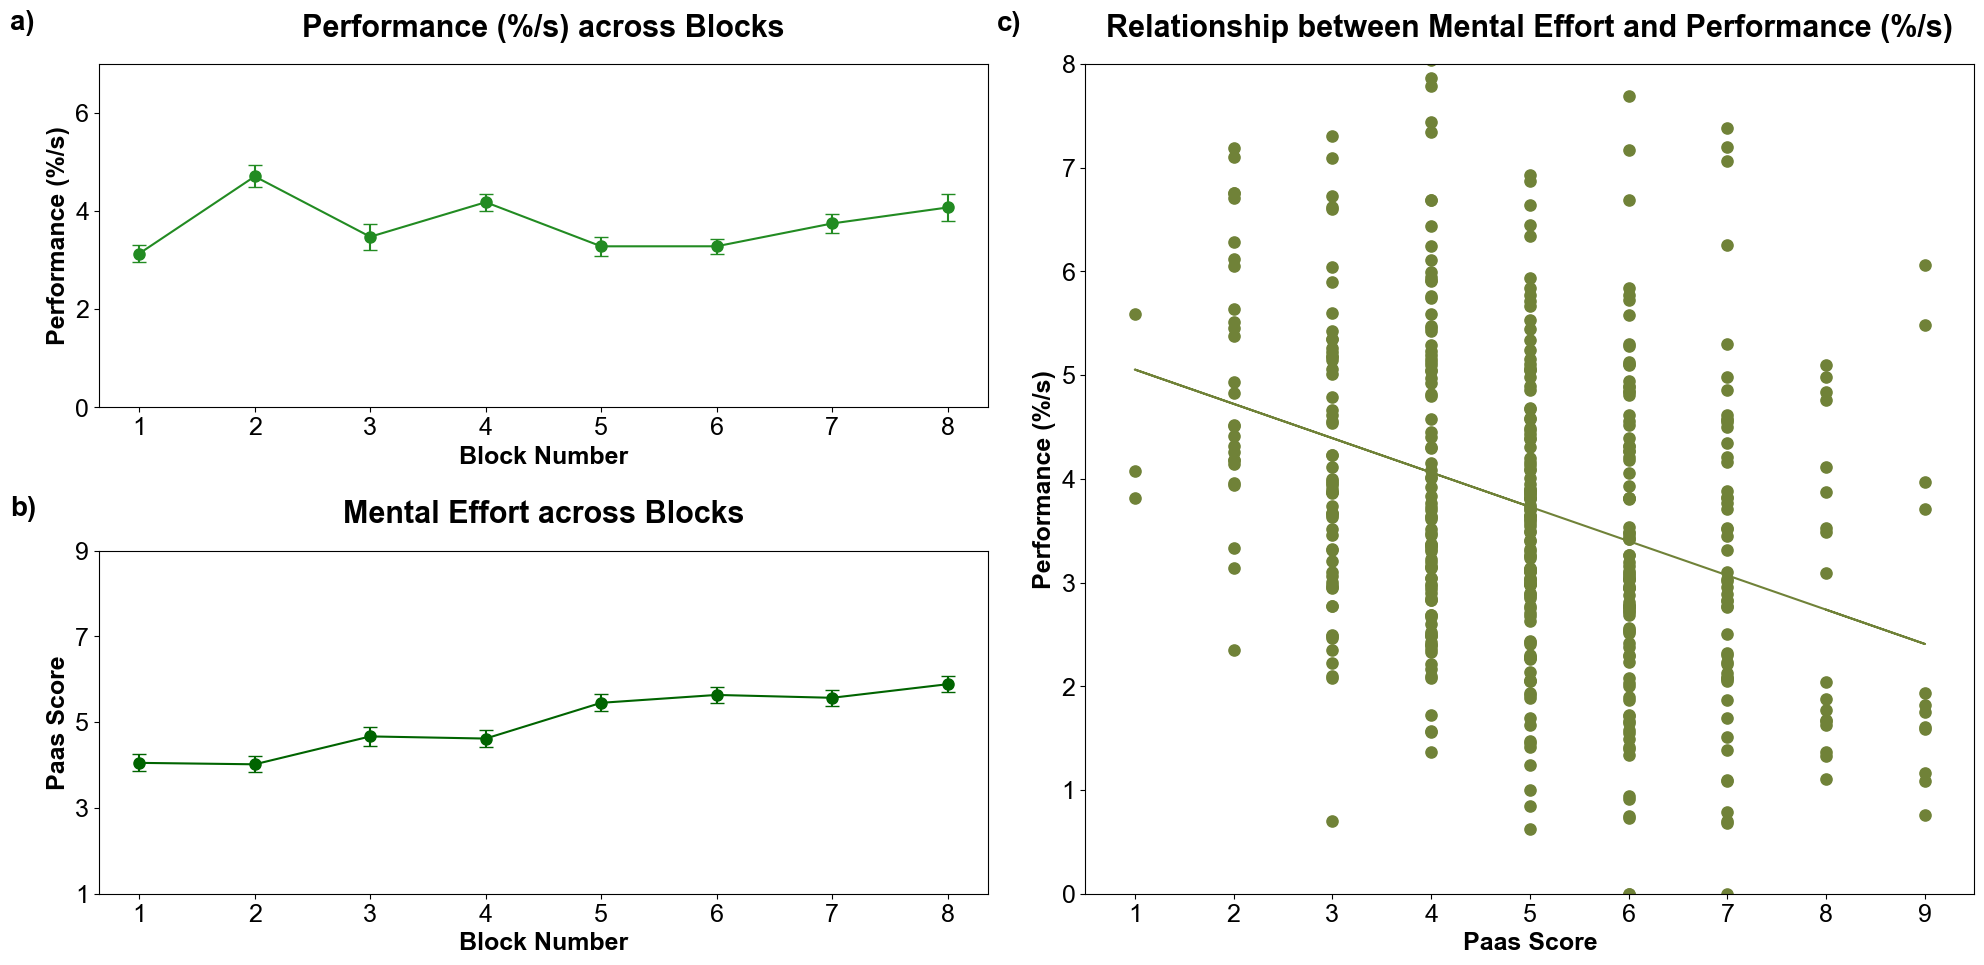

In [61]:
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'newdf' is defined somewhere above this code snippet

# Calculate means and SEM (Standard Error of the Mean)
grouped = newdf.groupby('subexperiment_number')
performance_mean = grouped['performance_subexperiment'].mean()
performance_sem = grouped['performance_subexperiment'].sem()  # Changed from std to sem
feedback_score_mean = grouped['feedback_score_subexperiment'].mean()
feedback_score_sem = grouped['feedback_score_subexperiment'].sem()  # Changed from std to sem

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18

# Create a grid of subplots
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(2, 2, figure=fig)

# 1st subplot
ax1 = fig.add_subplot(gs[0, 0])
ax1.errorbar(performance_mean.index, performance_mean, yerr=performance_sem, fmt='o', capsize=5, color='#228B22', markersize=8)  # Added markersize=8
ax1.plot(performance_mean.index, performance_mean, 'o-', color='#228B22')
ax1.set_title('Performance (%/s) across Blocks', fontsize=22, weight='bold', pad=20)
ax1.set_xlabel('Block Number', weight='bold')
ax1.set_ylabel('Performance (%/s)', weight='bold')
ax1.set_ylim(0, 7)
ax1.set_yticks(range(0, 8, 2))
ax1.text(-0.1, 1.1, 'a)', transform=ax1.transAxes, size=20, weight='bold')

# 2nd subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.errorbar(feedback_score_mean.index, feedback_score_mean, yerr=feedback_score_sem, fmt='o', capsize=5, color='#006400', markersize=8)  # Added markersize=8
ax2.plot(feedback_score_mean.index, feedback_score_mean, 'o-', color='#006400')
ax2.set_title('Mental Effort across Blocks', fontsize=22, weight='bold', pad=20)
ax2.set_xlabel('Block Number', weight='bold')
ax2.set_ylabel('Paas Score', weight='bold')
ax2.set_ylim(1, 9)
ax2.set_yticks(range(1, 10, 2))
ax2.text(-0.1, 1.1, 'b)', transform=ax2.transAxes, size=20, weight='bold')

# Clean the data
clean_data = newdf.dropna(subset=['feedback_score_subexperiment', 'performance_subexperiment'])
clean_data['feedback_score_subexperiment'] = pd.to_numeric(clean_data['feedback_score_subexperiment'], errors='coerce')
clean_data['performance_subexperiment'] = pd.to_numeric(clean_data['performance_subexperiment'], errors='coerce')
clean_data = clean_data.dropna(subset=['feedback_score_subexperiment', 'performance_subexperiment'])

# 3rd subplot
ax3 = fig.add_subplot(gs[:, 1])
ax3.scatter(clean_data['feedback_score_subexperiment'], clean_data['performance_subexperiment'], color='#708238', s=65)  # Changed marker size with s=65
m, b = np.polyfit(clean_data['feedback_score_subexperiment'], clean_data['performance_subexperiment'], 1)
ax3.plot(clean_data['feedback_score_subexperiment'], m*clean_data['feedback_score_subexperiment'] + b, color='#708238')
ax3.set_title('Relationship between Mental Effort and Performance (%/s)', fontsize=22, weight='bold', pad=20)
ax3.set_xlabel('Paas Score', weight='bold')
ax3.set_xlim(0.5, 9.5)
ax3.set_ylabel('Performance (%/s)', weight='bold')
ax3.set_ylim(0, 8)
ax3.text(-0.1, 1.04, 'c)', transform=ax3.transAxes, size=20, weight='bold')

plt.tight_layout()
plt.show()

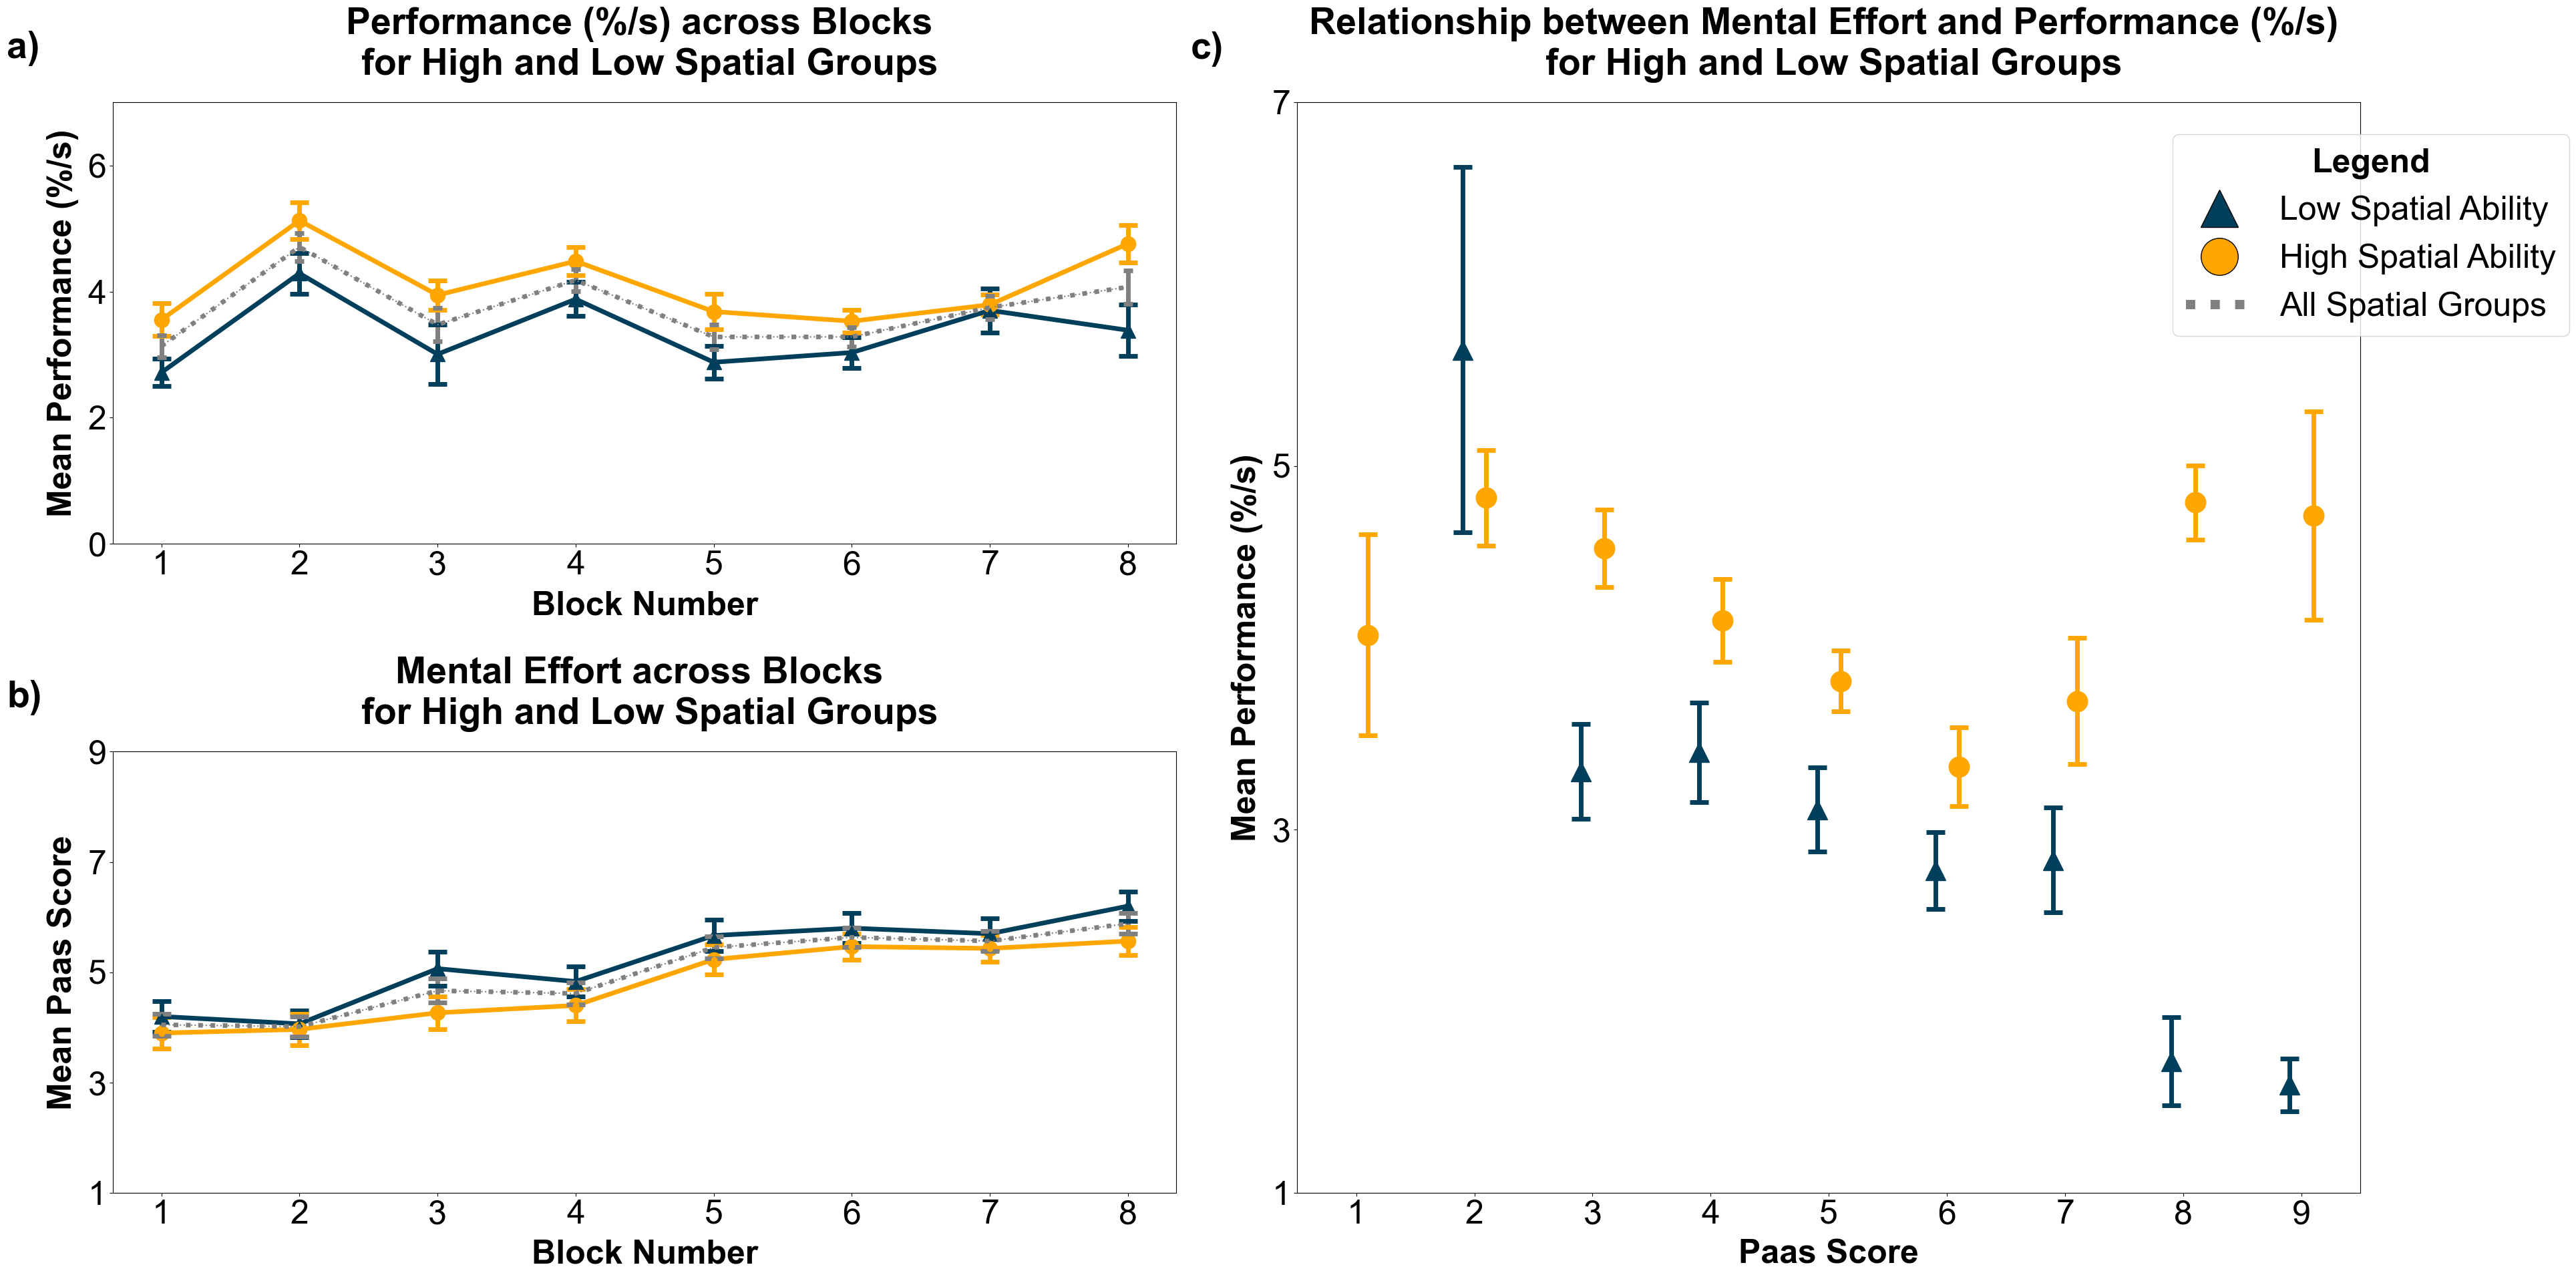

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D  
from scipy.stats import sem

# Splitting the dataset
low_spatial_df = newdf[newdf['MRTGroup'] == 'Low']
high_spatial_df = newdf[newdf['MRTGroup'] == 'High']

# Calculate means and SEMs for both groups
def calc_stats(df):
    grouped = df.groupby('subexperiment_number')
    means = grouped['performance_subexperiment'].mean()
    sems = grouped['performance_subexperiment'].sem()
    feedback_means = grouped['feedback_score_subexperiment'].mean()
    feedback_sems = grouped['feedback_score_subexperiment'].sem()
    return means, sems, feedback_means, feedback_sems

low_means, low_sems, low_feedback_means, low_feedback_sems = calc_stats(low_spatial_df)
high_means, high_sems, high_feedback_means, high_feedback_sems = calc_stats(high_spatial_df)
overall_means, overall_sems, overall_feedback_means, overall_feedback_sems = calc_stats(newdf)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 36
fig = plt.figure(figsize=(36, 20))
gs = GridSpec(2, 2, figure=fig)

# 1st subplot - Performance comparison
ax1 = fig.add_subplot(gs[0, 0])
ax1.errorbar(low_means.index, low_means, yerr=low_sems, fmt='^', capsize=10, color='#003f5c', label='Low Spatial Ability', linewidth=5, capthick=5)
ax1.errorbar(high_means.index, high_means, yerr=high_sems, fmt='o', capsize=10, color='#ffa600', label='High Spatial Ability', linewidth=5, capthick=5)
ax1.plot(low_means.index, low_means, '^-', color='#003f5c', markersize=16, linewidth=5)
ax1.plot(high_means.index, high_means, 'o-', color='#ffa600', markersize=16, linewidth=5)
ax1.set_title('Performance (%/s) across Blocks \n for High and Low Spatial Groups', fontsize=40, weight='bold', pad=30)
ax1.set_xlabel('Block Number', weight='bold', labelpad=10)
ax1.set_ylabel('Mean Performance (%/s)', weight='bold', labelpad=10)
ax1.set_ylim(0, 7)
ax1.set_yticks(range(0, 8, 2))
ax1.text(-0.1, 1.1, 'a)', transform=ax1.transAxes, size=40, weight='bold')
ax1.errorbar(overall_means.index, overall_means, yerr=overall_sems, fmt=':', capsize=5, color='grey', label='Overall', linewidth=5, capthick=5)
ax1.plot(overall_means.index, overall_means, ':', color='grey', markersize=16)

# 2nd subplot - Mental Effort comparison
ax2 = fig.add_subplot(gs[1, 0])
ax2.errorbar(low_feedback_means.index, low_feedback_means, yerr=low_feedback_sems, fmt='^', capsize=10, color='#003f5c', label='Low Spatial Ability', linewidth=5, capthick=5)
ax2.errorbar(high_feedback_means.index, high_feedback_means, yerr=high_feedback_sems, fmt='o', capsize=10, color='#ffa600', label='High Spatial Ability', linewidth=5, capthick=5)
ax2.plot(low_feedback_means.index, low_feedback_means, '^-', color='#003f5c', markersize=16, linewidth=5)
ax2.plot(high_feedback_means.index, high_feedback_means, 'o-', color='#ffa600', markersize=16, linewidth=5)
ax2.set_title('Mental Effort across Blocks \n for High and Low Spatial Groups', fontsize=40, weight='bold', pad=30)
ax2.set_xlabel('Block Number', weight='bold', labelpad=10)
ax2.set_ylabel('Mean Paas Score', weight='bold', labelpad=10)
ax2.set_ylim(1, 9)
ax2.set_yticks(range(1, 10, 2))
ax2.text(-0.1, 1.1, 'b)', transform=ax2.transAxes, size=40, weight='bold')
ax2.errorbar(overall_feedback_means.index, overall_feedback_means, yerr=overall_feedback_sems, fmt=':', capsize=10, color='grey', label='Overall', linewidth=5, capthick=5)
ax2.plot(overall_feedback_means.index, overall_feedback_means, ':', color='grey', markersize=16)

#3rd subplot - Line Plot with Error Bars
ax3 = fig.add_subplot(gs[:, 1])
data_to_plot = []
low_positions = []
high_positions = []
low_medians = []
high_medians = []
for i in range(1, 10):  # Pass scores from 1 to 9
    if i == 1:  # Special case for Paas score 1, only plot high spatial ability group data
        high_data = high_spatial_df[high_spatial_df['feedback_score_subexperiment'] == i]['performance_subexperiment'].values
        high_median = np.median(high_data)
        high_sem = sem(high_data)
        high_position = i + 0.1  # Adjusted for high spatial ability group
        # Correcting marker to circle and color to yellow for high spatial ability group
        ax3.plot(high_position, high_median, marker='o', markerfacecolor='#ffa600', markeredgecolor='#ffa600', markersize=22)
        ax3.errorbar(high_position, high_median, yerr=high_sem, fmt='none', ecolor='#ffa600', capsize=10, elinewidth=5, capthick=5)
    else:
        low_data = low_spatial_df[low_spatial_df['feedback_score_subexperiment'] == i]['performance_subexperiment'].values
        high_data = high_spatial_df[high_spatial_df['feedback_score_subexperiment'] == i]['performance_subexperiment'].values
        low_median = np.median(low_data)
        high_median = np.median(high_data)
        low_sem = sem(low_data)
        high_sem = sem(high_data)
        low_position = i - 0.1
        high_position = i + 0.1
        # Correcting marker to triangle and color to blue for low spatial ability group
        ax3.plot(low_position, low_median, marker='^', markerfacecolor='#003f5c', markeredgecolor='#003f5c', markersize=22)
        # Correcting marker to circle and color to yellow for high spatial ability group
        ax3.plot(high_position, high_median, marker='o', markerfacecolor='#ffa600', markeredgecolor='#ffa600', markersize=22)
        ax3.errorbar(low_position, low_median, yerr=low_sem, fmt='none', ecolor='#003f5c', capsize=10, elinewidth=5, capthick=5)
        ax3.errorbar(high_position, high_median, yerr=high_sem, fmt='none', ecolor='#ffa600', capsize=10, elinewidth=5, capthick=5)

ax3.set_title('Relationship between Mental Effort and Performance (%/s) \n for High and Low Spatial Groups', fontsize=40, weight='bold', pad=30)
ax3.set_xlabel('Paas Score', weight='bold', labelpad=10)
ax3.set_ylabel('Mean Performance (%/s)', weight='bold', labelpad=10)
ax3.set_xticks(np.arange(1, 10))
ax3.set_xticklabels(np.arange(1, 10))
ax3.set_yticks(np.arange(1, 8, 2))
ax3.set_xlim(0.5, 9.5)
ax3.set_ylim(1, 7)
ax3.text(-0.1, 1.04, 'c)', transform=ax3.transAxes, size=40, weight='bold')

# Adjust the labels list as per your actual labels
labels = ['Low Spatial Ability', 'High Spatial Ability']
custom_handles = [
    Line2D([0], [0], marker='^', color='none', markerfacecolor='#003f5c', markersize=40),  # high
    Line2D([0], [0], marker='o', color='none', markerfacecolor='#ffa600', markersize=40)   # low
]
# Add 'All Spatial Groups' with a thicker linestyle
labels.append('All Spatial Groups')
custom_handles.append(Line2D([0], [0], linestyle=':', color='grey', linewidth=10))  # Adjusted linewidth for thickness
legend = fig.legend(custom_handles, labels, loc='upper left', bbox_to_anchor=(0.9, 0.89))
legend.set_title('Legend', prop={'weight':'bold'})

plt.tight_layout()
plt.show()

### DryRunData3 (Per Trial)

In [63]:
data = []

# Iterate over the participant IDs
for participant_id in participants_indexes:
    # Get the participant's data
    participant_nback_data = nback_participants_data[participant_id]
    mrt_participant_data = mrt_participants_data[participant_id]
    participant_activeTime_data = activeTime_data[participant_id]
    participant_experiment_set_times = experiment_set_times_dict[participant_id]
    participant_experiment_phase_trials = experiment_phase_trials_dict[participant_id]['TrialDuration']
    participant_feedback = feedback[participant_id]
    participant_answers_data = answers_data[participant_id]
    participant_eye_tracking_data = eye_tracking_data_per_subexperiment[participant_id]
    participant_blink_info = blink_info_per_subexperiment[participant_id]
    participant_gaze_velocity = gaze_velocity_per_subexperiment[participant_id]
    participant_fixations = fixations_per_subexperiment[participant_id]

    # Iterate over the sub-experiments
    for trial in range(1, 33):
        # Create a dictionary for each participant and sub-experiment
        participant_data = {
            'participant_number': participant_id,
            'trial_number': trial,
            'subexperiment_number': (trial - 1) // 4,
            'MRTScore': mrt_participant_data['MRTScore'],
            'MRTAcc': mrt_participant_data['MRTAcc'],
            'MRTGroup': mrt_participant_data['MRTGroup'],
            'nback_hits_0' : participant_nback_data['hits'][0],
            'nback_hit_rate_0' : participant_nback_data['hit_rate'][0],
            'nback_correct_rejections_0' : participant_nback_data['correct_rejections'][0],
            'nback_rt_target_0': participant_nback_data['rt_target'][0],
            'nback_rt_nontarget_0': participant_nback_data['rt_non_target'][0],
            'nback_composite_0' : participant_nback_data['composite_score'][0],
            'nback_hits_1' : participant_nback_data['hits'][1],
            'nback_hit_rate_1' : participant_nback_data['hit_rate'][1],
            'nback_correct_rejections_1' : participant_nback_data['correct_rejections'][1],
            'nback_rt_target_1': participant_nback_data['rt_target'][1],
            'nback_rt_nontarget_1': participant_nback_data['rt_non_target'][1],
            'nback_composite_1' : participant_nback_data['composite_score'][1],
            'nback_hits_2' : participant_nback_data['hits'][2],
            'nback_hit_rate_2' : participant_nback_data['hit_rate'][2],
            'nback_correct_rejections_2' : participant_nback_data['correct_rejections'][2],
            'nback_rt_target_2': participant_nback_data['rt_target'][2],
            'nback_rt_nontarget_2': participant_nback_data['rt_non_target'][2],
            'nback_composite_2' : participant_nback_data['composite_score'][2],
            #'start_time': participant_activeTime_data['Start'][0],
            #'calibration_time': participant_activeTime_data['Calibration'][0],
            #'tutorial_time': participant_activeTime_data['Tutorial'][0],
            'rest_time': participant_activeTime_data['Rest'][0],
            'time_subexperiment': participant_experiment_set_times[subexperiment-1],
            'accuracy_subexperiment' : participant_answers_data['SubExperiments']['sum'][(trial - 1) // 4]/4 *100,
            'accuracy_total': participant_answers_data['Accuracy'],
            'answer_correct_trial': participant_answers_data['Trials']['sum'][(trial - 1) // 4][trial],
            'answer_incorrect_trial': participant_answers_data['Trials']['Incorrect'][(trial - 1) // 4][trial],
            'feedback_score_subexperiment': participant_feedback['experimental'][' FeedbackScore'][(trial - 1) // 4 + 4],
            #'blink_count': participant_blink_info[f'SubExperiment{subexperiment}']['blink_count'],
            #'rest_blink_rest_count': participant_blink_info[' Rest']['blink_count'],
            #'blink_rate' : participant_blink_info[f'SubExperiment{subexperiment}']['blink_rate'],
            #'rest_blink_rate': participant_blink_info[' Rest']['rest_blink_rate'],
            #'normalized_blink_rate': participant_blink_info[f'SubExperiment{subexperiment}']['normalized_blink_rate'],
            #'num_fixations': participant_fixations[f'SubExperiment{subexperiment}']['FixationGroup'].nunique(),
            #'num_fixations_rest': participant_fixations[' Rest']['FixationGroup'].nunique(),
            #'fixation_durations': participant_fixations[f'SubExperiment{subexperiment}']['TotalFixationDuration'].iloc[1],
            #'fixation_durations_rest': participant_fixations[' Rest']['TotalFixationDuration'].iloc[1],
            #'avg_FixationPointX': participant_fixations[f'SubExperiment{subexperiment}']['FixationPointX_avg'].iloc[1],
            #'avg_FixationPointY': participant_fixations[f'SubExperiment{subexperiment}']['FixationPointY_avg'].iloc[1],
            #'avg_FixationPointZ': participant_fixations[f'SubExperiment{subexperiment}']['FixationPointZ_avg'].iloc[1],
            #'avg_FixationPointX_rest': participant_fixations[' Rest']['FixationPointX_avg'].iloc[1],
            #'avg_FixationPointY_rest': participant_fixations[' Rest']['FixationPointY_avg'].iloc[1],
            #'avg_FixationPointZ_rest': participant_fixations[' Rest']['FixationPointZ_avg'].iloc[1],
        }

        # Inside the loop, after filling the participant_data dictionary
        nback_hits_avg = np.mean([participant_nback_data['hits'][i] for i in range(3)])
        nback_hit_rate_avg = np.mean([participant_nback_data['hit_rate'][i] for i in range(3)])
        nback_rt_target_avg = np.mean([participant_nback_data['rt_target'][i] for i in range(3)])
        nback_rt_non_target_avg = np.mean([participant_nback_data['rt_non_target'][i] for i in range(3)])
        nback_composite_avg = np.mean([participant_nback_data['composite_score'][i] for i in range(3)])

        # Add the averages to the participant_data dictionary
        participant_data['nback_hits_avg'] = nback_hits_avg
        participant_data['nback_hit_rate_avg'] = nback_hit_rate_avg
        participant_data['nback_rt_target_avg'] = nback_rt_target_avg
        participant_data['nback_rt_non_target_avg'] = nback_rt_non_target_avg
        participant_data['nback_composite_avg'] = nback_composite_avg

        # Add each trial duration as a separate column entry
        trial_duration = participant_experiment_phase_trials[trial - 1]
        participant_data['trial_duration'] = trial_duration

        # Calculate the mean duration using numpy's mean function and add it as another column
        participant_data['trial_duration_mean'] = np.mean([duration for duration in trial_durations])

        # Calculate performance_subexperiment
        participant_data['performance_trial'] = ((participant_data['accuracy_subexperiment'] / 100) / participant_data['trial_duration']) * 100

        # Add the feedback scores for all tutorial and rest phases
        for i, score in enumerate(participant_feedback['tutorial'][' FeedbackScore']):
            participant_data[f'feedback_score_tutorial_{i+1}'] = score
        for i, score in enumerate(participant_feedback['rest'][' FeedbackScore']):
            participant_data[f'feedback_score_rest_{i+1}'] = score

        # Add the eye tracking data to the participant data
        #for key, value in participant_eye_tracking_data[f'Trial{trial}'].items():
        #    participant_data[f'eye_{key}'] = value

        # Convert the dictionary to a Series and append it to the list
        data.append(pd.Series(participant_data, name=f'{participant_id}_trial{trial}'))
        
# Concatenate the Series in the list into a DataFrame
newnewdf = pd.concat(data, axis=1).T

In [64]:
newnewdf.to_csv('DryRunData3.csv', index=False)

### Simple RandomForest

In [65]:
# Train a random forest model to predict the feedback_score_subexperiment column
# Import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Read the data into a DataFrame
df = pd.read_csv('DryRunData2.csv')

# Split the data into training and testing sets
X = df.drop('feedback_score_subexperiment', axis=1)
y = df['feedback_score_subexperiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


# Train the model
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

# Make predictions
predictions = rfc.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

# Calculate the feature importances
feature_importances = pd.DataFrame(rfc.feature_importances_, index=X_train.columns, columns=['Importance']).sort_values('Importance', ascending=False)
print(feature_importances)

# Plot the feature importances
plt.figure(figsize=(10, 10))
sns.barplot(x=feature_importances.index, y=feature_importances['Importance'])
plt.xticks(rotation=90)
plt.show()

ValueError: could not convert string to float: 'High'

In [ ]:
#TODO: Add which subexperiment the participant is in for the newdf, number 2, normalize the features
